In [1]:
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

!pip install scikeras
from scikeras.wrappers import KerasClassifier

from tensorflow.keras import models, layers, utils, backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from google.colab import drive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Helper functions
from https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0

In [ ]:

'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers



'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

## Importing apple data

In [ ]:
sheet_id = '1KroMNRZYYqej1xI2b8pLZ5fzuzJAvmTb'

apple_df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")

apple_df.head()

apple_df.columns

Index(['Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt',
       'first_diff', 'daily_avg', 'Close_7d_ra', 'Close_30d_ra',
       'Close_90d_ra', 'Close_365d_ra', 'DA_7d_ra', 'DA_30d_ra', 'DA_90d_ra',
       'DA_365d_ra', 'diff_CRA_7d', 'diff_CRA_30d', 'diff_CRA_90d',
       'diff_CRA_365d', 'diff_DRA_7d', 'diff_DRA_30d', 'diff_DRA_90d',
       'diff_DRA_365d'],
      dtype='object')

Apple v3 data

In [ ]:
sheetv3_id = '1xeP8OzJ22tfIzsrXLKlagDYHf4gzQn81'

applev3_df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheetv3_id}/export?format=csv")

applev3_df.head()

Date     Open     High      Low    Close     Volume  OpenInt  \
0   10/4/1984  0.40593  0.40853  0.40593  0.40593   34995586        0   
1   10/5/1984  0.40593  0.40593  0.39443  0.39699   27211851        0   
2   10/8/1984  0.39699  0.39956  0.39699  0.39699   13099922        0   
3   10/9/1984  0.39699  0.39956  0.39316  0.39316   34933112        0   
4  10/10/1984  0.39316  0.39316  0.38164  0.38164  101750813        0   

   daily_avg    20d_ra   20d_std  ...  DA_365d_ra  diff_CRA_7d  diff_CRA_30d  \
0   0.406580  0.423981  0.017518  ...         NaN          NaN           NaN   
1   0.400820  0.422828  0.018268  ...         NaN          NaN           NaN   
2   0.397632  0.421659  0.019118  ...         NaN          NaN           NaN   
3   0.395717  0.419995  0.019879  ...         NaN          NaN           NaN   
4   0.387400  0.418203  0.021146  ...         NaN          NaN           NaN   

   diff_CRA_90d  diff_CRA_365d  diff_DRA_7d  diff_DRA_30d  diff_DRA_90d  \
0           NaN            NaN          NaN           NaN           NaN   
1           NaN            NaN          NaN           NaN           NaN   
2           NaN            NaN          NaN           NaN           NaN   
3           NaN            NaN          NaN           NaN           NaN   
4           NaN            NaN          NaN           NaN           NaN   

   diff_DRA_365d  first_diff  
0            NaN         NaN  
1            NaN    -0.00894  
2            NaN     0.00000  
3            NaN    -0.00383  
4            NaN    -0.01152  

[5 rows x 28 columns]

In [ ]:
applev3_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt',
       'daily_avg', '20d_ra', '20d_std', 'dev_from_band', 'Close_7d_ra',
       'Close_30d_ra', 'Close_90d_ra', 'Close_365d_ra', 'DA_7d_ra',
       'DA_30d_ra', 'DA_90d_ra', 'DA_365d_ra', 'diff_CRA_7d', 'diff_CRA_30d',
       'diff_CRA_90d', 'diff_CRA_365d', 'diff_DRA_7d', 'diff_DRA_30d',
       'diff_DRA_90d', 'diff_DRA_365d', 'first_diff'],
      dtype='object')

## Building a recurrent neural network

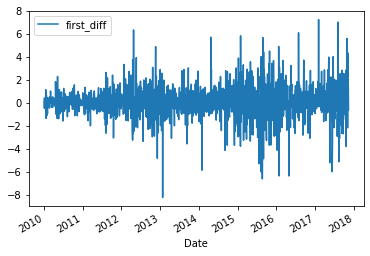

In [ ]:
temp_applev3_df = applev3_df
temp_applev3_df = temp_applev3_df[temp_applev3_df['Date'].str.contains('201')]
temp_applev3_df.index = pd.to_datetime(temp_applev3_df['Date'], format = '%m/%d/%Y')
temp_applev3_df = temp_applev3_df[['first_diff']]
temp_applev3_df.dropna()
temp_applev3_df.plot()


In [ ]:
def df_to_X_y_modified(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    if label > 0:
      target = 1
    else:
      target = 0
    y.append(target)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 1
X1, y1 = df_to_X_y_modified(temp_applev3_df, WINDOW_SIZE)
X1.shape, y1.shape

((1979, 1, 1, 1), (1979,))

In [ ]:
## Train test val split
X_train1, y_train1 = X1[:1500], y1[:1500]
X_val1, y_val1 = X1[1500:1700], y1[1500:1700]
X_test1, y_test1 = X1[1700:], y1[1700:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1500, 1, 1, 1), (1500,), (200, 1, 1, 1), (200,), (279, 1, 1, 1), (279,))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


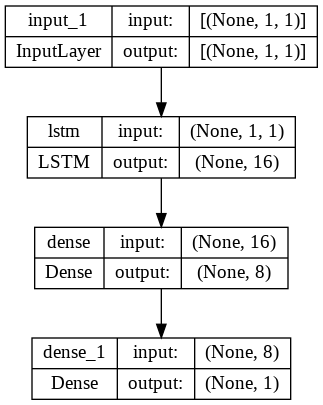

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((1, 1)))
LSTMModel.add(LSTM(16))
LSTMModel.add(Dense(8, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.summary()
utils.plot_model(LSTMModel, to_file='model.png', show_shapes=True, show_layer_names=True)

Epoch 1/300
34/47 [====================>.........] - ETA: 0s - loss: 0.4553 - root_mean_squared_error: 0.6747

47/47 [==============================] - 9s 144ms/step - loss: 0.4380 - root_mean_squared_error: 0.6618 - val_loss: 0.3630 - val_root_mean_squared_error: 0.6025
Epoch 2/300
36/47 [=====================>........] - ETA: 0s - loss: 0.3373 - root_mean_squared_error: 0.5808

47/47 [==============================] - 9s 202ms/step - loss: 0.3300 - root_mean_squared_error: 0.5744 - val_loss: 0.2833 - val_root_mean_squared_error: 0.5322
Epoch 3/300
40/47 [========================>.....] - ETA: 0s - loss: 0.2751 - root_mean_squared_error: 0.5245

47/47 [==============================] - 12s 263ms/step - loss: 0.2725 - root_mean_squared_error: 0.5220 - val_loss: 0.2569 - val_root_mean_squared_error: 0.5068
Epoch 4/300
38/47 [=======================>......] - ETA: 0s - loss: 0.2553 - root_mean_squared_error: 0.5053

47/47 [==============================] - 10s 211ms/step - loss: 0.2546 - root_mean_squared_error: 0.5046 - val_loss: 0.2523 - val_root_mean_squared_error: 0.5023
Epoch 5/300
46/47 [============================>.] - ETA: 0s - loss: 0.2513 - root_mean_squared_error: 0.5013

47/47 [==============================] - 6s 138ms/step - loss: 0.2512 - root_mean_squared_error: 0.5012 - val_loss: 0.2508 - val_root_mean_squared_error: 0.5008
Epoch 6/300
38/47 [=======================>......] - ETA: 0s - loss: 0.2501 - root_mean_squared_error: 0.5001

47/47 [==============================] - 5s 112ms/step - loss: 0.2499 - root_mean_squared_error: 0.4999 - val_loss: 0.2506 - val_root_mean_squared_error: 0.5006
Epoch 7/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2495 - root_mean_squared_error: 0.4995 - val_loss: 0.2509 - val_root_mean_squared_error: 0.5009
Epoch 8/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991 - val_loss: 0.2513 - val_root_mean_squared_error: 0.5013
Epoch 9/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991 - val_loss: 0.2512 - val_root_mean_squared_error: 0.5012
Epoch 10/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2492 - root_mean_squared_error: 0.4992 - val_loss: 0.2513 - val_root_mean_squared_error: 0.5013
Epoch 11/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991 - val_loss: 0.2514 - val_root_mean_squa

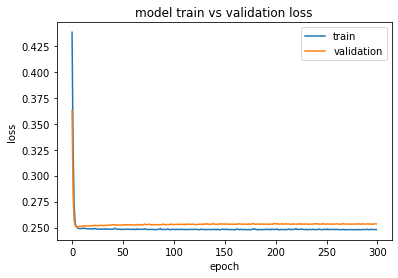

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModel/', save_best_only=True)
LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
LSTMModel = load_model('LSTMModel/')

In [ ]:
val_predictions = LSTMModel.predict(X_val1).flatten()
cleaned_predictions = []
for i in range(len(val_predictions)):
  if val_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
val_results = pd.DataFrame(data={'Val Predictions':cleaned_predictions, 'Actuals':y_val1.flatten()})
val_results

7/7 [==============================] - 1s 2ms/step


Val Predictions  Actuals
0                  1        0
1                  1        1
2                  1        0
3                  1        1
4                  1        0
..               ...      ...
195                1        1
196                1        0
197                1        1
198                1        0
199                1        1

[200 rows x 2 columns]

In [ ]:
test_accuracy = metrics.accuracy_score(val_results.loc[:,"Actuals"], val_results.loc[:,"Val Predictions"])
print('Our testing accuracy is {}'.format(test_accuracy))

Our testing accuracy is 0.525


In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
cleaned_predictions = []
for i in range(len(test_predictions)):
  if test_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
test_results = pd.DataFrame(data={'Test Predictions':cleaned_predictions, 'Actuals':y_test1.flatten()})
test_results

9/9 [==============================] - 0s 4ms/step


Test Predictions  Actuals
0                   1        1
1                   1        1
2                   1        1
3                   1        1
4                   1        1
..                ...      ...
274                 0        1
275                 1        1
276                 1        1
277                 1        0
278                 1        0

[279 rows x 2 columns]

In [ ]:
test_accuracy = metrics.accuracy_score(test_results.loc[:,"Actuals"], test_results.loc[:,"Test Predictions"])
print('Our testing accuracy is {}'.format(test_accuracy))

Our testing accuracy is 0.5483870967741935


Adjusting Learning rate to 0.005

Epoch 1/300
40/47 [========================>.....] - ETA: 0s - loss: 0.2517 - root_mean_squared_error: 0.5017

47/47 [==============================] - 8s 123ms/step - loss: 0.2526 - root_mean_squared_error: 0.5026 - val_loss: 0.2514 - val_root_mean_squared_error: 0.5014
Epoch 2/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2516 - root_mean_squared_error: 0.5016 - val_loss: 0.2529 - val_root_mean_squared_error: 0.5028
Epoch 3/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2507 - root_mean_squared_error: 0.5007 - val_loss: 0.2525 - val_root_mean_squared_error: 0.5025
Epoch 4/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004 - val_loss: 0.2531 - val_root_mean_squared_error: 0.5031
Epoch 5/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2505 - root_mean_squared_error: 0.5005 - val_loss: 0.2542 - val_root_mean_squared_error: 0.5041
Epoch 6/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2515 - root_mean_squared_error: 0.5015 - val_loss: 0.2543 - val_root_mean_square

47/47 [==============================] - 7s 152ms/step - loss: 0.2496 - root_mean_squared_error: 0.4996 - val_loss: 0.2514 - val_root_mean_squared_error: 0.5014
Epoch 25/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2507 - root_mean_squared_error: 0.5007 - val_loss: 0.2531 - val_root_mean_squared_error: 0.5030
Epoch 26/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2503 - root_mean_squared_error: 0.5003 - val_loss: 0.2559 - val_root_mean_squared_error: 0.5059
Epoch 27/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2529 - root_mean_squared_error: 0.5029 - val_loss: 0.2565 - val_root_mean_squared_error: 0.5064
Epoch 28/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2507 - root_mean_squared_error: 0.5007 - val_loss: 0.2535 - val_root_mean_squared_error: 0.5035
Epoch 29/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2497 - root_mean_squared_error: 0.4997 - val_loss: 0.2531 - val_root_mean_s

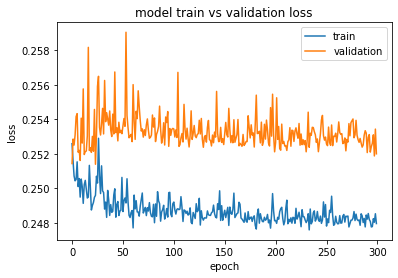

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModel/', save_best_only=True)
LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.005), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
LSTMModel = load_model('LSTMModel/')

In [ ]:
val_predictions = LSTMModel.predict(X_val1).flatten()
cleaned_predictions = []
for i in range(len(val_predictions)):
  if val_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
val_results = pd.DataFrame(data={'Val Predictions':cleaned_predictions, 'Actuals':y_val1.flatten()})
val_results

7/7 [==============================] - 1s 3ms/step


Val Predictions  Actuals
0                  1        0
1                  1        1
2                  1        0
3                  1        1
4                  1        0
..               ...      ...
195                1        1
196                1        0
197                1        1
198                1        0
199                1        1

[200 rows x 2 columns]

In [ ]:
test_accuracy = metrics.accuracy_score(val_results.loc[:,"Actuals"], val_results.loc[:,"Val Predictions"])
print('Our Validation accuracy is {}'.format(test_accuracy))

Our testing accuracy is 0.53


In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
cleaned_predictions = []
for i in range(len(test_predictions)):
  if test_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
test_results = pd.DataFrame(data={'Test Predictions':cleaned_predictions, 'Actuals':y_test1.flatten()})
test_results

9/9 [==============================] - 0s 4ms/step


Test Predictions  Actuals
0                   1        1
1                   1        1
2                   1        1
3                   1        1
4                   0        1
..                ...      ...
274                 0        1
275                 1        1
276                 1        1
277                 1        0
278                 1        0

[279 rows x 2 columns]

In [ ]:
test_accuracy = metrics.accuracy_score(test_results.loc[:,"Actuals"], test_results.loc[:,"Test Predictions"])
print('Our testing accuracy is {}'.format(test_accuracy))

Our testing accuracy is 0.5125448028673835


Adjusting Learning rate to 0.01 

Epoch 1/300
37/47 [======================>.......] - ETA: 0s - loss: 0.2556 - root_mean_squared_error: 0.5056

47/47 [==============================] - 10s 138ms/step - loss: 0.2541 - root_mean_squared_error: 0.5041 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 2/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2519 - root_mean_squared_error: 0.5019 - val_loss: 0.2554 - val_root_mean_squared_error: 0.5054
Epoch 3/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2520 - root_mean_squared_error: 0.5020 - val_loss: 0.2525 - val_root_mean_squared_error: 0.5025
Epoch 4/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2509 - root_mean_squared_error: 0.5009 - val_loss: 0.2545 - val_root_mean_squared_error: 0.5044
Epoch 5/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2492 - root_mean_squared_error: 0.4992 - val_loss: 0.2550 - val_root_mean_squared_error: 0.5049
Epoch 6/300
32/47 [===================>..........] - ETA: 0s - loss: 0.2499 - root_mean_squared_error: 0.4999

47/47 [==============================] - 7s 151ms/step - loss: 0.2507 - root_mean_squared_error: 0.5007 - val_loss: 0.2510 - val_root_mean_squared_error: 0.5010
Epoch 7/300
47/47 [==============================] - 0s 10ms/step - loss: 0.2495 - root_mean_squared_error: 0.4995 - val_loss: 0.2522 - val_root_mean_squared_error: 0.5022
Epoch 8/300
47/47 [==============================] - 0s 10ms/step - loss: 0.2496 - root_mean_squared_error: 0.4996 - val_loss: 0.2520 - val_root_mean_squared_error: 0.5020
Epoch 9/300
47/47 [==============================] - 0s 8ms/step - loss: 0.2502 - root_mean_squared_error: 0.5002 - val_loss: 0.2540 - val_root_mean_squared_error: 0.5040
Epoch 10/300
47/47 [==============================] - 0s 8ms/step - loss: 0.2497 - root_mean_squared_error: 0.4997 - val_loss: 0.2522 - val_root_mean_squared_error: 0.5022
Epoch 11/300
47/47 [==============================] - 0s 8ms/step - loss: 0.2494 - root_mean_squared_error: 0.4994 - val_loss: 0.2526 - val_root_mean_sq

47/47 [==============================] - 6s 120ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985 - val_loss: 0.2510 - val_root_mean_squared_error: 0.5010
Epoch 83/300
43/47 [==========================>...] - ETA: 0s - loss: 0.2486 - root_mean_squared_error: 0.4986

47/47 [==============================] - 5s 105ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990 - val_loss: 0.2510 - val_root_mean_squared_error: 0.5010
Epoch 84/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2515 - val_root_mean_squared_error: 0.5015
Epoch 85/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987 - val_loss: 0.2522 - val_root_mean_squared_error: 0.5022
Epoch 86/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991 - val_loss: 0.2526 - val_root_mean_squared_error: 0.5026
Epoch 87/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987 - val_loss: 0.2545 - val_root_mean_squared_error: 0.5045
Epoch 88/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2522 - val_root_mean_s

47/47 [==============================] - 6s 121ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988 - val_loss: 0.2509 - val_root_mean_squared_error: 0.5009
Epoch 122/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991 - val_loss: 0.2524 - val_root_mean_squared_error: 0.5024
Epoch 123/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985 - val_loss: 0.2524 - val_root_mean_squared_error: 0.5024
Epoch 124/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 125/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985 - val_loss: 0.2520 - val_root_mean_squared_error: 0.5020
Epoch 126/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2525 - val_root_m

47/47 [==============================] - 5s 108ms/step - loss: 0.2495 - root_mean_squared_error: 0.4995 - val_loss: 0.2507 - val_root_mean_squared_error: 0.5007
Epoch 240/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988 - val_loss: 0.2530 - val_root_mean_squared_error: 0.5030
Epoch 241/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019
Epoch 242/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2522 - val_root_mean_squared_error: 0.5022
Epoch 243/300
47/47 [==============================] - 0s 3ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990 - val_loss: 0.2517 - val_root_mean_squared_error: 0.5017
Epoch 244/300
47/47 [==============================] - 0s 4ms/step - loss: 0.2489 - root_mean_squared_error: 0.4988 - val_loss: 0.2514 - val_root_m

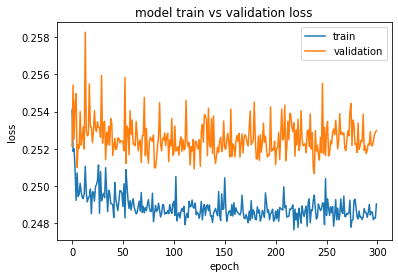

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModel/', save_best_only=True)
LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
LSTMModel = load_model('LSTMModel/')

In [ ]:
val_predictions = LSTMModel.predict(X_val1).flatten()
cleaned_predictions = []
for i in range(len(val_predictions)):
  if val_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
val_results = pd.DataFrame(data={'Val Predictions':cleaned_predictions, 'Actuals':y_val1.flatten()})
val_results

7/7 [==============================] - 1s 3ms/step


Val Predictions  Actuals
0                  1        0
1                  1        1
2                  1        0
3                  1        1
4                  1        0
..               ...      ...
195                1        1
196                1        0
197                1        1
198                1        0
199                1        1

[200 rows x 2 columns]

In [ ]:
validation_accuracy = metrics.accuracy_score(val_results.loc[:,"Actuals"], val_results.loc[:,"Val Predictions"])
print('Our Validation accuracy is {}'.format(validation_accuracy))

Our Validation accuracy is 0.515


In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
cleaned_predictions = []
for i in range(len(test_predictions)):
  if test_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
test_results = pd.DataFrame(data={'Test Predictions':cleaned_predictions, 'Actuals':y_test1.flatten()})
test_results

9/9 [==============================] - 0s 2ms/step


Test Predictions  Actuals
0                   1        1
1                   1        1
2                   1        1
3                   1        1
4                   0        1
..                ...      ...
274                 0        1
275                 0        1
276                 1        1
277                 1        0
278                 1        0

[279 rows x 2 columns]

In [ ]:
test_accuracy = metrics.accuracy_score(test_results.loc[:,"Actuals"], test_results.loc[:,"Test Predictions"])
print('Our testing accuracy is {}'.format(test_accuracy))

Our testing accuracy is 0.5376344086021505


Increasing learning rate doesnt seem to help, only decreases accuracy

Increase Epochs to 500

Epoch 1/500
45/47 [===========================>..] - ETA: 0s - loss: 0.2487 - root_mean_squared_error: 0.4987

47/47 [==============================] - 13s 165ms/step - loss: 0.2489 - root_mean_squared_error: 0.4989 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019
Epoch 2/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 3/500
47/47 [==============================] - 0s 5ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988 - val_loss: 0.2523 - val_root_mean_squared_error: 0.5023
Epoch 4/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2524 - val_root_mean_squared_error: 0.5024
Epoch 5/500
38/47 [=======================>......] - ETA: 0s - loss: 0.2490 - root_mean_squared_error: 0.4990

47/47 [==============================] - 5s 117ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987 - val_loss: 0.2515 - val_root_mean_squared_error: 0.5015
Epoch 6/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2498 - root_mean_squared_error: 0.4998 - val_loss: 0.2529 - val_root_mean_squared_error: 0.5029
Epoch 7/500
47/47 [==============================] - 0s 5ms/step - loss: 0.2511 - root_mean_squared_error: 0.5011 - val_loss: 0.2526 - val_root_mean_squared_error: 0.5025
Epoch 8/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2526 - val_root_mean_squared_error: 0.5026
Epoch 9/500
47/47 [==============================] - 0s 5ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 10/500
47/47 [==============================] - 0s 5ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2538 - val_root_mean_squar

47/47 [==============================] - 6s 135ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991 - val_loss: 0.2514 - val_root_mean_squared_error: 0.5014
Epoch 69/500
47/47 [==============================] - 0s 5ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981 - val_loss: 0.2529 - val_root_mean_squared_error: 0.5029
Epoch 70/500
47/47 [==============================] - 0s 5ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.2525 - val_root_mean_squared_error: 0.5025
Epoch 71/500
47/47 [==============================] - 0s 5ms/step - loss: 0.2478 - root_mean_squared_error: 0.4978 - val_loss: 0.2527 - val_root_mean_squared_error: 0.5027
Epoch 72/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.2524 - val_root_mean_squared_error: 0.5023
Epoch 73/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.2526 - val_root_mean_s

47/47 [==============================] - 5s 117ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988 - val_loss: 0.2512 - val_root_mean_squared_error: 0.5012
Epoch 117/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985 - val_loss: 0.2522 - val_root_mean_squared_error: 0.5022
Epoch 118/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2523 - val_root_mean_squared_error: 0.5023
Epoch 119/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990 - val_loss: 0.2518 - val_root_mean_squared_error: 0.5018
Epoch 120/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2531 - val_root_mean_squared_error: 0.5031
Epoch 121/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987 - val_loss: 0.2522 - val_root_m

47/47 [==============================] - 6s 134ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2511 - val_root_mean_squared_error: 0.5011
Epoch 322/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988 - val_loss: 0.2515 - val_root_mean_squared_error: 0.5015
Epoch 323/500
47/47 [==============================] - 0s 5ms/step - loss: 0.2480 - root_mean_squared_error: 0.4980 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 324/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2480 - root_mean_squared_error: 0.4980 - val_loss: 0.2528 - val_root_mean_squared_error: 0.5028
Epoch 325/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.2524 - val_root_mean_squared_error: 0.5024
Epoch 326/500
47/47 [==============================] - 0s 4ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2526 - val_root_m

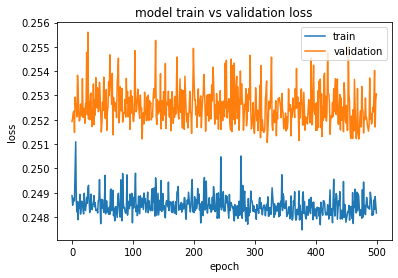

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModel/', save_best_only=True)
LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=500, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
LSTMModel = load_model('LSTMModel/')

In [ ]:
val_predictions = LSTMModel.predict(X_val1).flatten()
cleaned_predictions = []
for i in range(len(val_predictions)):
  if val_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
val_results = pd.DataFrame(data={'Val Predictions':cleaned_predictions, 'Actuals':y_val1.flatten()})
val_results

7/7 [==============================] - 1s 3ms/step


Val Predictions  Actuals
0                  1        0
1                  1        1
2                  1        0
3                  1        1
4                  1        0
..               ...      ...
195                1        1
196                1        0
197                1        1
198                1        0
199                1        1

[200 rows x 2 columns]

In [ ]:
validation_accuracy = metrics.accuracy_score(val_results.loc[:,"Actuals"], val_results.loc[:,"Val Predictions"])
print('Our Validation accuracy is {}'.format(validation_accuracy))

Our Validation accuracy is 0.525


In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
cleaned_predictions = []
for i in range(len(test_predictions)):
  if test_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
test_results = pd.DataFrame(data={'Test Predictions':cleaned_predictions, 'Actuals':y_test1.flatten()})
test_results

9/9 [==============================] - 0s 3ms/step


Test Predictions  Actuals
0                   1        1
1                   1        1
2                   1        1
3                   1        1
4                   0        1
..                ...      ...
274                 0        1
275                 0        1
276                 1        1
277                 1        0
278                 1        0

[279 rows x 2 columns]

In [ ]:
test_accuracy = metrics.accuracy_score(test_results.loc[:,"Actuals"], test_results.loc[:,"Test Predictions"])
print('Our testing accuracy is {}'.format(test_accuracy))

Our testing accuracy is 0.5376344086021505


Decreasing epochs to 100

Epoch 1/100
38/47 [=======================>......] - ETA: 0s - loss: 0.2478 - root_mean_squared_error: 0.4978

47/47 [==============================] - 11s 156ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982 - val_loss: 0.2525 - val_root_mean_squared_error: 0.5025
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2528 - val_root_mean_squared_error: 0.5027
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.2482 - root_mean_squared_error: 0.4982

47/47 [==============================] - 5s 116ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019
Epoch 4/100
47/47 [==============================] - 0s 3ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2524 - val_root_mean_squared_error: 0.5024
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2520 - val_root_mean_squared_error: 0.5020
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2480 - root_mean_squared_error: 0.4980 - val_loss: 0.2528 - val_root_mean_squared_error: 0.5028
Epoch 7/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987 - val_loss: 0.2530 - val_root_mean_squared_error: 0.5030
Epoch 8/100
47/47 [==============================] - 0s 5ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2525 - val_root_mean_square

47/47 [==============================] - 5s 115ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987 - val_loss: 0.2517 - val_root_mean_squared_error: 0.5017
Epoch 11/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982 - val_loss: 0.2528 - val_root_mean_squared_error: 0.5028
Epoch 12/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.2520 - val_root_mean_squared_error: 0.5020
Epoch 13/100
47/47 [==============================] - 0s 5ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 14/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2480 - root_mean_squared_error: 0.4980 - val_loss: 0.2533 - val_root_mean_squared_error: 0.5033
Epoch 15/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982 - val_loss: 0.2536 - val_root_mean_s

47/47 [==============================] - 6s 134ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981 - val_loss: 0.2516 - val_root_mean_squared_error: 0.5016
Epoch 18/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.2523 - val_root_mean_squared_error: 0.5023
Epoch 19/100
47/47 [==============================] - 0s 5ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981 - val_loss: 0.2526 - val_root_mean_squared_error: 0.5026
Epoch 20/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2479 - root_mean_squared_error: 0.4979 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019
Epoch 21/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991 - val_loss: 0.2542 - val_root_mean_squared_error: 0.5042
Epoch 22/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2498 - root_mean_squared_error: 0.4998 - val_loss: 0.2521 - val_root_mean_s

47/47 [==============================] - 5s 117ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987 - val_loss: 0.2512 - val_root_mean_squared_error: 0.5012
Epoch 29/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2480 - root_mean_squared_error: 0.4980 - val_loss: 0.2531 - val_root_mean_squared_error: 0.5031
Epoch 30/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 31/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.2524 - val_root_mean_squared_error: 0.5024
Epoch 32/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5018
Epoch 33/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2485 - root_mean_squared_error: 0.4984 - val_loss: 0.2529 - val_root_mean_s

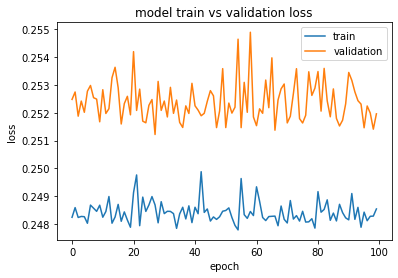

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModel/', save_best_only=True)
LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
LSTMModel = load_model('LSTMModel/')

In [ ]:
val_predictions = LSTMModel.predict(X_val1).flatten()
cleaned_predictions = []
for i in range(len(val_predictions)):
  if val_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
val_results = pd.DataFrame(data={'Val Predictions':cleaned_predictions, 'Actuals':y_val1.flatten()})
val_results

7/7 [==============================] - 1s 3ms/step


Val Predictions  Actuals
0                  1        0
1                  1        1
2                  1        0
3                  1        1
4                  1        0
..               ...      ...
195                1        1
196                1        0
197                1        1
198                1        0
199                1        1

[200 rows x 2 columns]

In [ ]:
validation_accuracy = metrics.accuracy_score(val_results.loc[:,"Actuals"], val_results.loc[:,"Val Predictions"])
print('Our Validation accuracy is {}'.format(validation_accuracy))

Our Validation accuracy is 0.52


In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
cleaned_predictions = []
for i in range(len(test_predictions)):
  if test_predictions[i] >= 0.5:
    cleaned_predictions.append(1)
  else:
    cleaned_predictions.append(0)
test_results = pd.DataFrame(data={'Test Predictions':cleaned_predictions, 'Actuals':y_test1.flatten()})
test_results

9/9 [==============================] - 0s 2ms/step


Test Predictions  Actuals
0                   1        1
1                   1        1
2                   1        1
3                   1        1
4                   0        1
..                ...      ...
274                 0        1
275                 1        1
276                 1        1
277                 1        0
278                 1        0

[279 rows x 2 columns]

In [ ]:
test_accuracy = metrics.accuracy_score(test_results.loc[:,"Actuals"], test_results.loc[:,"Test Predictions"])
print('Our testing accuracy is {}'.format(test_accuracy))

Our testing accuracy is 0.5340501792114696


## Building LSTM Nicholas
With reference to this notebook: https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing

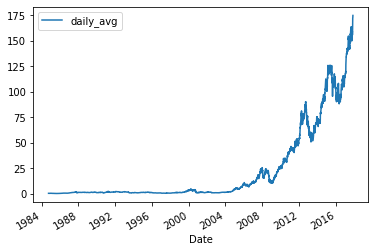

In [ ]:
temp_applev3_df = applev3_df
temp_applev3_df.index = pd.to_datetime(temp_applev3_df['Date'], format = '%m/%d/%Y')
temp_applev3_df = temp_applev3_df[['daily_avg']]

temp_applev3_df.plot()

In [ ]:
## Helper function to format X inputs and y outputs

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp_applev3_df, WINDOW_SIZE)
X1.shape, y1.shape

((8343, 5, 1, 1), (8343, 1))

In [ ]:
## Train test val split
X_train1, y_train1 = X1[:7300], y1[:7300]
X_val1, y_val1 = X1[7300:7800], y1[7300:7800]
X_test1, y_test1 = X1[7800:], y1[7800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((7300, 5, 1, 1),
 (7300, 1),
 (500, 5, 1, 1),
 (500, 1),
 (543, 5, 1, 1),
 (543, 1))

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((5, 1)))
LSTMModel.add(LSTM(64))
LSTMModel.add(Dense(8, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


Learning rate = 0.0001

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModel/', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.00001, verbose=1)
LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Epoch 1/100
226/229 [============================>.] - ETA: 0s - loss: 429.3511 - root_mean_squared_error: 20.7208

229/229 [==============================] - 28s 77ms/step - loss: 431.3181 - root_mean_squared_error: 20.7682 - val_loss: 9252.7676 - val_root_mean_squared_error: 96.1913 - lr: 1.0000e-04
Epoch 2/100
221/229 [===========================>..] - ETA: 0s - loss: 377.9696 - root_mean_squared_error: 19.4414

229/229 [==============================] - 8s 35ms/step - loss: 377.4136 - root_mean_squared_error: 19.4271 - val_loss: 8737.4268 - val_root_mean_squared_error: 93.4742 - lr: 1.0000e-04
Epoch 3/100
222/229 [============================>.] - ETA: 0s - loss: 306.3818 - root_mean_squared_error: 17.5038

229/229 [==============================] - 7s 30ms/step - loss: 306.9525 - root_mean_squared_error: 17.5201 - val_loss: 7789.7344 - val_root_mean_squared_error: 88.2595 - lr: 1.0000e-04
Epoch 4/100
222/229 [============================>.] - ETA: 0s - loss: 260.8357 - root_mean_squared_error: 16.1504

229/229 [==============================] - 7s 29ms/step - loss: 260.6350 - root_mean_squared_error: 16.1442 - val_loss: 7218.0073 - val_root_mean_squared_error: 84.9589 - lr: 1.0000e-04
Epoch 5/100
224/229 [============================>.] - ETA: 0s - loss: 230.1537 - root_mean_squared_error: 15.1708

229/229 [==============================] - 8s 33ms/step - loss: 229.4439 - root_mean_squared_error: 15.1474 - val_loss: 6755.3613 - val_root_mean_squared_error: 82.1910 - lr: 1.0000e-04
Epoch 6/100
229/229 [==============================] - ETA: 0s - loss: 201.3664 - root_mean_squared_error: 14.1904

229/229 [==============================] - 7s 29ms/step - loss: 201.3664 - root_mean_squared_error: 14.1904 - val_loss: 6318.7007 - val_root_mean_squared_error: 79.4903 - lr: 1.0000e-04
Epoch 7/100
228/229 [============================>.] - ETA: 0s - loss: 178.8050 - root_mean_squared_error: 13.3718

229/229 [==============================] - 7s 30ms/step - loss: 178.7071 - root_mean_squared_error: 13.3681 - val_loss: 5951.1445 - val_root_mean_squared_error: 77.1437 - lr: 1.0000e-04
Epoch 8/100
221/229 [===========================>..] - ETA: 0s - loss: 160.5483 - root_mean_squared_error: 12.6708

229/229 [==============================] - 8s 33ms/step - loss: 158.3732 - root_mean_squared_error: 12.5846 - val_loss: 5593.5518 - val_root_mean_squared_error: 74.7901 - lr: 1.0000e-04
Epoch 9/100
224/229 [============================>.] - ETA: 0s - loss: 140.1181 - root_mean_squared_error: 11.8372

229/229 [==============================] - 7s 29ms/step - loss: 140.1534 - root_mean_squared_error: 11.8386 - val_loss: 5260.0210 - val_root_mean_squared_error: 72.5260 - lr: 1.0000e-04
Epoch 10/100
220/229 [===========================>..] - ETA: 0s - loss: 124.1211 - root_mean_squared_error: 11.1410

229/229 [==============================] - 6s 28ms/step - loss: 123.6156 - root_mean_squared_error: 11.1183 - val_loss: 4936.8496 - val_root_mean_squared_error: 70.2627 - lr: 1.0000e-04
Epoch 11/100
223/229 [============================>.] - ETA: 0s - loss: 109.1300 - root_mean_squared_error: 10.4465

229/229 [==============================] - 8s 34ms/step - loss: 108.5611 - root_mean_squared_error: 10.4193 - val_loss: 4626.9502 - val_root_mean_squared_error: 68.0217 - lr: 1.0000e-04
Epoch 12/100
229/229 [==============================] - ETA: 0s - loss: 94.8531 - root_mean_squared_error: 9.7393

229/229 [==============================] - 7s 30ms/step - loss: 94.8531 - root_mean_squared_error: 9.7393 - val_loss: 4330.8169 - val_root_mean_squared_error: 65.8089 - lr: 1.0000e-04
Epoch 13/100
227/229 [============================>.] - ETA: 0s - loss: 82.2462 - root_mean_squared_error: 9.0690

229/229 [==============================] - 7s 29ms/step - loss: 81.9124 - root_mean_squared_error: 9.0505 - val_loss: 4024.4714 - val_root_mean_squared_error: 63.4387 - lr: 1.0000e-04
Epoch 14/100
224/229 [============================>.] - ETA: 0s - loss: 69.5411 - root_mean_squared_error: 8.3391

229/229 [==============================] - 8s 34ms/step - loss: 70.3514 - root_mean_squared_error: 8.3876 - val_loss: 3749.5095 - val_root_mean_squared_error: 61.2332 - lr: 1.0000e-04
Epoch 15/100
226/229 [============================>.] - ETA: 0s - loss: 60.7469 - root_mean_squared_error: 7.7940

229/229 [==============================] - 10s 42ms/step - loss: 60.3132 - root_mean_squared_error: 7.7662 - val_loss: 3486.4785 - val_root_mean_squared_error: 59.0464 - lr: 1.0000e-04
Epoch 16/100
222/229 [============================>.] - ETA: 0s - loss: 51.9926 - root_mean_squared_error: 7.2106

229/229 [==============================] - 7s 29ms/step - loss: 51.6062 - root_mean_squared_error: 7.1837 - val_loss: 3245.1294 - val_root_mean_squared_error: 56.9660 - lr: 1.0000e-04
Epoch 17/100
224/229 [============================>.] - ETA: 0s - loss: 43.9788 - root_mean_squared_error: 6.6317

229/229 [==============================] - 8s 33ms/step - loss: 44.0099 - root_mean_squared_error: 6.6340 - val_loss: 3016.7192 - val_root_mean_squared_error: 54.9247 - lr: 1.0000e-04
Epoch 18/100
222/229 [============================>.] - ETA: 0s - loss: 37.5846 - root_mean_squared_error: 6.1306

229/229 [==============================] - 7s 29ms/step - loss: 37.4311 - root_mean_squared_error: 6.1181 - val_loss: 2802.8384 - val_root_mean_squared_error: 52.9418 - lr: 1.0000e-04
Epoch 19/100
229/229 [==============================] - ETA: 0s - loss: 31.6632 - root_mean_squared_error: 5.6270

229/229 [==============================] - 7s 29ms/step - loss: 31.6632 - root_mean_squared_error: 5.6270 - val_loss: 2599.8289 - val_root_mean_squared_error: 50.9885 - lr: 1.0000e-04
Epoch 20/100
227/229 [============================>.] - ETA: 0s - loss: 26.9532 - root_mean_squared_error: 5.1916

229/229 [==============================] - 8s 34ms/step - loss: 26.8236 - root_mean_squared_error: 5.1792 - val_loss: 2415.0198 - val_root_mean_squared_error: 49.1428 - lr: 1.0000e-04
Epoch 21/100
221/229 [===========================>..] - ETA: 0s - loss: 23.1158 - root_mean_squared_error: 4.8079

229/229 [==============================] - 6s 28ms/step - loss: 22.6685 - root_mean_squared_error: 4.7611 - val_loss: 2244.3623 - val_root_mean_squared_error: 47.3747 - lr: 1.0000e-04
Epoch 22/100
224/229 [============================>.] - ETA: 0s - loss: 18.8289 - root_mean_squared_error: 4.3392

229/229 [==============================] - 7s 32ms/step - loss: 19.0857 - root_mean_squared_error: 4.3687 - val_loss: 2085.8396 - val_root_mean_squared_error: 45.6710 - lr: 1.0000e-04
Epoch 23/100
224/229 [============================>.] - ETA: 0s - loss: 16.1081 - root_mean_squared_error: 4.0135

229/229 [==============================] - 7s 30ms/step - loss: 16.0186 - root_mean_squared_error: 4.0023 - val_loss: 1936.6260 - val_root_mean_squared_error: 44.0071 - lr: 1.0000e-04
Epoch 24/100
221/229 [===========================>..] - ETA: 0s - loss: 13.5218 - root_mean_squared_error: 3.6772

229/229 [==============================] - 7s 30ms/step - loss: 13.4090 - root_mean_squared_error: 3.6618 - val_loss: 1801.5491 - val_root_mean_squared_error: 42.4447 - lr: 1.0000e-04
Epoch 25/100
228/229 [============================>.] - ETA: 0s - loss: 11.2022 - root_mean_squared_error: 3.3470

229/229 [==============================] - 7s 29ms/step - loss: 11.1960 - root_mean_squared_error: 3.3460 - val_loss: 1672.5931 - val_root_mean_squared_error: 40.8974 - lr: 1.0000e-04
Epoch 26/100
222/229 [============================>.] - ETA: 0s - loss: 9.3716 - root_mean_squared_error: 3.0613

229/229 [==============================] - 8s 33ms/step - loss: 9.2956 - root_mean_squared_error: 3.0489 - val_loss: 1554.4381 - val_root_mean_squared_error: 39.4264 - lr: 1.0000e-04
Epoch 27/100
228/229 [============================>.] - ETA: 0s - loss: 7.6425 - root_mean_squared_error: 2.7645

229/229 [==============================] - 7s 29ms/step - loss: 7.6383 - root_mean_squared_error: 2.7637 - val_loss: 1442.8910 - val_root_mean_squared_error: 37.9854 - lr: 1.0000e-04
Epoch 28/100
227/229 [============================>.] - ETA: 0s - loss: 6.2262 - root_mean_squared_error: 2.4952

229/229 [==============================] - 8s 35ms/step - loss: 6.2722 - root_mean_squared_error: 2.5044 - val_loss: 1346.8094 - val_root_mean_squared_error: 36.6989 - lr: 1.0000e-04
Epoch 29/100
227/229 [============================>.] - ETA: 0s - loss: 5.1522 - root_mean_squared_error: 2.2698

229/229 [==============================] - 7s 30ms/step - loss: 5.1273 - root_mean_squared_error: 2.2644 - val_loss: 1253.2769 - val_root_mean_squared_error: 35.4016 - lr: 1.0000e-04
Epoch 30/100
224/229 [============================>.] - ETA: 0s - loss: 4.1557 - root_mean_squared_error: 2.0386

229/229 [==============================] - 7s 29ms/step - loss: 4.1725 - root_mean_squared_error: 2.0427 - val_loss: 1171.6141 - val_root_mean_squared_error: 34.2289 - lr: 1.0000e-04
Epoch 31/100
228/229 [============================>.] - ETA: 0s - loss: 3.3899 - root_mean_squared_error: 1.8412

229/229 [==============================] - 8s 33ms/step - loss: 3.3880 - root_mean_squared_error: 1.8407 - val_loss: 1096.8124 - val_root_mean_squared_error: 33.1182 - lr: 1.0000e-04
Epoch 32/100
227/229 [============================>.] - ETA: 0s - loss: 2.7520 - root_mean_squared_error: 1.6589

229/229 [==============================] - 7s 32ms/step - loss: 2.7486 - root_mean_squared_error: 1.6579 - val_loss: 1028.2371 - val_root_mean_squared_error: 32.0661 - lr: 1.0000e-04
Epoch 33/100
222/229 [============================>.] - ETA: 0s - loss: 2.2072 - root_mean_squared_error: 1.4857

229/229 [==============================] - 7s 31ms/step - loss: 2.2322 - root_mean_squared_error: 1.4941 - val_loss: 966.7980 - val_root_mean_squared_error: 31.0934 - lr: 1.0000e-04
Epoch 34/100
224/229 [============================>.] - ETA: 0s - loss: 1.8260 - root_mean_squared_error: 1.3513

229/229 [==============================] - 8s 33ms/step - loss: 1.8167 - root_mean_squared_error: 1.3479 - val_loss: 911.2974 - val_root_mean_squared_error: 30.1877 - lr: 1.0000e-04
Epoch 35/100
223/229 [============================>.] - ETA: 0s - loss: 1.4629 - root_mean_squared_error: 1.2095

229/229 [==============================] - 7s 29ms/step - loss: 1.4917 - root_mean_squared_error: 1.2214 - val_loss: 861.1846 - val_root_mean_squared_error: 29.3459 - lr: 1.0000e-04
Epoch 36/100
223/229 [============================>.] - ETA: 0s - loss: 1.2534 - root_mean_squared_error: 1.1196

229/229 [==============================] - 7s 30ms/step - loss: 1.2263 - root_mean_squared_error: 1.1074 - val_loss: 815.9488 - val_root_mean_squared_error: 28.5648 - lr: 1.0000e-04
Epoch 37/100
227/229 [============================>.] - ETA: 0s - loss: 1.0254 - root_mean_squared_error: 1.0126

229/229 [==============================] - 7s 29ms/step - loss: 1.0209 - root_mean_squared_error: 1.0104 - val_loss: 775.9900 - val_root_mean_squared_error: 27.8566 - lr: 1.0000e-04
Epoch 38/100
222/229 [============================>.] - ETA: 0s - loss: 0.8762 - root_mean_squared_error: 0.9360

229/229 [==============================] - 8s 33ms/step - loss: 0.8589 - root_mean_squared_error: 0.9268 - val_loss: 738.0054 - val_root_mean_squared_error: 27.1663 - lr: 1.0000e-04
Epoch 39/100
224/229 [============================>.] - ETA: 0s - loss: 0.7357 - root_mean_squared_error: 0.8577

229/229 [==============================] - 6s 28ms/step - loss: 0.7276 - root_mean_squared_error: 0.8530 - val_loss: 704.5754 - val_root_mean_squared_error: 26.5438 - lr: 1.0000e-04
Epoch 40/100
222/229 [============================>.] - ETA: 0s - loss: 0.6233 - root_mean_squared_error: 0.7895

229/229 [==============================] - 7s 32ms/step - loss: 0.6223 - root_mean_squared_error: 0.7888 - val_loss: 673.6293 - val_root_mean_squared_error: 25.9544 - lr: 1.0000e-04
Epoch 41/100
228/229 [============================>.] - ETA: 0s - loss: 0.5384 - root_mean_squared_error: 0.7337

229/229 [==============================] - 7s 30ms/step - loss: 0.5381 - root_mean_squared_error: 0.7335 - val_loss: 644.0425 - val_root_mean_squared_error: 25.3780 - lr: 1.0000e-04
Epoch 42/100
225/229 [============================>.] - ETA: 0s - loss: 0.4631 - root_mean_squared_error: 0.6805

229/229 [==============================] - 7s 29ms/step - loss: 0.4651 - root_mean_squared_error: 0.6820 - val_loss: 617.7861 - val_root_mean_squared_error: 24.8553 - lr: 1.0000e-04
Epoch 43/100
224/229 [============================>.] - ETA: 0s - loss: 0.4122 - root_mean_squared_error: 0.6420

229/229 [==============================] - 7s 33ms/step - loss: 0.4072 - root_mean_squared_error: 0.6381 - val_loss: 592.2700 - val_root_mean_squared_error: 24.3366 - lr: 1.0000e-04
Epoch 44/100
226/229 [============================>.] - ETA: 0s - loss: 0.3464 - root_mean_squared_error: 0.5886

229/229 [==============================] - 6s 28ms/step - loss: 0.3550 - root_mean_squared_error: 0.5958 - val_loss: 569.4124 - val_root_mean_squared_error: 23.8624 - lr: 1.0000e-04
Epoch 45/100
229/229 [==============================] - ETA: 0s - loss: 0.3155 - root_mean_squared_error: 0.5617

229/229 [==============================] - 7s 29ms/step - loss: 0.3155 - root_mean_squared_error: 0.5617 - val_loss: 546.0461 - val_root_mean_squared_error: 23.3676 - lr: 1.0000e-04
Epoch 46/100
222/229 [============================>.] - ETA: 0s - loss: 0.2779 - root_mean_squared_error: 0.5272

229/229 [==============================] - 8s 33ms/step - loss: 0.2765 - root_mean_squared_error: 0.5258 - val_loss: 527.6694 - val_root_mean_squared_error: 22.9711 - lr: 1.0000e-04
Epoch 47/100
223/229 [============================>.] - ETA: 0s - loss: 0.2521 - root_mean_squared_error: 0.5021

229/229 [==============================] - 7s 29ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985 - val_loss: 508.0704 - val_root_mean_squared_error: 22.5404 - lr: 1.0000e-04
Epoch 48/100
225/229 [============================>.] - ETA: 0s - loss: 0.2239 - root_mean_squared_error: 0.4732

229/229 [==============================] - 6s 28ms/step - loss: 0.2237 - root_mean_squared_error: 0.4730 - val_loss: 490.3708 - val_root_mean_squared_error: 22.1443 - lr: 1.0000e-04
Epoch 49/100
227/229 [============================>.] - ETA: 0s - loss: 0.2047 - root_mean_squared_error: 0.4524

229/229 [==============================] - 8s 33ms/step - loss: 0.2048 - root_mean_squared_error: 0.4525 - val_loss: 474.1044 - val_root_mean_squared_error: 21.7739 - lr: 1.0000e-04
Epoch 50/100
229/229 [==============================] - ETA: 0s - loss: 0.1906 - root_mean_squared_error: 0.4365

229/229 [==============================] - 7s 30ms/step - loss: 0.1906 - root_mean_squared_error: 0.4365 - val_loss: 458.2759 - val_root_mean_squared_error: 21.4074 - lr: 1.0000e-04
Epoch 51/100
228/229 [============================>.] - ETA: 0s - loss: 0.1775 - root_mean_squared_error: 0.4213

229/229 [==============================] - 7s 29ms/step - loss: 0.1774 - root_mean_squared_error: 0.4212 - val_loss: 446.4398 - val_root_mean_squared_error: 21.1291 - lr: 1.0000e-04
Epoch 52/100
222/229 [============================>.] - ETA: 0s - loss: 0.1554 - root_mean_squared_error: 0.3942

229/229 [==============================] - 7s 32ms/step - loss: 0.1643 - root_mean_squared_error: 0.4053 - val_loss: 433.5168 - val_root_mean_squared_error: 20.8211 - lr: 1.0000e-04
Epoch 53/100
222/229 [============================>.] - ETA: 0s - loss: 0.1601 - root_mean_squared_error: 0.4002

229/229 [==============================] - 7s 29ms/step - loss: 0.1581 - root_mean_squared_error: 0.3976 - val_loss: 420.9834 - val_root_mean_squared_error: 20.5179 - lr: 1.0000e-04
Epoch 54/100
227/229 [============================>.] - ETA: 0s - loss: 0.1511 - root_mean_squared_error: 0.3888

229/229 [==============================] - 7s 29ms/step - loss: 0.1516 - root_mean_squared_error: 0.3894 - val_loss: 411.6704 - val_root_mean_squared_error: 20.2897 - lr: 1.0000e-04
Epoch 55/100
224/229 [============================>.] - ETA: 0s - loss: 0.1492 - root_mean_squared_error: 0.3863

229/229 [==============================] - 6s 28ms/step - loss: 0.1475 - root_mean_squared_error: 0.3840 - val_loss: 402.1986 - val_root_mean_squared_error: 20.0549 - lr: 1.0000e-04
Epoch 56/100
220/229 [===========================>..] - ETA: 0s - loss: 0.1395 - root_mean_squared_error: 0.3735

229/229 [==============================] - 8s 33ms/step - loss: 0.1382 - root_mean_squared_error: 0.3718 - val_loss: 393.9563 - val_root_mean_squared_error: 19.8483 - lr: 1.0000e-04
Epoch 57/100
227/229 [============================>.] - ETA: 0s - loss: 0.1384 - root_mean_squared_error: 0.3720

229/229 [==============================] - 6s 28ms/step - loss: 0.1389 - root_mean_squared_error: 0.3727 - val_loss: 387.2427 - val_root_mean_squared_error: 19.6785 - lr: 1.0000e-04
Epoch 58/100
229/229 [==============================] - ETA: 0s - loss: 0.1407 - root_mean_squared_error: 0.3751

229/229 [==============================] - 8s 33ms/step - loss: 0.1407 - root_mean_squared_error: 0.3751 - val_loss: 379.6923 - val_root_mean_squared_error: 19.4857 - lr: 1.0000e-04
Epoch 59/100
226/229 [============================>.] - ETA: 0s - loss: 0.1347 - root_mean_squared_error: 0.3669

229/229 [==============================] - 7s 29ms/step - loss: 0.1347 - root_mean_squared_error: 0.3671 - val_loss: 374.4055 - val_root_mean_squared_error: 19.3496 - lr: 1.0000e-04
Epoch 60/100
225/229 [============================>.] - ETA: 0s - loss: 0.1327 - root_mean_squared_error: 0.3643

229/229 [==============================] - 7s 28ms/step - loss: 0.1325 - root_mean_squared_error: 0.3639 - val_loss: 367.6186 - val_root_mean_squared_error: 19.1734 - lr: 1.0000e-04
Epoch 61/100
229/229 [==============================] - ETA: 0s - loss: 0.1307 - root_mean_squared_error: 0.3616

229/229 [==============================] - 7s 32ms/step - loss: 0.1307 - root_mean_squared_error: 0.3616 - val_loss: 361.9653 - val_root_mean_squared_error: 19.0254 - lr: 1.0000e-04
Epoch 62/100
222/229 [============================>.] - ETA: 0s - loss: 0.1279 - root_mean_squared_error: 0.3576

229/229 [==============================] - 7s 30ms/step - loss: 0.1268 - root_mean_squared_error: 0.3561 - val_loss: 357.3404 - val_root_mean_squared_error: 18.9035 - lr: 1.0000e-04
Epoch 63/100
221/229 [===========================>..] - ETA: 0s - loss: 0.1293 - root_mean_squared_error: 0.3596

229/229 [==============================] - 7s 30ms/step - loss: 0.1277 - root_mean_squared_error: 0.3574 - val_loss: 353.7279 - val_root_mean_squared_error: 18.8077 - lr: 1.0000e-04
Epoch 64/100
227/229 [============================>.] - ETA: 0s - loss: 0.1259 - root_mean_squared_error: 0.3548

229/229 [==============================] - 7s 32ms/step - loss: 0.1259 - root_mean_squared_error: 0.3549 - val_loss: 348.7466 - val_root_mean_squared_error: 18.6748 - lr: 1.0000e-04
Epoch 65/100
229/229 [==============================] - ETA: 0s - loss: 0.1273 - root_mean_squared_error: 0.3567

229/229 [==============================] - 7s 29ms/step - loss: 0.1273 - root_mean_squared_error: 0.3567 - val_loss: 344.5849 - val_root_mean_squared_error: 18.5630 - lr: 1.0000e-04
Epoch 66/100
226/229 [============================>.] - ETA: 0s - loss: 0.1266 - root_mean_squared_error: 0.3558

229/229 [==============================] - 7s 29ms/step - loss: 0.1257 - root_mean_squared_error: 0.3545 - val_loss: 342.8046 - val_root_mean_squared_error: 18.5150 - lr: 1.0000e-04
Epoch 67/100
221/229 [===========================>..] - ETA: 0s - loss: 0.1259 - root_mean_squared_error: 0.3548

229/229 [==============================] - 7s 30ms/step - loss: 0.1262 - root_mean_squared_error: 0.3553 - val_loss: 338.4691 - val_root_mean_squared_error: 18.3975 - lr: 1.0000e-04
Epoch 68/100
224/229 [============================>.] - ETA: 0s - loss: 0.1212 - root_mean_squared_error: 0.3481

229/229 [==============================] - 8s 33ms/step - loss: 0.1231 - root_mean_squared_error: 0.3509 - val_loss: 334.8294 - val_root_mean_squared_error: 18.2983 - lr: 1.0000e-04
Epoch 69/100
228/229 [============================>.] - ETA: 0s - loss: 0.1249 - root_mean_squared_error: 0.3535

229/229 [==============================] - 6s 28ms/step - loss: 0.1249 - root_mean_squared_error: 0.3534 - val_loss: 333.6459 - val_root_mean_squared_error: 18.2660 - lr: 1.0000e-04
Epoch 70/100
222/229 [============================>.] - ETA: 0s - loss: 0.1233 - root_mean_squared_error: 0.3512

229/229 [==============================] - 7s 31ms/step - loss: 0.1218 - root_mean_squared_error: 0.3491 - val_loss: 330.1402 - val_root_mean_squared_error: 18.1698 - lr: 1.0000e-04
Epoch 71/100
223/229 [============================>.] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3520

229/229 [==============================] - 7s 30ms/step - loss: 0.1233 - root_mean_squared_error: 0.3511 - val_loss: 327.6390 - val_root_mean_squared_error: 18.1008 - lr: 1.0000e-04
Epoch 72/100
226/229 [============================>.] - ETA: 0s - loss: 0.1236 - root_mean_squared_error: 0.3515

229/229 [==============================] - 7s 29ms/step - loss: 0.1227 - root_mean_squared_error: 0.3503 - val_loss: 324.7486 - val_root_mean_squared_error: 18.0208 - lr: 1.0000e-04
Epoch 73/100
228/229 [============================>.] - ETA: 0s - loss: 0.1221 - root_mean_squared_error: 0.3495

229/229 [==============================] - 7s 33ms/step - loss: 0.1221 - root_mean_squared_error: 0.3494 - val_loss: 322.8798 - val_root_mean_squared_error: 17.9689 - lr: 1.0000e-04
Epoch 74/100
223/229 [============================>.] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3527

229/229 [==============================] - 6s 28ms/step - loss: 0.1238 - root_mean_squared_error: 0.3518 - val_loss: 321.4486 - val_root_mean_squared_error: 17.9290 - lr: 1.0000e-04
Epoch 75/100
222/229 [============================>.] - ETA: 0s - loss: 0.1205 - root_mean_squared_error: 0.3472

229/229 [==============================] - 7s 29ms/step - loss: 0.1213 - root_mean_squared_error: 0.3483 - val_loss: 319.6568 - val_root_mean_squared_error: 17.8789 - lr: 1.0000e-04
Epoch 76/100
224/229 [============================>.] - ETA: 0s - loss: 0.1298 - root_mean_squared_error: 0.3602

229/229 [==============================] - 8s 34ms/step - loss: 0.1293 - root_mean_squared_error: 0.3596 - val_loss: 318.1220 - val_root_mean_squared_error: 17.8360 - lr: 1.0000e-04
Epoch 77/100
229/229 [==============================] - ETA: 0s - loss: 0.1224 - root_mean_squared_error: 0.3499

229/229 [==============================] - 7s 29ms/step - loss: 0.1224 - root_mean_squared_error: 0.3499 - val_loss: 316.2049 - val_root_mean_squared_error: 17.7822 - lr: 1.0000e-04
Epoch 78/100
227/229 [============================>.] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3482

229/229 [==============================] - 6s 28ms/step - loss: 0.1207 - root_mean_squared_error: 0.3475 - val_loss: 314.3411 - val_root_mean_squared_error: 17.7297 - lr: 1.0000e-04
Epoch 79/100
225/229 [============================>.] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3537

229/229 [==============================] - 7s 32ms/step - loss: 0.1241 - root_mean_squared_error: 0.3522 - val_loss: 311.6589 - val_root_mean_squared_error: 17.6539 - lr: 1.0000e-04
Epoch 80/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1192 - root_mean_squared_error: 0.3452 - val_loss: 312.0185 - val_root_mean_squared_error: 17.6640 - lr: 1.0000e-04
Epoch 81/100
226/229 [============================>.] - ETA: 0s - loss: 0.1211 - root_mean_squared_error: 0.3480

229/229 [==============================] - 7s 30ms/step - loss: 0.1218 - root_mean_squared_error: 0.3490 - val_loss: 309.5854 - val_root_mean_squared_error: 17.5950 - lr: 1.0000e-04
Epoch 82/100
223/229 [============================>.] - ETA: 0s - loss: 0.1157 - root_mean_squared_error: 0.3402

229/229 [==============================] - 7s 29ms/step - loss: 0.1231 - root_mean_squared_error: 0.3508 - val_loss: 308.5969 - val_root_mean_squared_error: 17.5669 - lr: 1.0000e-04
Epoch 83/100
222/229 [============================>.] - ETA: 0s - loss: 0.1204 - root_mean_squared_error: 0.3471

229/229 [==============================] - 7s 29ms/step - loss: 0.1201 - root_mean_squared_error: 0.3466 - val_loss: 307.2148 - val_root_mean_squared_error: 17.5275 - lr: 1.0000e-04
Epoch 84/100
226/229 [============================>.] - ETA: 0s - loss: 0.1215 - root_mean_squared_error: 0.3486

229/229 [==============================] - 9s 38ms/step - loss: 0.1209 - root_mean_squared_error: 0.3477 - val_loss: 305.5660 - val_root_mean_squared_error: 17.4804 - lr: 1.0000e-04
Epoch 85/100
229/229 [==============================] - 2s 11ms/step - loss: 0.1198 - root_mean_squared_error: 0.3462 - val_loss: 305.8856 - val_root_mean_squared_error: 17.4896 - lr: 1.0000e-04
Epoch 86/100
222/229 [============================>.] - ETA: 0s - loss: 0.1198 - root_mean_squared_error: 0.3461

229/229 [==============================] - 7s 31ms/step - loss: 0.1205 - root_mean_squared_error: 0.3472 - val_loss: 302.1464 - val_root_mean_squared_error: 17.3824 - lr: 1.0000e-04
Epoch 87/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1224 - root_mean_squared_error: 0.3499 - val_loss: 302.7243 - val_root_mean_squared_error: 17.3990 - lr: 1.0000e-04
Epoch 88/100
224/229 [============================>.] - ETA: 0s - loss: 0.1257 - root_mean_squared_error: 0.3546

229/229 [==============================] - 8s 33ms/step - loss: 0.1243 - root_mean_squared_error: 0.3525 - val_loss: 300.5952 - val_root_mean_squared_error: 17.3377 - lr: 1.0000e-04
Epoch 89/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1209 - root_mean_squared_error: 0.3477 - val_loss: 300.8463 - val_root_mean_squared_error: 17.3449 - lr: 1.0000e-04
Epoch 90/100
222/229 [============================>.] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3448

229/229 [==============================] - 7s 29ms/step - loss: 0.1201 - root_mean_squared_error: 0.3466 - val_loss: 299.7843 - val_root_mean_squared_error: 17.3143 - lr: 1.0000e-04
Epoch 91/100
224/229 [============================>.] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3447

229/229 [==============================] - 7s 30ms/step - loss: 0.1189 - root_mean_squared_error: 0.3449 - val_loss: 297.2000 - val_root_mean_squared_error: 17.2395 - lr: 1.0000e-04
Epoch 92/100
229/229 [==============================] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.3467

229/229 [==============================] - 8s 34ms/step - loss: 0.1202 - root_mean_squared_error: 0.3467 - val_loss: 296.6677 - val_root_mean_squared_error: 17.2240 - lr: 1.0000e-04
Epoch 93/100
226/229 [============================>.] - ETA: 0s - loss: 0.1222 - root_mean_squared_error: 0.3496

229/229 [==============================] - 7s 29ms/step - loss: 0.1218 - root_mean_squared_error: 0.3490 - val_loss: 296.0234 - val_root_mean_squared_error: 17.2053 - lr: 1.0000e-04
Epoch 94/100
226/229 [============================>.] - ETA: 0s - loss: 0.1167 - root_mean_squared_error: 0.3416

229/229 [==============================] - 6s 28ms/step - loss: 0.1166 - root_mean_squared_error: 0.3415 - val_loss: 295.1063 - val_root_mean_squared_error: 17.1787 - lr: 1.0000e-04
Epoch 95/100
222/229 [============================>.] - ETA: 0s - loss: 0.1181 - root_mean_squared_error: 0.3436

229/229 [==============================] - 7s 32ms/step - loss: 0.1184 - root_mean_squared_error: 0.3442 - val_loss: 294.1311 - val_root_mean_squared_error: 17.1503 - lr: 1.0000e-04
Epoch 96/100
229/229 [==============================] - ETA: 0s - loss: 0.1178 - root_mean_squared_error: 0.3432

229/229 [==============================] - 7s 32ms/step - loss: 0.1178 - root_mean_squared_error: 0.3432 - val_loss: 293.9443 - val_root_mean_squared_error: 17.1448 - lr: 1.0000e-04
Epoch 97/100
224/229 [============================>.] - ETA: 0s - loss: 0.1208 - root_mean_squared_error: 0.3476

229/229 [==============================] - 7s 29ms/step - loss: 0.1201 - root_mean_squared_error: 0.3465 - val_loss: 291.9474 - val_root_mean_squared_error: 17.0865 - lr: 1.0000e-04
Epoch 98/100
223/229 [============================>.] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.3405

229/229 [==============================] - 7s 32ms/step - loss: 0.1188 - root_mean_squared_error: 0.3447 - val_loss: 291.3732 - val_root_mean_squared_error: 17.0697 - lr: 1.0000e-04
Epoch 99/100
229/229 [==============================] - 1s 6ms/step - loss: 0.1218 - root_mean_squared_error: 0.3490 - val_loss: 292.0148 - val_root_mean_squared_error: 17.0884 - lr: 1.0000e-04
Epoch 100/100
226/229 [============================>.] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3448

229/229 [==============================] - 7s 29ms/step - loss: 0.1195 - root_mean_squared_error: 0.3457 - val_loss: 290.7514 - val_root_mean_squared_error: 17.0514 - lr: 1.0000e-04


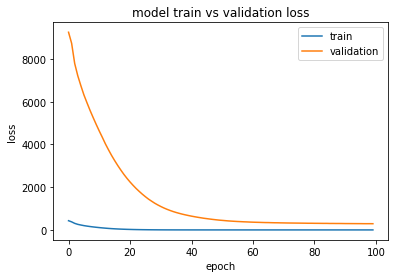

In [ ]:
history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[LSTMcp, reduce_lr])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

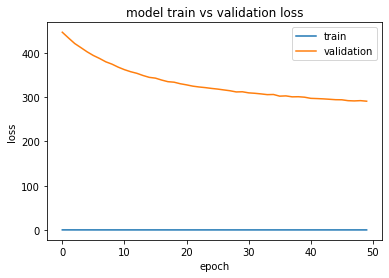

In [ ]:
plt.plot(history.history['loss'][50:])
plt.plot(history.history['val_loss'][50:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

From the above we see that the model is currently underfitted, so we increase learning rate = 0.0005 and increase number of epochs = 300. 

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((5, 1)))
LSTMModel.add(LSTM(64))
LSTMModel.add(Dense(8, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'][150:])
plt.plot(history.history['val_loss'][150:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Epoch 1/300


KeyboardInterrupt: ignored

###From above we see that there may be some underfitting and the validation loss does not seem to be able to reach the training loss, therefore there may be some under-provisioning, so we try to change model layers

Learning rate 0.001, 100 epochs

Epoch 1/100
229/229 [==============================] - 6s 13ms/step - loss: 110.1510 - mean_absolute_error: 2.7876 - val_loss: 490.5590 - val_mean_absolute_error: 17.0254
Epoch 2/100
229/229 [==============================] - 2s 7ms/step - loss: 0.3599 - mean_absolute_error: 0.2527 - val_loss: 349.3159 - val_mean_absolute_error: 13.4946
Epoch 3/100
229/229 [==============================] - 2s 7ms/step - loss: 0.2033 - mean_absolute_error: 0.1823 - val_loss: 298.0303 - val_mean_absolute_error: 11.9966
Epoch 4/100
229/229 [==============================] - 2s 7ms/step - loss: 0.2420 - mean_absolute_error: 0.2086 - val_loss: 275.7164 - val_mean_absolute_error: 11.4321
Epoch 5/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1864 - mean_absolute_error: 0.1828 - val_loss: 265.8303 - val_mean_absolute_error: 11.6438
Epoch 6/100
229/229 [==============================] - 2s 7ms/step - loss: 0.2779 - mean_absolute_error: 0.2148 - val_loss: 237.7141 - val_mean_absolute_erro

229/229 [==============================] - 7s 32ms/step - loss: 0.1621 - mean_absolute_error: 0.1694 - val_loss: 180.2381 - val_mean_absolute_error: 8.9272
Epoch 18/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1652 - mean_absolute_error: 0.1691 - val_loss: 188.2527 - val_mean_absolute_error: 9.2064
Epoch 19/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1951 - mean_absolute_error: 0.1833 - val_loss: 182.6416 - val_mean_absolute_error: 8.9593
Epoch 20/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1985 - mean_absolute_error: 0.1871 - val_loss: 202.5128 - val_mean_absolute_error: 9.6828
Epoch 21/100
229/229 [==============================] - 2s 7ms/step - loss: 0.2007 - mean_absolute_error: 0.1860 - val_loss: 220.3580 - val_mean_absolute_error: 10.3421
Epoch 22/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1856 - mean_absolute_error: 0.1863 - val_loss: 198.0356 - val_mean_absolute_error: 9.4402
Epo

229/229 [==============================] - 7s 32ms/step - loss: 0.1653 - mean_absolute_error: 0.1708 - val_loss: 173.7868 - val_mean_absolute_error: 8.7748
Epoch 30/100
229/229 [==============================] - 3s 12ms/step - loss: 0.3162 - mean_absolute_error: 0.2172 - val_loss: 236.5988 - val_mean_absolute_error: 10.7823
Epoch 31/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1838 - mean_absolute_error: 0.1754 - val_loss: 222.0721 - val_mean_absolute_error: 10.3354
Epoch 32/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1590 - mean_absolute_error: 0.1634 - val_loss: 201.4319 - val_mean_absolute_error: 9.5424
Epoch 33/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1844 - mean_absolute_error: 0.1740 - val_loss: 234.4125 - val_mean_absolute_error: 10.8884
Epoch 34/100
229/229 [==============================] - 2s 7ms/step - loss: 0.2466 - mean_absolute_error: 0.2033 - val_loss: 187.0364 - val_mean_absolute_error: 9.1266


229/229 [==============================] - 8s 37ms/step - loss: 0.2451 - mean_absolute_error: 0.1931 - val_loss: 173.0642 - val_mean_absolute_error: 8.9891
Epoch 41/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1694 - mean_absolute_error: 0.1654 - val_loss: 202.2547 - val_mean_absolute_error: 9.8776
Epoch 42/100
229/229 [==============================] - 2s 7ms/step - loss: 0.2048 - mean_absolute_error: 0.1834 - val_loss: 210.2867 - val_mean_absolute_error: 10.2204
Epoch 43/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1645 - mean_absolute_error: 0.1683 - val_loss: 184.7195 - val_mean_absolute_error: 9.2612
Epoch 44/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1878 - mean_absolute_error: 0.1779 - val_loss: 185.6545 - val_mean_absolute_error: 9.1690
Epoch 45/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1631 - mean_absolute_error: 0.1621 - val_loss: 199.5875 - val_mean_absolute_error: 9.4590
Epo

229/229 [==============================] - 7s 30ms/step - loss: 0.1366 - mean_absolute_error: 0.1473 - val_loss: 167.1168 - val_mean_absolute_error: 8.5047
Epoch 69/100
229/229 [==============================] - 1s 6ms/step - loss: 0.1543 - mean_absolute_error: 0.1579 - val_loss: 177.4393 - val_mean_absolute_error: 8.7765
Epoch 70/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1425 - mean_absolute_error: 0.1478 - val_loss: 182.5335 - val_mean_absolute_error: 8.9932
Epoch 71/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1723 - mean_absolute_error: 0.1673 - val_loss: 187.5216 - val_mean_absolute_error: 9.0938
Epoch 72/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1933 - mean_absolute_error: 0.1771 - val_loss: 187.0675 - val_mean_absolute_error: 9.2772
Epoch 73/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1851 - mean_absolute_error: 0.1685 - val_loss: 175.5013 - val_mean_absolute_error: 9.0142
Epoc

229/229 [==============================] - 8s 34ms/step - loss: 0.2016 - mean_absolute_error: 0.1822 - val_loss: 163.4497 - val_mean_absolute_error: 8.5187
Epoch 78/100
229/229 [==============================] - 1s 6ms/step - loss: 0.1824 - mean_absolute_error: 0.1695 - val_loss: 215.3884 - val_mean_absolute_error: 10.6101
Epoch 79/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1785 - mean_absolute_error: 0.1708 - val_loss: 170.3512 - val_mean_absolute_error: 8.6803
Epoch 80/100
229/229 [==============================] - 2s 9ms/step - loss: 0.1713 - mean_absolute_error: 0.1654 - val_loss: 178.8207 - val_mean_absolute_error: 8.8640
Epoch 81/100
225/229 [============================>.] - ETA: 0s - loss: 0.1694 - mean_absolute_error: 0.1587

229/229 [==============================] - 7s 32ms/step - loss: 0.1682 - mean_absolute_error: 0.1583 - val_loss: 153.2414 - val_mean_absolute_error: 8.1592
Epoch 82/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1455 - mean_absolute_error: 0.1528 - val_loss: 172.5547 - val_mean_absolute_error: 8.7353
Epoch 83/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1545 - mean_absolute_error: 0.1590 - val_loss: 193.5260 - val_mean_absolute_error: 9.8162
Epoch 84/100
229/229 [==============================] - 1s 6ms/step - loss: 0.1918 - mean_absolute_error: 0.1739 - val_loss: 177.5363 - val_mean_absolute_error: 9.1710
Epoch 85/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1447 - mean_absolute_error: 0.1510 - val_loss: 168.5926 - val_mean_absolute_error: 8.8047
Epoch 86/100
229/229 [==============================] - 1s 6ms/step - loss: 0.1864 - mean_absolute_error: 0.1652 - val_loss: 156.2996 - val_mean_absolute_error: 8.5326
Epoc

229/229 [==============================] - 7s 31ms/step - loss: 0.1472 - mean_absolute_error: 0.1479 - val_loss: 151.6889 - val_mean_absolute_error: 8.1046
Epoch 89/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1540 - mean_absolute_error: 0.1547 - val_loss: 163.4391 - val_mean_absolute_error: 8.4847
Epoch 90/100
229/229 [==============================] - 2s 7ms/step - loss: 0.2122 - mean_absolute_error: 0.1858 - val_loss: 171.0408 - val_mean_absolute_error: 8.8987
Epoch 91/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1499 - mean_absolute_error: 0.1561 - val_loss: 169.9575 - val_mean_absolute_error: 9.2420
Epoch 92/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1715 - mean_absolute_error: 0.1680 - val_loss: 184.9276 - val_mean_absolute_error: 9.1828
Epoch 93/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1600 - mean_absolute_error: 0.1586 - val_loss: 158.3941 - val_mean_absolute_error: 8.2940
Epoc

229/229 [==============================] - 8s 35ms/step - loss: 0.1548 - mean_absolute_error: 0.1562 - val_loss: 147.7906 - val_mean_absolute_error: 8.0186
Epoch 97/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1413 - mean_absolute_error: 0.1481 - val_loss: 160.5121 - val_mean_absolute_error: 8.4493
Epoch 98/100
223/229 [============================>.] - ETA: 0s - loss: 0.1491 - mean_absolute_error: 0.1497

229/229 [==============================] - 7s 31ms/step - loss: 0.1479 - mean_absolute_error: 0.1494 - val_loss: 134.6017 - val_mean_absolute_error: 7.5184
Epoch 99/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1405 - mean_absolute_error: 0.1501 - val_loss: 146.8231 - val_mean_absolute_error: 7.8918
Epoch 100/100
229/229 [==============================] - 2s 7ms/step - loss: 0.1421 - mean_absolute_error: 0.1482 - val_loss: 166.8144 - val_mean_absolute_error: 8.4048


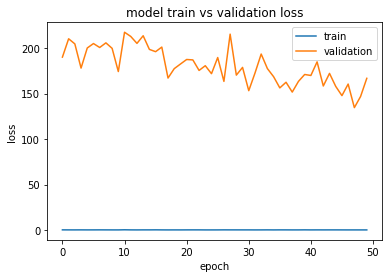

In [ ]:
LSTMModel = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

LSTMModel.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[LSTMcp])
plt.plot(history.history['loss'][50:])
plt.plot(history.history['val_loss'][50:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Try increasing epochs = 300

Epoch 1/300
229/229 [==============================] - 4s 8ms/step - loss: 114.2841 - mean_absolute_error: 2.9000 - val_loss: 597.9888 - val_mean_absolute_error: 18.6852
Epoch 2/300
229/229 [==============================] - 1s 6ms/step - loss: 0.3204 - mean_absolute_error: 0.2180 - val_loss: 379.5737 - val_mean_absolute_error: 13.7643
Epoch 3/300
229/229 [==============================] - 1s 5ms/step - loss: 0.2086 - mean_absolute_error: 0.1980 - val_loss: 318.1939 - val_mean_absolute_error: 12.5439
Epoch 4/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1939 - mean_absolute_error: 0.1842 - val_loss: 308.5006 - val_mean_absolute_error: 12.2602
Epoch 5/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1774 - mean_absolute_error: 0.1826 - val_loss: 299.5877 - val_mean_absolute_error: 11.8784
Epoch 6/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1795 - mean_absolute_error: 0.1886 - val_loss: 271.1181 - val_mean_absolute_error

229/229 [==============================] - 7s 32ms/step - loss: 0.1555 - mean_absolute_error: 0.1553 - val_loss: 118.3442 - val_mean_absolute_error: 7.0520
Epoch 154/300
229/229 [==============================] - 2s 8ms/step - loss: 0.1586 - mean_absolute_error: 0.1569 - val_loss: 158.8414 - val_mean_absolute_error: 8.4930
Epoch 155/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1657 - mean_absolute_error: 0.1594 - val_loss: 157.8093 - val_mean_absolute_error: 8.4568
Epoch 156/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1423 - mean_absolute_error: 0.1447 - val_loss: 147.8254 - val_mean_absolute_error: 8.1766
Epoch 157/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1405 - mean_absolute_error: 0.1486 - val_loss: 141.9322 - val_mean_absolute_error: 8.1710
Epoch 158/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1424 - mean_absolute_error: 0.1443 - val_loss: 154.6178 - val_mean_absolute_error: 8.1563

229/229 [==============================] - 7s 32ms/step - loss: 0.1566 - mean_absolute_error: 0.1589 - val_loss: 114.5535 - val_mean_absolute_error: 6.9396
Epoch 201/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1404 - mean_absolute_error: 0.1460 - val_loss: 144.6354 - val_mean_absolute_error: 8.1127
Epoch 202/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1527 - mean_absolute_error: 0.1534 - val_loss: 128.5201 - val_mean_absolute_error: 7.3527
Epoch 203/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1485 - mean_absolute_error: 0.1478 - val_loss: 158.8773 - val_mean_absolute_error: 8.7267
Epoch 204/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1442 - mean_absolute_error: 0.1480 - val_loss: 135.4191 - val_mean_absolute_error: 7.6414
Epoch 205/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1466 - mean_absolute_error: 0.1497 - val_loss: 127.5830 - val_mean_absolute_error: 7.4738

229/229 [==============================] - 7s 29ms/step - loss: 0.1440 - mean_absolute_error: 0.1477 - val_loss: 108.2234 - val_mean_absolute_error: 6.6792
Epoch 260/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1308 - mean_absolute_error: 0.1386 - val_loss: 108.7695 - val_mean_absolute_error: 6.7651
Epoch 261/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1438 - mean_absolute_error: 0.1471 - val_loss: 125.0325 - val_mean_absolute_error: 7.2873
Epoch 262/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1312 - mean_absolute_error: 0.1409 - val_loss: 130.2830 - val_mean_absolute_error: 7.5421
Epoch 263/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1537 - mean_absolute_error: 0.1553 - val_loss: 123.0078 - val_mean_absolute_error: 7.1443
Epoch 264/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1404 - mean_absolute_error: 0.1468 - val_loss: 125.1843 - val_mean_absolute_error: 7.2854

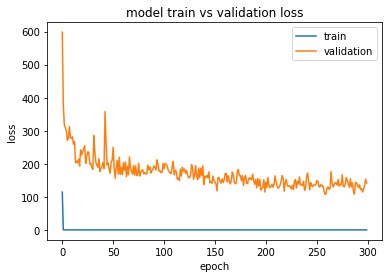

In [ ]:
LSTMModel = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

LSTMModel.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Try increasing to 500 epochs

Epoch 1/500
229/229 [==============================] - 4s 8ms/step - loss: 116.8906 - mean_absolute_error: 2.9307 - val_loss: 556.5035 - val_mean_absolute_error: 17.9469
Epoch 2/500
229/229 [==============================] - 1s 5ms/step - loss: 0.3394 - mean_absolute_error: 0.2429 - val_loss: 375.0191 - val_mean_absolute_error: 13.8882
Epoch 3/500
229/229 [==============================] - 1s 5ms/step - loss: 0.2259 - mean_absolute_error: 0.2090 - val_loss: 322.0578 - val_mean_absolute_error: 12.6295
Epoch 4/500
229/229 [==============================] - 1s 5ms/step - loss: 0.2134 - mean_absolute_error: 0.2109 - val_loss: 296.1310 - val_mean_absolute_error: 12.1351
Epoch 5/500
229/229 [==============================] - 1s 6ms/step - loss: 0.2076 - mean_absolute_error: 0.2065 - val_loss: 291.2521 - val_mean_absolute_error: 11.9311
Epoch 6/500
229/229 [==============================] - 1s 6ms/step - loss: 0.2358 - mean_absolute_error: 0.2167 - val_loss: 291.6844 - val_mean_absolute_error

229/229 [==============================] - 6s 26ms/step - loss: 0.1616 - mean_absolute_error: 0.1596 - val_loss: 103.7061 - val_mean_absolute_error: 6.8624
Epoch 102/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1414 - mean_absolute_error: 0.1523 - val_loss: 111.4102 - val_mean_absolute_error: 6.9615
Epoch 103/500
229/229 [==============================] - 1s 5ms/step - loss: 0.1603 - mean_absolute_error: 0.1574 - val_loss: 106.3645 - val_mean_absolute_error: 6.8582
Epoch 104/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1402 - mean_absolute_error: 0.1480 - val_loss: 128.4681 - val_mean_absolute_error: 7.5133
Epoch 105/500
222/229 [============================>.] - ETA: 0s - loss: 0.1298 - mean_absolute_error: 0.1434

229/229 [==============================] - 7s 29ms/step - loss: 0.1366 - mean_absolute_error: 0.1448 - val_loss: 103.2844 - val_mean_absolute_error: 7.0118
Epoch 106/500
229/229 [==============================] - 1s 6ms/step - loss: 0.2066 - mean_absolute_error: 0.1809 - val_loss: 154.0029 - val_mean_absolute_error: 8.1099
Epoch 107/500
229/229 [==============================] - 1s 5ms/step - loss: 0.1430 - mean_absolute_error: 0.1469 - val_loss: 130.8968 - val_mean_absolute_error: 7.6083
Epoch 108/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1694 - mean_absolute_error: 0.1589 - val_loss: 151.0190 - val_mean_absolute_error: 8.0323
Epoch 109/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1715 - mean_absolute_error: 0.1638 - val_loss: 112.0983 - val_mean_absolute_error: 7.1212
Epoch 110/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1600 - mean_absolute_error: 0.1533 - val_loss: 129.8391 - val_mean_absolute_error: 7.3605

229/229 [==============================] - 6s 27ms/step - loss: 0.1266 - mean_absolute_error: 0.1370 - val_loss: 100.3080 - val_mean_absolute_error: 6.3737
Epoch 132/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1550 - mean_absolute_error: 0.1585 - val_loss: 144.3762 - val_mean_absolute_error: 7.8418
Epoch 133/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1802 - mean_absolute_error: 0.1651 - val_loss: 138.7596 - val_mean_absolute_error: 7.7123
Epoch 134/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1362 - mean_absolute_error: 0.1408 - val_loss: 127.4854 - val_mean_absolute_error: 7.3722
Epoch 135/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1435 - mean_absolute_error: 0.1477 - val_loss: 129.1875 - val_mean_absolute_error: 7.4055
Epoch 136/500
229/229 [==============================] - 1s 6ms/step - loss: 0.2031 - mean_absolute_error: 0.1782 - val_loss: 175.6734 - val_mean_absolute_error: 9.2449

229/229 [==============================] - 7s 29ms/step - loss: 0.1318 - mean_absolute_error: 0.1413 - val_loss: 97.7882 - val_mean_absolute_error: 6.3687
Epoch 154/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1521 - mean_absolute_error: 0.1547 - val_loss: 126.5662 - val_mean_absolute_error: 7.2696
Epoch 155/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1295 - mean_absolute_error: 0.1417 - val_loss: 120.5326 - val_mean_absolute_error: 7.2692
Epoch 156/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1389 - mean_absolute_error: 0.1454 - val_loss: 121.5913 - val_mean_absolute_error: 7.1236
Epoch 157/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1761 - mean_absolute_error: 0.1618 - val_loss: 106.8825 - val_mean_absolute_error: 6.5752
Epoch 158/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1411 - mean_absolute_error: 0.1469 - val_loss: 123.0389 - val_mean_absolute_error: 7.1920


229/229 [==============================] - 6s 27ms/step - loss: 0.1378 - mean_absolute_error: 0.1449 - val_loss: 95.7980 - val_mean_absolute_error: 6.3811
Epoch 218/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1393 - mean_absolute_error: 0.1468 - val_loss: 118.6243 - val_mean_absolute_error: 7.1479
Epoch 219/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1555 - mean_absolute_error: 0.1548 - val_loss: 107.4332 - val_mean_absolute_error: 6.7223
Epoch 220/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1651 - mean_absolute_error: 0.1616 - val_loss: 109.8817 - val_mean_absolute_error: 6.9330
Epoch 221/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1358 - mean_absolute_error: 0.1467 - val_loss: 111.5213 - val_mean_absolute_error: 6.7809
Epoch 222/500
229/229 [==============================] - 1s 5ms/step - loss: 0.1441 - mean_absolute_error: 0.1484 - val_loss: 107.0880 - val_mean_absolute_error: 6.6533


229/229 [==============================] - 7s 29ms/step - loss: 0.1560 - mean_absolute_error: 0.1526 - val_loss: 95.3933 - val_mean_absolute_error: 6.7714
Epoch 250/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1676 - mean_absolute_error: 0.1571 - val_loss: 124.4446 - val_mean_absolute_error: 7.3926
Epoch 251/500
229/229 [==============================] - 1s 5ms/step - loss: 0.1460 - mean_absolute_error: 0.1454 - val_loss: 112.8242 - val_mean_absolute_error: 6.8966
Epoch 252/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1319 - mean_absolute_error: 0.1423 - val_loss: 110.7933 - val_mean_absolute_error: 6.7840
Epoch 253/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1426 - mean_absolute_error: 0.1481 - val_loss: 102.2796 - val_mean_absolute_error: 6.4634
Epoch 254/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1317 - mean_absolute_error: 0.1415 - val_loss: 109.8268 - val_mean_absolute_error: 6.8312


229/229 [==============================] - 6s 27ms/step - loss: 0.1435 - mean_absolute_error: 0.1483 - val_loss: 94.9968 - val_mean_absolute_error: 6.2776
Epoch 278/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1640 - mean_absolute_error: 0.1554 - val_loss: 124.8567 - val_mean_absolute_error: 7.4737
Epoch 279/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1525 - mean_absolute_error: 0.1509 - val_loss: 113.6191 - val_mean_absolute_error: 6.9494
Epoch 280/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1400 - mean_absolute_error: 0.1465 - val_loss: 106.4873 - val_mean_absolute_error: 6.9512
Epoch 281/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1937 - mean_absolute_error: 0.1683 - val_loss: 121.6469 - val_mean_absolute_error: 7.1347
Epoch 282/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1248 - mean_absolute_error: 0.1402 - val_loss: 123.7876 - val_mean_absolute_error: 7.1868


229/229 [==============================] - 7s 30ms/step - loss: 0.1585 - mean_absolute_error: 0.1539 - val_loss: 94.0380 - val_mean_absolute_error: 6.3355
Epoch 454/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1313 - mean_absolute_error: 0.1377 - val_loss: 103.0558 - val_mean_absolute_error: 6.6036
Epoch 455/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1400 - mean_absolute_error: 0.1472 - val_loss: 135.7715 - val_mean_absolute_error: 7.7473
Epoch 456/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1386 - mean_absolute_error: 0.1450 - val_loss: 143.6192 - val_mean_absolute_error: 8.1110
Epoch 457/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1348 - mean_absolute_error: 0.1428 - val_loss: 116.9614 - val_mean_absolute_error: 7.0263
Epoch 458/500
229/229 [==============================] - 1s 6ms/step - loss: 0.1432 - mean_absolute_error: 0.1451 - val_loss: 145.7988 - val_mean_absolute_error: 8.3713


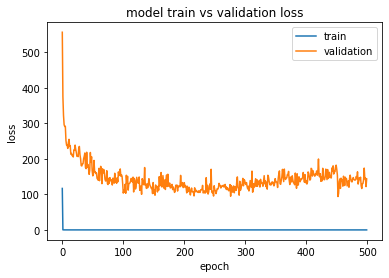

In [ ]:
LSTMModel = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

LSTMModel.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=500, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Try increasing to 700 epochs

Epoch 1/700
229/229 [==============================] - 6s 13ms/step - loss: 121.2244 - mean_absolute_error: 3.1703 - val_loss: 548.8738 - val_mean_absolute_error: 17.6308
Epoch 2/700
229/229 [==============================] - 1s 6ms/step - loss: 0.3515 - mean_absolute_error: 0.2374 - val_loss: 435.8736 - val_mean_absolute_error: 15.7225
Epoch 3/700
229/229 [==============================] - 1s 6ms/step - loss: 0.2553 - mean_absolute_error: 0.2200 - val_loss: 349.7088 - val_mean_absolute_error: 13.3145
Epoch 4/700
229/229 [==============================] - 1s 6ms/step - loss: 0.2002 - mean_absolute_error: 0.1953 - val_loss: 301.6935 - val_mean_absolute_error: 12.0506
Epoch 5/700
229/229 [==============================] - 1s 6ms/step - loss: 0.2356 - mean_absolute_error: 0.2114 - val_loss: 307.2713 - val_mean_absolute_error: 12.2407
Epoch 6/700
229/229 [==============================] - 1s 6ms/step - loss: 0.2251 - mean_absolute_error: 0.1934 - val_loss: 300.7352 - val_mean_absolute_erro

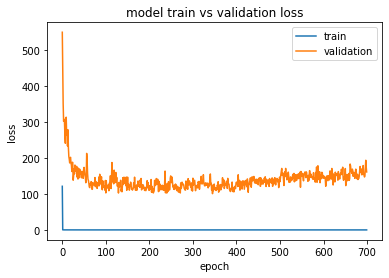

In [ ]:
LSTMModel = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

LSTMModel.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=700, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Try increasing to 1000 epochs

Epoch 1/1000
229/229 [==============================] - 4s 8ms/step - loss: 92.1762 - mean_absolute_error: 2.4737 - val_loss: 413.6526 - val_mean_absolute_error: 14.6507
Epoch 2/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.3825 - mean_absolute_error: 0.2603 - val_loss: 338.1107 - val_mean_absolute_error: 13.1150
Epoch 3/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.2149 - mean_absolute_error: 0.2008 - val_loss: 300.2422 - val_mean_absolute_error: 12.1211
Epoch 4/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1956 - mean_absolute_error: 0.1880 - val_loss: 264.9630 - val_mean_absolute_error: 11.2889
Epoch 5/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.2441 - mean_absolute_error: 0.2195 - val_loss: 258.8440 - val_mean_absolute_error: 10.9685
Epoch 6/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1693 - mean_absolute_error: 0.1756 - val_loss: 252.7182 - val_mean_absolute_

229/229 [==============================] - 7s 29ms/step - loss: 0.1796 - mean_absolute_error: 0.1691 - val_loss: 92.2081 - val_mean_absolute_error: 6.6712
Epoch 168/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1726 - mean_absolute_error: 0.1581 - val_loss: 122.5013 - val_mean_absolute_error: 7.1859
Epoch 169/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1424 - mean_absolute_error: 0.1489 - val_loss: 118.2654 - val_mean_absolute_error: 7.1168
Epoch 170/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1463 - mean_absolute_error: 0.1463 - val_loss: 121.0682 - val_mean_absolute_error: 7.3749
Epoch 171/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.1467 - mean_absolute_error: 0.1506 - val_loss: 125.6535 - val_mean_absolute_error: 7.4411
Epoch 172/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1536 - mean_absolute_error: 0.1520 - val_loss: 128.1624 - val_mean_absolute_error: 7.

229/229 [==============================] - 7s 31ms/step - loss: 0.1424 - mean_absolute_error: 0.1508 - val_loss: 88.7783 - val_mean_absolute_error: 6.0646
Epoch 201/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.1662 - mean_absolute_error: 0.1596 - val_loss: 112.4323 - val_mean_absolute_error: 6.9368
Epoch 202/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.1778 - mean_absolute_error: 0.1638 - val_loss: 94.6105 - val_mean_absolute_error: 6.3397
Epoch 203/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1551 - mean_absolute_error: 0.1539 - val_loss: 99.5357 - val_mean_absolute_error: 6.4444
Epoch 204/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1375 - mean_absolute_error: 0.1438 - val_loss: 111.6833 - val_mean_absolute_error: 6.9659
Epoch 205/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1409 - mean_absolute_error: 0.1404 - val_loss: 97.5834 - val_mean_absolute_error: 6.353

229/229 [==============================] - 6s 27ms/step - loss: 0.1591 - mean_absolute_error: 0.1548 - val_loss: 84.7100 - val_mean_absolute_error: 6.1267
Epoch 222/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1541 - mean_absolute_error: 0.1544 - val_loss: 93.6891 - val_mean_absolute_error: 6.4762
Epoch 223/1000
227/229 [============================>.] - ETA: 0s - loss: 0.1376 - mean_absolute_error: 0.1475

229/229 [==============================] - 7s 30ms/step - loss: 0.1375 - mean_absolute_error: 0.1474 - val_loss: 80.6030 - val_mean_absolute_error: 5.7679
Epoch 224/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1502 - mean_absolute_error: 0.1540 - val_loss: 108.8740 - val_mean_absolute_error: 7.1594
Epoch 225/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.1698 - mean_absolute_error: 0.1614 - val_loss: 92.5654 - val_mean_absolute_error: 6.2211
Epoch 226/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.1423 - mean_absolute_error: 0.1466 - val_loss: 88.5430 - val_mean_absolute_error: 6.2012
Epoch 227/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1278 - mean_absolute_error: 0.1448 - val_loss: 81.8109 - val_mean_absolute_error: 6.0359
Epoch 228/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1520 - mean_absolute_error: 0.1510 - val_loss: 83.2953 - val_mean_absolute_error: 5.8757

229/229 [==============================] - 6s 27ms/step - loss: 0.1585 - mean_absolute_error: 0.1555 - val_loss: 74.1919 - val_mean_absolute_error: 5.4973
Epoch 230/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1324 - mean_absolute_error: 0.1409 - val_loss: 81.1291 - val_mean_absolute_error: 5.9407
Epoch 231/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1987 - mean_absolute_error: 0.1749 - val_loss: 87.0027 - val_mean_absolute_error: 6.1918
Epoch 232/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1395 - mean_absolute_error: 0.1456 - val_loss: 111.4295 - val_mean_absolute_error: 7.6490
Epoch 233/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1667 - mean_absolute_error: 0.1585 - val_loss: 77.6938 - val_mean_absolute_error: 5.6666
Epoch 234/1000
228/229 [============================>.] - ETA: 0s - loss: 0.1431 - mean_absolute_error: 0.1443

229/229 [==============================] - 7s 29ms/step - loss: 0.1430 - mean_absolute_error: 0.1443 - val_loss: 56.0549 - val_mean_absolute_error: 4.8879
Epoch 235/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1406 - mean_absolute_error: 0.1507 - val_loss: 85.3744 - val_mean_absolute_error: 6.0030
Epoch 236/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1485 - mean_absolute_error: 0.1545 - val_loss: 91.7043 - val_mean_absolute_error: 6.2611
Epoch 237/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1549 - mean_absolute_error: 0.1531 - val_loss: 130.8371 - val_mean_absolute_error: 8.0025
Epoch 238/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1342 - mean_absolute_error: 0.1428 - val_loss: 88.1281 - val_mean_absolute_error: 6.0867
Epoch 239/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.1635 - mean_absolute_error: 0.1578 - val_loss: 80.0807 - val_mean_absolute_error: 5.9411

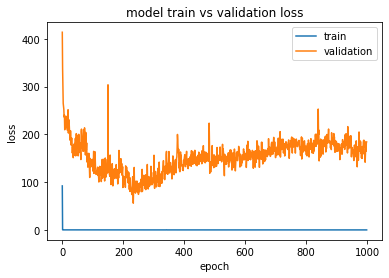

In [ ]:
LSTMModel = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

LSTMModel.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Removing the 2 dense layers

Epoch 1/300
225/229 [============================>.] - ETA: 0s - loss: 266.0209 - mean_absolute_error: 6.1862

229/229 [==============================] - 11s 34ms/step - loss: 265.5797 - mean_absolute_error: 6.1612 - val_loss: 5855.7192 - val_mean_absolute_error: 73.8656
Epoch 2/300
221/229 [===========================>..] - ETA: 0s - loss: 124.6688 - mean_absolute_error: 3.4890

229/229 [==============================] - 6s 25ms/step - loss: 123.1341 - mean_absolute_error: 3.4533 - val_loss: 4395.3555 - val_mean_absolute_error: 63.2136
Epoch 3/300
225/229 [============================>.] - ETA: 0s - loss: 69.8373 - mean_absolute_error: 2.3714

229/229 [==============================] - 6s 27ms/step - loss: 69.3603 - mean_absolute_error: 2.3614 - val_loss: 3383.4851 - val_mean_absolute_error: 54.6273
Epoch 4/300
222/229 [============================>.] - ETA: 0s - loss: 41.4023 - mean_absolute_error: 1.6685

229/229 [==============================] - 6s 26ms/step - loss: 41.4690 - mean_absolute_error: 1.6715 - val_loss: 2726.5100 - val_mean_absolute_error: 48.2411
Epoch 5/300
219/229 [===========================>..] - ETA: 0s - loss: 26.1182 - mean_absolute_error: 1.2289

229/229 [==============================] - 6s 25ms/step - loss: 26.0436 - mean_absolute_error: 1.2250 - val_loss: 2244.3645 - val_mean_absolute_error: 42.9545
Epoch 6/300
226/229 [============================>.] - ETA: 0s - loss: 16.9625 - mean_absolute_error: 0.9348

229/229 [==============================] - 6s 25ms/step - loss: 17.0014 - mean_absolute_error: 0.9370 - val_loss: 1889.5002 - val_mean_absolute_error: 38.6040
Epoch 7/300
222/229 [============================>.] - ETA: 0s - loss: 11.4385 - mean_absolute_error: 0.7368

229/229 [==============================] - 6s 27ms/step - loss: 11.4042 - mean_absolute_error: 0.7335 - val_loss: 1616.1768 - val_mean_absolute_error: 34.8881
Epoch 8/300
221/229 [===========================>..] - ETA: 0s - loss: 7.7824 - mean_absolute_error: 0.6010

229/229 [==============================] - 6s 26ms/step - loss: 7.7761 - mean_absolute_error: 0.6057 - val_loss: 1403.2445 - val_mean_absolute_error: 31.7012
Epoch 9/300
225/229 [============================>.] - ETA: 0s - loss: 5.3118 - mean_absolute_error: 0.4945

229/229 [==============================] - 6s 25ms/step - loss: 5.3013 - mean_absolute_error: 0.4948 - val_loss: 1233.7383 - val_mean_absolute_error: 28.9938
Epoch 10/300
222/229 [============================>.] - ETA: 0s - loss: 3.7355 - mean_absolute_error: 0.4266

229/229 [==============================] - 6s 24ms/step - loss: 3.6376 - mean_absolute_error: 0.4189 - val_loss: 1092.0446 - val_mean_absolute_error: 26.6284
Epoch 11/300
221/229 [===========================>..] - ETA: 0s - loss: 2.3931 - mean_absolute_error: 0.3500

229/229 [==============================] - 6s 27ms/step - loss: 2.5668 - mean_absolute_error: 0.3606 - val_loss: 988.9783 - val_mean_absolute_error: 24.8946
Epoch 12/300
222/229 [============================>.] - ETA: 0s - loss: 1.8501 - mean_absolute_error: 0.3023

229/229 [==============================] - 6s 27ms/step - loss: 1.8263 - mean_absolute_error: 0.3001 - val_loss: 899.6329 - val_mean_absolute_error: 23.4667
Epoch 13/300
228/229 [============================>.] - ETA: 0s - loss: 1.3621 - mean_absolute_error: 0.2767

229/229 [==============================] - 6s 24ms/step - loss: 1.3615 - mean_absolute_error: 0.2767 - val_loss: 830.8970 - val_mean_absolute_error: 22.4603
Epoch 14/300
224/229 [============================>.] - ETA: 0s - loss: 1.0577 - mean_absolute_error: 0.2580

229/229 [==============================] - 6s 25ms/step - loss: 1.0835 - mean_absolute_error: 0.2603 - val_loss: 771.5767 - val_mean_absolute_error: 21.5193
Epoch 15/300
225/229 [============================>.] - ETA: 0s - loss: 0.8328 - mean_absolute_error: 0.2348

229/229 [==============================] - 6s 27ms/step - loss: 0.8236 - mean_absolute_error: 0.2336 - val_loss: 720.9189 - val_mean_absolute_error: 20.5046
Epoch 16/300
223/229 [============================>.] - ETA: 0s - loss: 0.6725 - mean_absolute_error: 0.2261

229/229 [==============================] - 6s 25ms/step - loss: 0.6750 - mean_absolute_error: 0.2270 - val_loss: 677.5272 - val_mean_absolute_error: 19.7110
Epoch 17/300
227/229 [============================>.] - ETA: 0s - loss: 0.5611 - mean_absolute_error: 0.2156

229/229 [==============================] - 6s 26ms/step - loss: 0.5603 - mean_absolute_error: 0.2157 - val_loss: 641.3884 - val_mean_absolute_error: 19.2372
Epoch 18/300
225/229 [============================>.] - ETA: 0s - loss: 0.4697 - mean_absolute_error: 0.2018

229/229 [==============================] - 6s 26ms/step - loss: 0.4642 - mean_absolute_error: 0.2008 - val_loss: 604.2214 - val_mean_absolute_error: 18.3641
Epoch 19/300
222/229 [============================>.] - ETA: 0s - loss: 0.3765 - mean_absolute_error: 0.1916

229/229 [==============================] - 6s 25ms/step - loss: 0.3852 - mean_absolute_error: 0.1929 - val_loss: 574.7738 - val_mean_absolute_error: 17.8117
Epoch 20/300
229/229 [==============================] - 1s 5ms/step - loss: 0.3221 - mean_absolute_error: 0.1778 - val_loss: 627.5065 - val_mean_absolute_error: 19.0174
Epoch 21/300
227/229 [============================>.] - ETA: 0s - loss: 0.3578 - mean_absolute_error: 0.1855

229/229 [==============================] - 6s 25ms/step - loss: 0.3587 - mean_absolute_error: 0.1858 - val_loss: 513.5154 - val_mean_absolute_error: 16.6462
Epoch 22/300
222/229 [============================>.] - ETA: 0s - loss: 0.2258 - mean_absolute_error: 0.1646

229/229 [==============================] - 6s 27ms/step - loss: 0.2235 - mean_absolute_error: 0.1639 - val_loss: 489.0165 - val_mean_absolute_error: 16.1056
Epoch 23/300
225/229 [============================>.] - ETA: 0s - loss: 0.2500 - mean_absolute_error: 0.1921

229/229 [==============================] - 6s 27ms/step - loss: 0.2477 - mean_absolute_error: 0.1917 - val_loss: 470.4281 - val_mean_absolute_error: 15.8185
Epoch 24/300
227/229 [============================>.] - ETA: 0s - loss: 0.1997 - mean_absolute_error: 0.1646

229/229 [==============================] - 6s 25ms/step - loss: 0.1991 - mean_absolute_error: 0.1645 - val_loss: 454.6161 - val_mean_absolute_error: 15.4089
Epoch 25/300
229/229 [==============================] - ETA: 0s - loss: 0.1925 - mean_absolute_error: 0.1701

229/229 [==============================] - 6s 24ms/step - loss: 0.1925 - mean_absolute_error: 0.1701 - val_loss: 439.4369 - val_mean_absolute_error: 15.0550
Epoch 26/300
228/229 [============================>.] - ETA: 0s - loss: 0.1894 - mean_absolute_error: 0.1629

229/229 [==============================] - 6s 27ms/step - loss: 0.1897 - mean_absolute_error: 0.1632 - val_loss: 421.1774 - val_mean_absolute_error: 14.6141
Epoch 27/300
227/229 [============================>.] - ETA: 0s - loss: 0.2044 - mean_absolute_error: 0.1801

229/229 [==============================] - 6s 27ms/step - loss: 0.2037 - mean_absolute_error: 0.1798 - val_loss: 408.6506 - val_mean_absolute_error: 14.4101
Epoch 28/300
228/229 [============================>.] - ETA: 0s - loss: 0.1637 - mean_absolute_error: 0.1570

229/229 [==============================] - 6s 25ms/step - loss: 0.1637 - mean_absolute_error: 0.1570 - val_loss: 399.2059 - val_mean_absolute_error: 14.1942
Epoch 29/300
224/229 [============================>.] - ETA: 0s - loss: 0.1641 - mean_absolute_error: 0.1602

229/229 [==============================] - 6s 25ms/step - loss: 0.1638 - mean_absolute_error: 0.1604 - val_loss: 389.8812 - val_mean_absolute_error: 13.8965
Epoch 30/300
224/229 [============================>.] - ETA: 0s - loss: 0.1518 - mean_absolute_error: 0.1534

229/229 [==============================] - 6s 27ms/step - loss: 0.1539 - mean_absolute_error: 0.1551 - val_loss: 384.2755 - val_mean_absolute_error: 13.8973
Epoch 31/300
223/229 [============================>.] - ETA: 0s - loss: 0.1686 - mean_absolute_error: 0.1725

229/229 [==============================] - 6s 26ms/step - loss: 0.1738 - mean_absolute_error: 0.1730 - val_loss: 377.4770 - val_mean_absolute_error: 13.7126
Epoch 32/300
220/229 [===========================>..] - ETA: 0s - loss: 0.1511 - mean_absolute_error: 0.1600

229/229 [==============================] - 6s 25ms/step - loss: 0.1518 - mean_absolute_error: 0.1599 - val_loss: 372.5140 - val_mean_absolute_error: 13.7524
Epoch 33/300
225/229 [============================>.] - ETA: 0s - loss: 0.1453 - mean_absolute_error: 0.1559

229/229 [==============================] - 6s 24ms/step - loss: 0.1490 - mean_absolute_error: 0.1583 - val_loss: 362.8721 - val_mean_absolute_error: 13.5490
Epoch 34/300
226/229 [============================>.] - ETA: 0s - loss: 0.1554 - mean_absolute_error: 0.1622

229/229 [==============================] - 6s 27ms/step - loss: 0.1547 - mean_absolute_error: 0.1620 - val_loss: 356.5507 - val_mean_absolute_error: 13.1965
Epoch 35/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1451 - mean_absolute_error: 0.1475 - val_loss: 381.1061 - val_mean_absolute_error: 13.7362
Epoch 36/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1536 - mean_absolute_error: 0.1571 - val_loss: 361.5525 - val_mean_absolute_error: 13.7276
Epoch 37/300
223/229 [============================>.] - ETA: 0s - loss: 0.1622 - mean_absolute_error: 0.1608

229/229 [==============================] - 6s 26ms/step - loss: 0.1626 - mean_absolute_error: 0.1611 - val_loss: 340.6922 - val_mean_absolute_error: 12.9029
Epoch 38/300
221/229 [===========================>..] - ETA: 0s - loss: 0.1546 - mean_absolute_error: 0.1538

229/229 [==============================] - 6s 25ms/step - loss: 0.1542 - mean_absolute_error: 0.1547 - val_loss: 330.4355 - val_mean_absolute_error: 12.6104
Epoch 39/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1523 - mean_absolute_error: 0.1556 - val_loss: 389.9186 - val_mean_absolute_error: 13.9552
Epoch 40/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1480 - mean_absolute_error: 0.1503 - val_loss: 344.3344 - val_mean_absolute_error: 12.9104
Epoch 41/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1345 - mean_absolute_error: 0.1450 - val_loss: 335.7130 - val_mean_absolute_error: 12.6509
Epoch 42/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1462 - mean_absolute_error: 0.1502 - val_loss: 333.8961 - val_mean_absolute_error: 12.6486
Epoch 43/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1487 - mean_absolute_error: 0.1499 - val_loss: 335.8226 - val_mean_absolute_error: 12.903

229/229 [==============================] - 6s 25ms/step - loss: 0.1434 - mean_absolute_error: 0.1510 - val_loss: 327.6555 - val_mean_absolute_error: 12.5230
Epoch 46/300
228/229 [============================>.] - ETA: 0s - loss: 0.1338 - mean_absolute_error: 0.1408

229/229 [==============================] - 6s 27ms/step - loss: 0.1337 - mean_absolute_error: 0.1408 - val_loss: 317.5148 - val_mean_absolute_error: 12.2343
Epoch 47/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1401 - mean_absolute_error: 0.1518 - val_loss: 386.4453 - val_mean_absolute_error: 13.9568
Epoch 48/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1443 - mean_absolute_error: 0.1467 - val_loss: 369.0100 - val_mean_absolute_error: 13.5230
Epoch 49/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1414 - mean_absolute_error: 0.1452 - val_loss: 371.8398 - val_mean_absolute_error: 13.6206
Epoch 50/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1645 - mean_absolute_error: 0.1618 - val_loss: 357.8980 - val_mean_absolute_error: 13.3215
Epoch 51/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1500 - mean_absolute_error: 0.1543 - val_loss: 351.1995 - val_mean_absolute_error: 13.158

229/229 [==============================] - 6s 26ms/step - loss: 0.1625 - mean_absolute_error: 0.1578 - val_loss: 315.2697 - val_mean_absolute_error: 12.3794
Epoch 54/300
223/229 [============================>.] - ETA: 0s - loss: 0.1452 - mean_absolute_error: 0.1473

229/229 [==============================] - 7s 29ms/step - loss: 0.1453 - mean_absolute_error: 0.1476 - val_loss: 308.5251 - val_mean_absolute_error: 12.1760
Epoch 55/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1394 - mean_absolute_error: 0.1489 - val_loss: 355.3324 - val_mean_absolute_error: 13.2392
Epoch 56/300
221/229 [===========================>..] - ETA: 0s - loss: 0.1373 - mean_absolute_error: 0.1443

229/229 [==============================] - 6s 27ms/step - loss: 0.1362 - mean_absolute_error: 0.1437 - val_loss: 293.6991 - val_mean_absolute_error: 11.8807
Epoch 57/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1462 - mean_absolute_error: 0.1520 - val_loss: 302.2329 - val_mean_absolute_error: 12.0397
Epoch 58/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1389 - mean_absolute_error: 0.1452 - val_loss: 303.0103 - val_mean_absolute_error: 11.9139
Epoch 59/300
224/229 [============================>.] - ETA: 0s - loss: 0.1530 - mean_absolute_error: 0.1543

229/229 [==============================] - 6s 25ms/step - loss: 0.1511 - mean_absolute_error: 0.1534 - val_loss: 256.5977 - val_mean_absolute_error: 10.8118
Epoch 60/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1434 - mean_absolute_error: 0.1502 - val_loss: 292.3921 - val_mean_absolute_error: 11.6600
Epoch 61/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1389 - mean_absolute_error: 0.1473 - val_loss: 316.7374 - val_mean_absolute_error: 12.4076
Epoch 62/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1478 - mean_absolute_error: 0.1515 - val_loss: 281.8382 - val_mean_absolute_error: 11.4969
Epoch 63/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1561 - mean_absolute_error: 0.1562 - val_loss: 273.3004 - val_mean_absolute_error: 11.2605
Epoch 64/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1431 - mean_absolute_error: 0.1453 - val_loss: 264.2266 - val_mean_absolute_error: 11.097

229/229 [==============================] - 6s 25ms/step - loss: 0.1385 - mean_absolute_error: 0.1450 - val_loss: 246.4908 - val_mean_absolute_error: 10.8238
Epoch 68/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1578 - mean_absolute_error: 0.1614 - val_loss: 248.6134 - val_mean_absolute_error: 10.7764
Epoch 69/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1526 - mean_absolute_error: 0.1583 - val_loss: 248.1228 - val_mean_absolute_error: 10.6362
Epoch 70/300
228/229 [============================>.] - ETA: 0s - loss: 0.1428 - mean_absolute_error: 0.1494

229/229 [==============================] - 6s 27ms/step - loss: 0.1428 - mean_absolute_error: 0.1493 - val_loss: 241.4310 - val_mean_absolute_error: 10.5150
Epoch 71/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1426 - mean_absolute_error: 0.1456 - val_loss: 242.3966 - val_mean_absolute_error: 10.4576
Epoch 72/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1301 - mean_absolute_error: 0.1403 - val_loss: 258.1805 - val_mean_absolute_error: 11.1395
Epoch 73/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1457 - mean_absolute_error: 0.1526 - val_loss: 244.5395 - val_mean_absolute_error: 10.5183
Epoch 74/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1339 - mean_absolute_error: 0.1446 - val_loss: 248.5325 - val_mean_absolute_error: 10.8025
Epoch 75/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1311 - mean_absolute_error: 0.1429 - val_loss: 257.4922 - val_mean_absolute_error: 10.827

229/229 [==============================] - 6s 25ms/step - loss: 0.1347 - mean_absolute_error: 0.1480 - val_loss: 233.9430 - val_mean_absolute_error: 10.3199
Epoch 78/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1338 - mean_absolute_error: 0.1467 - val_loss: 301.2578 - val_mean_absolute_error: 11.9303
Epoch 79/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1394 - mean_absolute_error: 0.1411 - val_loss: 287.6663 - val_mean_absolute_error: 11.6401
Epoch 80/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1559 - mean_absolute_error: 0.1553 - val_loss: 284.0156 - val_mean_absolute_error: 11.4732
Epoch 81/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1403 - mean_absolute_error: 0.1491 - val_loss: 260.2754 - val_mean_absolute_error: 11.0409
Epoch 82/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1353 - mean_absolute_error: 0.1426 - val_loss: 251.3275 - val_mean_absolute_error: 10.771

229/229 [==============================] - 6s 27ms/step - loss: 0.1324 - mean_absolute_error: 0.1467 - val_loss: 233.2143 - val_mean_absolute_error: 10.1519
Epoch 97/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1350 - mean_absolute_error: 0.1481 - val_loss: 239.8443 - val_mean_absolute_error: 10.4010
Epoch 98/300
222/229 [============================>.] - ETA: 0s - loss: 0.1287 - mean_absolute_error: 0.1412

229/229 [==============================] - 6s 27ms/step - loss: 0.1287 - mean_absolute_error: 0.1409 - val_loss: 231.0496 - val_mean_absolute_error: 10.2554
Epoch 99/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1515 - mean_absolute_error: 0.1553 - val_loss: 231.7766 - val_mean_absolute_error: 10.1848
Epoch 100/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1323 - mean_absolute_error: 0.1427 - val_loss: 248.3892 - val_mean_absolute_error: 10.7729
Epoch 101/300
224/229 [============================>.] - ETA: 0s - loss: 0.1402 - mean_absolute_error: 0.1443

229/229 [==============================] - 6s 25ms/step - loss: 0.1391 - mean_absolute_error: 0.1439 - val_loss: 228.9170 - val_mean_absolute_error: 10.0581
Epoch 102/300
222/229 [============================>.] - ETA: 0s - loss: 0.1406 - mean_absolute_error: 0.1458

229/229 [==============================] - 6s 25ms/step - loss: 0.1401 - mean_absolute_error: 0.1462 - val_loss: 228.6263 - val_mean_absolute_error: 10.1152
Epoch 103/300
225/229 [============================>.] - ETA: 0s - loss: 0.1292 - mean_absolute_error: 0.1393

229/229 [==============================] - 6s 27ms/step - loss: 0.1286 - mean_absolute_error: 0.1390 - val_loss: 222.1975 - val_mean_absolute_error: 9.9258
Epoch 104/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1491 - mean_absolute_error: 0.1520 - val_loss: 276.5190 - val_mean_absolute_error: 11.2764
Epoch 105/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1327 - mean_absolute_error: 0.1423 - val_loss: 284.3380 - val_mean_absolute_error: 11.5437
Epoch 106/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1290 - mean_absolute_error: 0.1400 - val_loss: 281.0611 - val_mean_absolute_error: 11.6840
Epoch 107/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1353 - mean_absolute_error: 0.1460 - val_loss: 277.0793 - val_mean_absolute_error: 11.4198
Epoch 108/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1304 - mean_absolute_error: 0.1415 - val_loss: 272.3225 - val_mean_absolute_error: 11

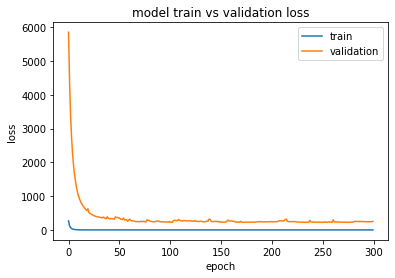

In [ ]:
LSTMModel = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(1)])

LSTMModel.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Predictions

In [ ]:
from tensorflow.keras.models import load_model
LSTMModel = load_model('LSTMModel/')

In [ ]:
train_predictions = LSTMModel.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1.flatten()})
train_results

229/229 [==============================] - 1s 3ms/step


Train Predictions    Actuals
0              0.397477   0.382905
1              0.392414   0.370740
2              0.378762   0.383852
3              0.393705   0.382590
4              0.395984   0.397632
...                 ...        ...
7295          59.514008  59.600000
7296          59.630451  61.061000
7297          61.521294  62.153000
7298          62.324757  62.214500
7299          62.089539  64.728250

[7300 rows x 2 columns]

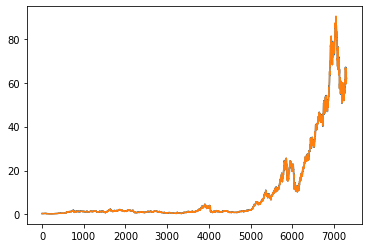

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [ ]:
val_predictions = LSTMModel.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1.flatten()})
val_results

16/16 [==============================] - 0s 3ms/step


Val Predictions   Actuals
0          65.375877   64.7605
1          64.480545   63.9305
2          63.658924   64.0165
3          64.166931   63.5970
4          63.541306   63.2445
..               ...       ...
495        90.452255  108.3175
496        90.454514  111.1175
497        90.459686  111.0050
498        90.463104  111.3525
499        90.464340  110.2000

[500 rows x 2 columns]

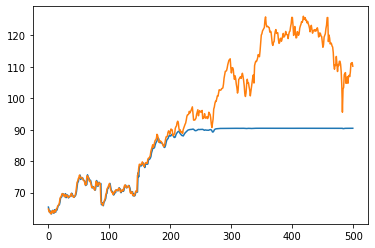

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results

17/17 [==============================] - 0s 3ms/step


Test Predictions   Actuals
0           90.463493  108.2850
1           90.460640  109.7450
2           90.460068  108.6825
3           90.459366  109.2775
4           90.460022  109.3125
..                ...       ...
538         90.266685  172.7100
539         90.258751  173.8175
540         90.251541  174.7400
541         90.245438  174.4275
542         90.244751  174.8575

[543 rows x 2 columns]

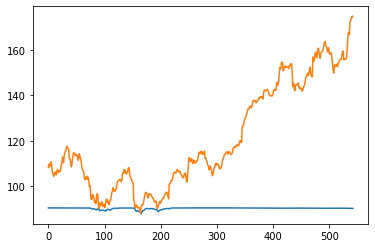

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## Exploring variables

### Adding dropout to combat overfitting


Dropout of 0.1 with epochs 300, learning rate 0.001

Epoch 1/300
229/229 [==============================] - ETA: 0s - loss: 86.0696 - mean_absolute_error: 2.7037

229/229 [==============================] - 12s 44ms/step - loss: 86.0696 - mean_absolute_error: 2.7037 - val_loss: 567.3965 - val_mean_absolute_error: 20.1380
Epoch 2/300
224/229 [============================>.] - ETA: 0s - loss: 1.0391 - mean_absolute_error: 0.4482

229/229 [==============================] - 8s 34ms/step - loss: 1.0314 - mean_absolute_error: 0.4474 - val_loss: 400.2714 - val_mean_absolute_error: 16.9356
Epoch 3/300
229/229 [==============================] - 2s 7ms/step - loss: 0.4685 - mean_absolute_error: 0.3548 - val_loss: 455.8801 - val_mean_absolute_error: 19.1363
Epoch 4/300
223/229 [============================>.] - ETA: 0s - loss: 0.6810 - mean_absolute_error: 0.3951

229/229 [==============================] - 10s 43ms/step - loss: 0.6775 - mean_absolute_error: 0.3948 - val_loss: 324.2592 - val_mean_absolute_error: 15.6113
Epoch 5/300
225/229 [============================>.] - ETA: 0s - loss: 0.3900 - mean_absolute_error: 0.3340

229/229 [==============================] - 9s 40ms/step - loss: 0.3873 - mean_absolute_error: 0.3329 - val_loss: 316.4888 - val_mean_absolute_error: 15.2411
Epoch 6/300
225/229 [============================>.] - ETA: 0s - loss: 0.3160 - mean_absolute_error: 0.2962

229/229 [==============================] - 9s 41ms/step - loss: 0.3138 - mean_absolute_error: 0.2953 - val_loss: 297.4325 - val_mean_absolute_error: 14.8830
Epoch 7/300
225/229 [============================>.] - ETA: 0s - loss: 0.5297 - mean_absolute_error: 0.3152

229/229 [==============================] - 10s 45ms/step - loss: 0.5325 - mean_absolute_error: 0.3164 - val_loss: 225.4965 - val_mean_absolute_error: 12.6602
Epoch 8/300
229/229 [==============================] - 2s 8ms/step - loss: 0.3456 - mean_absolute_error: 0.2978 - val_loss: 237.5813 - val_mean_absolute_error: 13.1597
Epoch 9/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2782 - mean_absolute_error: 0.2752 - val_loss: 254.8011 - val_mean_absolute_error: 14.0108
Epoch 10/300
229/229 [==============================] - 2s 7ms/step - loss: 0.3097 - mean_absolute_error: 0.2930 - val_loss: 257.5950 - val_mean_absolute_error: 13.8453
Epoch 11/300
229/229 [==============================] - 2s 10ms/step - loss: 0.3800 - mean_absolute_error: 0.3135 - val_loss: 258.3412 - val_mean_absolute_error: 13.6723
Epoch 12/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2906 - mean_absolute_error: 0.2744 - val_loss: 242.1622 - val_mean_absolute_error: 13.331

229/229 [==============================] - 7s 32ms/step - loss: 0.3133 - mean_absolute_error: 0.2429 - val_loss: 220.3116 - val_mean_absolute_error: 13.1424
Epoch 24/300
229/229 [==============================] - 1s 6ms/step - loss: 0.3707 - mean_absolute_error: 0.2524 - val_loss: 227.9114 - val_mean_absolute_error: 11.5646
Epoch 25/300
229/229 [==============================] - 2s 7ms/step - loss: 0.4502 - mean_absolute_error: 0.3091 - val_loss: 268.7195 - val_mean_absolute_error: 14.0616
Epoch 26/300
229/229 [==============================] - 1s 7ms/step - loss: 0.3138 - mean_absolute_error: 0.2647 - val_loss: 234.2371 - val_mean_absolute_error: 13.1494
Epoch 27/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2519 - mean_absolute_error: 0.2256 - val_loss: 224.3233 - val_mean_absolute_error: 12.9742
Epoch 28/300
229/229 [==============================] - 1s 6ms/step - loss: 0.2714 - mean_absolute_error: 0.2408 - val_loss: 230.7081 - val_mean_absolute_error: 13.346

229/229 [==============================] - 7s 30ms/step - loss: 0.2334 - mean_absolute_error: 0.2165 - val_loss: 211.9052 - val_mean_absolute_error: 12.6374
Epoch 34/300
229/229 [==============================] - 1s 6ms/step - loss: 0.3962 - mean_absolute_error: 0.2741 - val_loss: 250.2155 - val_mean_absolute_error: 13.7180
Epoch 35/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2511 - mean_absolute_error: 0.2198 - val_loss: 239.1416 - val_mean_absolute_error: 13.3288
Epoch 36/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2564 - mean_absolute_error: 0.2278 - val_loss: 232.3969 - val_mean_absolute_error: 13.2615
Epoch 37/300
226/229 [============================>.] - ETA: 0s - loss: 0.2976 - mean_absolute_error: 0.2312

229/229 [==============================] - 7s 32ms/step - loss: 0.2979 - mean_absolute_error: 0.2316 - val_loss: 172.5818 - val_mean_absolute_error: 11.9042
Epoch 38/300
229/229 [==============================] - 2s 7ms/step - loss: 0.3071 - mean_absolute_error: 0.2558 - val_loss: 242.8952 - val_mean_absolute_error: 13.6206
Epoch 39/300
229/229 [==============================] - 2s 8ms/step - loss: 0.2245 - mean_absolute_error: 0.2146 - val_loss: 214.1980 - val_mean_absolute_error: 12.6818
Epoch 40/300
229/229 [==============================] - 2s 8ms/step - loss: 0.2530 - mean_absolute_error: 0.2234 - val_loss: 277.6299 - val_mean_absolute_error: 14.6113
Epoch 41/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2465 - mean_absolute_error: 0.2301 - val_loss: 224.8858 - val_mean_absolute_error: 13.2432
Epoch 42/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2471 - mean_absolute_error: 0.2302 - val_loss: 204.0854 - val_mean_absolute_error: 12.070

229/229 [==============================] - 7s 30ms/step - loss: 0.3427 - mean_absolute_error: 0.2473 - val_loss: 163.0566 - val_mean_absolute_error: 11.4214
Epoch 64/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1954 - mean_absolute_error: 0.1864 - val_loss: 209.1308 - val_mean_absolute_error: 12.8768
Epoch 65/300
229/229 [==============================] - 1s 7ms/step - loss: 0.1918 - mean_absolute_error: 0.1865 - val_loss: 265.8320 - val_mean_absolute_error: 14.6093
Epoch 66/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2368 - mean_absolute_error: 0.2012 - val_loss: 196.8379 - val_mean_absolute_error: 12.1508
Epoch 67/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2390 - mean_absolute_error: 0.2026 - val_loss: 282.1001 - val_mean_absolute_error: 15.1753
Epoch 68/300
229/229 [==============================] - 2s 7ms/step - loss: 0.2493 - mean_absolute_error: 0.2110 - val_loss: 228.0024 - val_mean_absolute_error: 13.542

229/229 [==============================] - 7s 32ms/step - loss: 0.2022 - mean_absolute_error: 0.1847 - val_loss: 157.7196 - val_mean_absolute_error: 10.3896
Epoch 134/300
229/229 [==============================] - 1s 6ms/step - loss: 0.2148 - mean_absolute_error: 0.1887 - val_loss: 246.5289 - val_mean_absolute_error: 14.1051
Epoch 135/300
229/229 [==============================] - 1s 6ms/step - loss: 0.2183 - mean_absolute_error: 0.1874 - val_loss: 230.2784 - val_mean_absolute_error: 13.7347
Epoch 136/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1947 - mean_absolute_error: 0.1802 - val_loss: 226.3063 - val_mean_absolute_error: 13.3007
Epoch 137/300
229/229 [==============================] - 1s 6ms/step - loss: 0.2464 - mean_absolute_error: 0.1965 - val_loss: 205.4220 - val_mean_absolute_error: 12.3846
Epoch 138/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1865 - mean_absolute_error: 0.1761 - val_loss: 187.8474 - val_mean_absolute_error: 1

229/229 [==============================] - 7s 29ms/step - loss: 0.2054 - mean_absolute_error: 0.1907 - val_loss: 118.4492 - val_mean_absolute_error: 8.8459
Epoch 173/300
229/229 [==============================] - 1s 6ms/step - loss: 0.2499 - mean_absolute_error: 0.1982 - val_loss: 198.3043 - val_mean_absolute_error: 12.4715
Epoch 174/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1701 - mean_absolute_error: 0.1637 - val_loss: 164.7163 - val_mean_absolute_error: 11.1792
Epoch 175/300
229/229 [==============================] - 1s 6ms/step - loss: 0.2235 - mean_absolute_error: 0.1950 - val_loss: 161.7809 - val_mean_absolute_error: 11.1278
Epoch 176/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1907 - mean_absolute_error: 0.1703 - val_loss: 181.1652 - val_mean_absolute_error: 11.8594
Epoch 177/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1866 - mean_absolute_error: 0.1747 - val_loss: 174.4021 - val_mean_absolute_error: 11

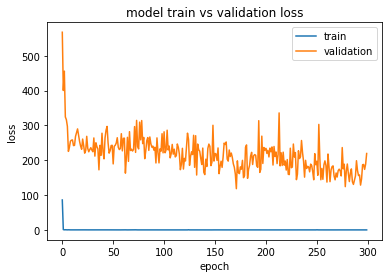

In [ ]:
DropoutModel = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64, dropout=0.1),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])
DropoutModel.summary()

DropoutModel.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = DropoutModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Dropout of 0.3 with epochs 300, learning rate 0.001

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                16896     
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
229/229 [==============================] - 4s 9ms/step - loss: 126.2385 - mean_absolute_error: 3.8555 - val_loss: 1159.3635 - val_mean_absolute_error: 32.4616
Epoch 2/300

NameError: ignored

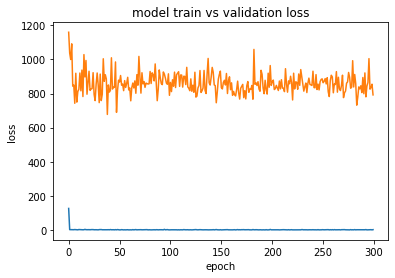

In [ ]:
DropoutModel = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64, dropout=0.3),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])
DropoutModel.summary()

DropoutModel.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = DropoutModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Window Size

In [ ]:
X2, y2 = df_to_X_y(temp_applev3_df, 1)
X3, y3 = df_to_X_y(temp_applev3_df, 10)
X2.shape, y2.shape

((8347, 1, 1, 1), (8347, 1))

In [ ]:
## Train test val split
X_train2, y_train2 = X2[:7300], y2[:7300]
X_val2, y_val2 = X2[7300:7800], y2[7300:7800]
X_test2, y_test2 = X2[7800:], y2[7800:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((7300, 1, 1, 1),
 (7300, 1),
 (500, 1, 1, 1),
 (500, 1),
 (547, 1, 1, 1),
 (547, 1))

Model: "WindowSizeVariations"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


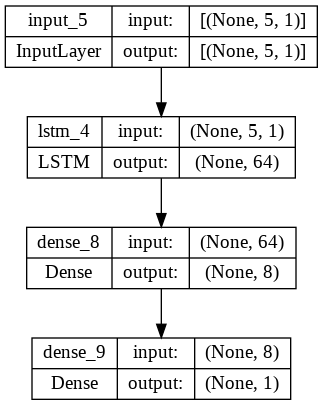

In [ ]:
windowSizeVariations = Sequential(name="WindowSizeVariations", layers=[
    layers.InputLayer((5,1)),
    layers.LSTM(64),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear'),
])

# models.Sequential(name="LSTM", layers=[
#     layers.LSTM(              # LSTM layer
#           name="LSTM",        
#           input_dim=1,        #number of inputs
#           units=1,            #number of outputs
#           dropout=0.1,        #Dropout percentage
#           activation='linear' #activation type (can be altered)
#     ),
# ])
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM -> more information on LSTM API

windowSizeVariations.summary()
utils.plot_model(windowSizeVariations, show_shapes=True, show_layer_names=True) # displays image of model

In [ ]:
windowSizeVariations.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

## Using less variables

In [ ]:
X1, y1 = df_to_X_y(temp_applev3_df, 3)
X1.shape, y1.shape

((8345, 3, 1, 1), (8345, 1))

In [ ]:
## Train test val split
X_train1, y_train1 = X1[:7300], y1[:7300]
X_val1, y_val1 = X1[7300:7800], y1[7300:7800]
X_test1, y_test1 = X1[7800:], y1[7800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((7300, 3, 1, 1),
 (7300, 1),
 (500, 3, 1, 1),
 (500, 1),
 (545, 3, 1, 1),
 (545, 1))

Epoch 1/300
220/229 [===========================>..] - ETA: 0s - loss: 357.3348 - root_mean_squared_error: 18.9033

229/229 [==============================] - 9s 28ms/step - loss: 355.4771 - root_mean_squared_error: 18.8541 - val_loss: 7459.1392 - val_root_mean_squared_error: 86.3663
Epoch 2/300
222/229 [============================>.] - ETA: 0s - loss: 202.6403 - root_mean_squared_error: 14.2352

229/229 [==============================] - 6s 24ms/step - loss: 200.6856 - root_mean_squared_error: 14.1664 - val_loss: 5538.8501 - val_root_mean_squared_error: 74.4235
Epoch 3/300
220/229 [===========================>..] - ETA: 0s - loss: 113.2262 - root_mean_squared_error: 10.6408

229/229 [==============================] - 6s 25ms/step - loss: 112.5855 - root_mean_squared_error: 10.6106 - val_loss: 4217.7803 - val_root_mean_squared_error: 64.9444
Epoch 4/300
225/229 [============================>.] - ETA: 0s - loss: 64.7269 - root_mean_squared_error: 8.0453

229/229 [==============================] - 5s 24ms/step - loss: 64.5043 - root_mean_squared_error: 8.0315 - val_loss: 3245.3579 - val_root_mean_squared_error: 56.9680
Epoch 5/300
219/229 [===========================>..] - ETA: 0s - loss: 37.4079 - root_mean_squared_error: 6.1162

229/229 [==============================] - 6s 26ms/step - loss: 36.6414 - root_mean_squared_error: 6.0532 - val_loss: 2514.7395 - val_root_mean_squared_error: 50.1472
Epoch 6/300
225/229 [============================>.] - ETA: 0s - loss: 21.5358 - root_mean_squared_error: 4.6407

229/229 [==============================] - 6s 25ms/step - loss: 21.3404 - root_mean_squared_error: 4.6196 - val_loss: 2002.3900 - val_root_mean_squared_error: 44.7481
Epoch 7/300
217/229 [===========================>..] - ETA: 0s - loss: 12.7184 - root_mean_squared_error: 3.5663

229/229 [==============================] - 5s 24ms/step - loss: 12.6739 - root_mean_squared_error: 3.5600 - val_loss: 1627.2281 - val_root_mean_squared_error: 40.3389
Epoch 8/300
229/229 [==============================] - ETA: 0s - loss: 7.6043 - root_mean_squared_error: 2.7576

229/229 [==============================] - 6s 26ms/step - loss: 7.6043 - root_mean_squared_error: 2.7576 - val_loss: 1347.6045 - val_root_mean_squared_error: 36.7097
Epoch 9/300
214/229 [===========================>..] - ETA: 0s - loss: 4.6118 - root_mean_squared_error: 2.1475

229/229 [==============================] - 5s 24ms/step - loss: 4.5849 - root_mean_squared_error: 2.1412 - val_loss: 1140.1788 - val_root_mean_squared_error: 33.7665
Epoch 10/300
214/229 [===========================>..] - ETA: 0s - loss: 2.7989 - root_mean_squared_error: 1.6730

229/229 [==============================] - 5s 24ms/step - loss: 2.7444 - root_mean_squared_error: 1.6566 - val_loss: 981.1911 - val_root_mean_squared_error: 31.3240
Epoch 11/300
215/229 [===========================>..] - ETA: 0s - loss: 1.8113 - root_mean_squared_error: 1.3459

229/229 [==============================] - 6s 26ms/step - loss: 1.7880 - root_mean_squared_error: 1.3372 - val_loss: 867.5634 - val_root_mean_squared_error: 29.4544
Epoch 12/300
225/229 [============================>.] - ETA: 0s - loss: 1.2266 - root_mean_squared_error: 1.1075

229/229 [==============================] - 6s 25ms/step - loss: 1.2127 - root_mean_squared_error: 1.1012 - val_loss: 784.2279 - val_root_mean_squared_error: 28.0041
Epoch 13/300
227/229 [============================>.] - ETA: 0s - loss: 0.8677 - root_mean_squared_error: 0.9315

229/229 [==============================] - 5s 24ms/step - loss: 0.8649 - root_mean_squared_error: 0.9300 - val_loss: 716.9503 - val_root_mean_squared_error: 26.7759
Epoch 14/300
217/229 [===========================>..] - ETA: 0s - loss: 0.6815 - root_mean_squared_error: 0.8255

229/229 [==============================] - 10s 45ms/step - loss: 0.6547 - root_mean_squared_error: 0.8091 - val_loss: 662.2507 - val_root_mean_squared_error: 25.7342
Epoch 15/300
222/229 [============================>.] - ETA: 0s - loss: 0.5239 - root_mean_squared_error: 0.7238

229/229 [==============================] - 9s 39ms/step - loss: 0.5136 - root_mean_squared_error: 0.7166 - val_loss: 617.7712 - val_root_mean_squared_error: 24.8550
Epoch 16/300
225/229 [============================>.] - ETA: 0s - loss: 0.4227 - root_mean_squared_error: 0.6502

229/229 [==============================] - 6s 26ms/step - loss: 0.4185 - root_mean_squared_error: 0.6469 - val_loss: 578.1145 - val_root_mean_squared_error: 24.0440
Epoch 17/300
228/229 [============================>.] - ETA: 0s - loss: 0.3412 - root_mean_squared_error: 0.5841

229/229 [==============================] - 6s 24ms/step - loss: 0.3413 - root_mean_squared_error: 0.5842 - val_loss: 543.8120 - val_root_mean_squared_error: 23.3198
Epoch 18/300
216/229 [===========================>..] - ETA: 0s - loss: 0.2878 - root_mean_squared_error: 0.5365

229/229 [==============================] - 6s 26ms/step - loss: 0.2898 - root_mean_squared_error: 0.5383 - val_loss: 513.4484 - val_root_mean_squared_error: 22.6594
Epoch 19/300
225/229 [============================>.] - ETA: 0s - loss: 0.2476 - root_mean_squared_error: 0.4976

229/229 [==============================] - 5s 24ms/step - loss: 0.2475 - root_mean_squared_error: 0.4975 - val_loss: 488.2806 - val_root_mean_squared_error: 22.0971
Epoch 20/300
228/229 [============================>.] - ETA: 0s - loss: 0.2336 - root_mean_squared_error: 0.4833

229/229 [==============================] - 6s 26ms/step - loss: 0.2334 - root_mean_squared_error: 0.4831 - val_loss: 466.4022 - val_root_mean_squared_error: 21.5963
Epoch 21/300
225/229 [============================>.] - ETA: 0s - loss: 0.2110 - root_mean_squared_error: 0.4593

229/229 [==============================] - 5s 24ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577 - val_loss: 444.5646 - val_root_mean_squared_error: 21.0847
Epoch 22/300
222/229 [============================>.] - ETA: 0s - loss: 0.1835 - root_mean_squared_error: 0.4284

229/229 [==============================] - 6s 26ms/step - loss: 0.1860 - root_mean_squared_error: 0.4313 - val_loss: 427.5062 - val_root_mean_squared_error: 20.6762
Epoch 23/300
228/229 [============================>.] - ETA: 0s - loss: 0.1821 - root_mean_squared_error: 0.4267

229/229 [==============================] - 5s 24ms/step - loss: 0.1820 - root_mean_squared_error: 0.4266 - val_loss: 411.3607 - val_root_mean_squared_error: 20.2820
Epoch 24/300
226/229 [============================>.] - ETA: 0s - loss: 0.2079 - root_mean_squared_error: 0.4559

229/229 [==============================] - 5s 24ms/step - loss: 0.2080 - root_mean_squared_error: 0.4561 - val_loss: 397.8860 - val_root_mean_squared_error: 19.9471
Epoch 25/300
216/229 [===========================>..] - ETA: 0s - loss: 0.1608 - root_mean_squared_error: 0.4009

229/229 [==============================] - 6s 26ms/step - loss: 0.1600 - root_mean_squared_error: 0.4000 - val_loss: 387.7368 - val_root_mean_squared_error: 19.6910
Epoch 26/300
224/229 [============================>.] - ETA: 0s - loss: 0.1578 - root_mean_squared_error: 0.3973

229/229 [==============================] - 6s 27ms/step - loss: 0.1594 - root_mean_squared_error: 0.3993 - val_loss: 376.4407 - val_root_mean_squared_error: 19.4021
Epoch 27/300
221/229 [===========================>..] - ETA: 0s - loss: 0.1526 - root_mean_squared_error: 0.3907

229/229 [==============================] - 6s 26ms/step - loss: 0.1549 - root_mean_squared_error: 0.3936 - val_loss: 367.3117 - val_root_mean_squared_error: 19.1654
Epoch 28/300
217/229 [===========================>..] - ETA: 0s - loss: 0.1538 - root_mean_squared_error: 0.3921

229/229 [==============================] - 6s 26ms/step - loss: 0.1543 - root_mean_squared_error: 0.3928 - val_loss: 360.2073 - val_root_mean_squared_error: 18.9791
Epoch 29/300
229/229 [==============================] - ETA: 0s - loss: 0.1459 - root_mean_squared_error: 0.3820

229/229 [==============================] - 5s 24ms/step - loss: 0.1459 - root_mean_squared_error: 0.3820 - val_loss: 352.7554 - val_root_mean_squared_error: 18.7818
Epoch 30/300
225/229 [============================>.] - ETA: 0s - loss: 0.1532 - root_mean_squared_error: 0.3914

229/229 [==============================] - 6s 26ms/step - loss: 0.1529 - root_mean_squared_error: 0.3910 - val_loss: 345.7657 - val_root_mean_squared_error: 18.5948
Epoch 31/300
229/229 [==============================] - ETA: 0s - loss: 0.1416 - root_mean_squared_error: 0.3764

229/229 [==============================] - 6s 24ms/step - loss: 0.1416 - root_mean_squared_error: 0.3764 - val_loss: 338.2732 - val_root_mean_squared_error: 18.3922
Epoch 32/300
215/229 [===========================>..] - ETA: 0s - loss: 0.1508 - root_mean_squared_error: 0.3883

229/229 [==============================] - 6s 25ms/step - loss: 0.1581 - root_mean_squared_error: 0.3976 - val_loss: 335.3438 - val_root_mean_squared_error: 18.3124
Epoch 33/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1563 - root_mean_squared_error: 0.3953 - val_loss: 335.4947 - val_root_mean_squared_error: 18.3165
Epoch 34/300
226/229 [============================>.] - ETA: 0s - loss: 0.1487 - root_mean_squared_error: 0.3857

229/229 [==============================] - 5s 24ms/step - loss: 0.1487 - root_mean_squared_error: 0.3856 - val_loss: 328.3462 - val_root_mean_squared_error: 18.1203
Epoch 35/300
223/229 [============================>.] - ETA: 0s - loss: 0.1402 - root_mean_squared_error: 0.3744

229/229 [==============================] - 6s 26ms/step - loss: 0.1403 - root_mean_squared_error: 0.3746 - val_loss: 323.8042 - val_root_mean_squared_error: 17.9946
Epoch 36/300
228/229 [============================>.] - ETA: 0s - loss: 0.1478 - root_mean_squared_error: 0.3844

229/229 [==============================] - 6s 24ms/step - loss: 0.1480 - root_mean_squared_error: 0.3847 - val_loss: 319.9380 - val_root_mean_squared_error: 17.8868
Epoch 37/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1555 - root_mean_squared_error: 0.3944 - val_loss: 321.0207 - val_root_mean_squared_error: 17.9170
Epoch 38/300
229/229 [==============================] - 1s 3ms/step - loss: 0.1420 - root_mean_squared_error: 0.3769 - val_loss: 320.0981 - val_root_mean_squared_error: 17.8913
Epoch 39/300
227/229 [============================>.] - ETA: 0s - loss: 0.1504 - root_mean_squared_error: 0.3879

229/229 [==============================] - 6s 26ms/step - loss: 0.1507 - root_mean_squared_error: 0.3882 - val_loss: 318.2731 - val_root_mean_squared_error: 17.8402
Epoch 40/300
218/229 [===========================>..] - ETA: 0s - loss: 0.1434 - root_mean_squared_error: 0.3786

229/229 [==============================] - 6s 24ms/step - loss: 0.1417 - root_mean_squared_error: 0.3764 - val_loss: 317.0978 - val_root_mean_squared_error: 17.8072
Epoch 41/300
224/229 [============================>.] - ETA: 0s - loss: 0.1440 - root_mean_squared_error: 0.3795

229/229 [==============================] - 5s 24ms/step - loss: 0.1436 - root_mean_squared_error: 0.3789 - val_loss: 313.9493 - val_root_mean_squared_error: 17.7186
Epoch 42/300
223/229 [============================>.] - ETA: 0s - loss: 0.1496 - root_mean_squared_error: 0.3868

229/229 [==============================] - 6s 26ms/step - loss: 0.1502 - root_mean_squared_error: 0.3876 - val_loss: 309.5243 - val_root_mean_squared_error: 17.5933
Epoch 43/300
226/229 [============================>.] - ETA: 0s - loss: 0.1435 - root_mean_squared_error: 0.3788

229/229 [==============================] - 6s 25ms/step - loss: 0.1431 - root_mean_squared_error: 0.3783 - val_loss: 308.9864 - val_root_mean_squared_error: 17.5780
Epoch 44/300
224/229 [============================>.] - ETA: 0s - loss: 0.1546 - root_mean_squared_error: 0.3932

229/229 [==============================] - 5s 24ms/step - loss: 0.1527 - root_mean_squared_error: 0.3908 - val_loss: 307.1825 - val_root_mean_squared_error: 17.5266
Epoch 45/300
226/229 [============================>.] - ETA: 0s - loss: 0.1489 - root_mean_squared_error: 0.3858

229/229 [==============================] - 6s 26ms/step - loss: 0.1499 - root_mean_squared_error: 0.3872 - val_loss: 303.4854 - val_root_mean_squared_error: 17.4208
Epoch 46/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1434 - root_mean_squared_error: 0.3787 - val_loss: 304.9344 - val_root_mean_squared_error: 17.4624
Epoch 47/300
224/229 [============================>.] - ETA: 0s - loss: 0.1554 - root_mean_squared_error: 0.3942

229/229 [==============================] - 6s 24ms/step - loss: 0.1549 - root_mean_squared_error: 0.3936 - val_loss: 301.9838 - val_root_mean_squared_error: 17.3777
Epoch 48/300
221/229 [===========================>..] - ETA: 0s - loss: 0.1349 - root_mean_squared_error: 0.3672

229/229 [==============================] - 6s 25ms/step - loss: 0.1342 - root_mean_squared_error: 0.3664 - val_loss: 299.3773 - val_root_mean_squared_error: 17.3025
Epoch 49/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1522 - root_mean_squared_error: 0.3902 - val_loss: 300.2645 - val_root_mean_squared_error: 17.3281
Epoch 50/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1431 - root_mean_squared_error: 0.3782 - val_loss: 301.4482 - val_root_mean_squared_error: 17.3623
Epoch 51/300
224/229 [============================>.] - ETA: 0s - loss: 0.1344 - root_mean_squared_error: 0.3666

229/229 [==============================] - 5s 24ms/step - loss: 0.1340 - root_mean_squared_error: 0.3661 - val_loss: 299.2166 - val_root_mean_squared_error: 17.2979
Epoch 52/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1535 - root_mean_squared_error: 0.3918 - val_loss: 300.3682 - val_root_mean_squared_error: 17.3311
Epoch 53/300
226/229 [============================>.] - ETA: 0s - loss: 0.1330 - root_mean_squared_error: 0.3647

229/229 [==============================] - 6s 24ms/step - loss: 0.1329 - root_mean_squared_error: 0.3645 - val_loss: 295.8819 - val_root_mean_squared_error: 17.2012
Epoch 54/300
220/229 [===========================>..] - ETA: 0s - loss: 0.1392 - root_mean_squared_error: 0.3731

229/229 [==============================] - 7s 30ms/step - loss: 0.1380 - root_mean_squared_error: 0.3715 - val_loss: 295.5724 - val_root_mean_squared_error: 17.1922
Epoch 55/300
227/229 [============================>.] - ETA: 0s - loss: 0.1376 - root_mean_squared_error: 0.3709

229/229 [==============================] - 6s 25ms/step - loss: 0.1373 - root_mean_squared_error: 0.3705 - val_loss: 292.8376 - val_root_mean_squared_error: 17.1125
Epoch 56/300
220/229 [===========================>..] - ETA: 0s - loss: 0.1409 - root_mean_squared_error: 0.3753

229/229 [==============================] - 6s 24ms/step - loss: 0.1409 - root_mean_squared_error: 0.3753 - val_loss: 290.8987 - val_root_mean_squared_error: 17.0558
Epoch 57/300
215/229 [===========================>..] - ETA: 0s - loss: 0.1521 - root_mean_squared_error: 0.3901

229/229 [==============================] - 6s 26ms/step - loss: 0.1504 - root_mean_squared_error: 0.3878 - val_loss: 290.2397 - val_root_mean_squared_error: 17.0364
Epoch 58/300
219/229 [===========================>..] - ETA: 0s - loss: 0.1352 - root_mean_squared_error: 0.3676

229/229 [==============================] - 5s 24ms/step - loss: 0.1400 - root_mean_squared_error: 0.3741 - val_loss: 288.3240 - val_root_mean_squared_error: 16.9801
Epoch 59/300
225/229 [============================>.] - ETA: 0s - loss: 0.1499 - root_mean_squared_error: 0.3872

229/229 [==============================] - 6s 26ms/step - loss: 0.1493 - root_mean_squared_error: 0.3864 - val_loss: 285.8194 - val_root_mean_squared_error: 16.9062
Epoch 60/300
226/229 [============================>.] - ETA: 0s - loss: 0.1388 - root_mean_squared_error: 0.3726

229/229 [==============================] - 6s 24ms/step - loss: 0.1380 - root_mean_squared_error: 0.3715 - val_loss: 282.1335 - val_root_mean_squared_error: 16.7968
Epoch 61/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1446 - root_mean_squared_error: 0.3803 - val_loss: 284.7420 - val_root_mean_squared_error: 16.8743
Epoch 62/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1554 - root_mean_squared_error: 0.3942 - val_loss: 284.0628 - val_root_mean_squared_error: 16.8542
Epoch 63/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1381 - root_mean_squared_error: 0.3717 - val_loss: 282.6250 - val_root_mean_squared_error: 16.8115
Epoch 64/300
227/229 [============================>.] - ETA: 0s - loss: 0.1479 - root_mean_squared_error: 0.3846

229/229 [==============================] - 6s 26ms/step - loss: 0.1476 - root_mean_squared_error: 0.3841 - val_loss: 280.5890 - val_root_mean_squared_error: 16.7508
Epoch 65/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1357 - root_mean_squared_error: 0.3684 - val_loss: 281.1630 - val_root_mean_squared_error: 16.7679
Epoch 66/300
219/229 [===========================>..] - ETA: 0s - loss: 0.1489 - root_mean_squared_error: 0.3859

229/229 [==============================] - 6s 24ms/step - loss: 0.1474 - root_mean_squared_error: 0.3839 - val_loss: 275.9866 - val_root_mean_squared_error: 16.6128
Epoch 67/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1661 - root_mean_squared_error: 0.4075 - val_loss: 277.2193 - val_root_mean_squared_error: 16.6499
Epoch 68/300
223/229 [============================>.] - ETA: 0s - loss: 0.1392 - root_mean_squared_error: 0.3731

229/229 [==============================] - 5s 24ms/step - loss: 0.1391 - root_mean_squared_error: 0.3729 - val_loss: 275.6355 - val_root_mean_squared_error: 16.6023
Epoch 69/300
228/229 [============================>.] - ETA: 0s - loss: 0.1410 - root_mean_squared_error: 0.3755

229/229 [==============================] - 6s 26ms/step - loss: 0.1409 - root_mean_squared_error: 0.3754 - val_loss: 274.1685 - val_root_mean_squared_error: 16.5580
Epoch 70/300
221/229 [===========================>..] - ETA: 0s - loss: 0.1462 - root_mean_squared_error: 0.3823

229/229 [==============================] - 6s 25ms/step - loss: 0.1451 - root_mean_squared_error: 0.3810 - val_loss: 273.3145 - val_root_mean_squared_error: 16.5322
Epoch 71/300
226/229 [============================>.] - ETA: 0s - loss: 0.1428 - root_mean_squared_error: 0.3779

229/229 [==============================] - 6s 24ms/step - loss: 0.1433 - root_mean_squared_error: 0.3785 - val_loss: 270.4774 - val_root_mean_squared_error: 16.4462
Epoch 72/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1426 - root_mean_squared_error: 0.3776 - val_loss: 272.3087 - val_root_mean_squared_error: 16.5018
Epoch 73/300
219/229 [===========================>..] - ETA: 0s - loss: 0.1318 - root_mean_squared_error: 0.3630

229/229 [==============================] - 6s 26ms/step - loss: 0.1389 - root_mean_squared_error: 0.3727 - val_loss: 268.4374 - val_root_mean_squared_error: 16.3841
Epoch 74/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1406 - root_mean_squared_error: 0.3749 - val_loss: 271.0623 - val_root_mean_squared_error: 16.4640
Epoch 75/300
222/229 [============================>.] - ETA: 0s - loss: 0.1423 - root_mean_squared_error: 0.3773

229/229 [==============================] - 6s 24ms/step - loss: 0.1414 - root_mean_squared_error: 0.3760 - val_loss: 267.0764 - val_root_mean_squared_error: 16.3425
Epoch 76/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1501 - root_mean_squared_error: 0.3874 - val_loss: 269.4839 - val_root_mean_squared_error: 16.4160
Epoch 77/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1492 - root_mean_squared_error: 0.3863 - val_loss: 267.9844 - val_root_mean_squared_error: 16.3702
Epoch 78/300
225/229 [============================>.] - ETA: 0s - loss: 0.1393 - root_mean_squared_error: 0.3732

229/229 [==============================] - 6s 26ms/step - loss: 0.1405 - root_mean_squared_error: 0.3748 - val_loss: 265.4042 - val_root_mean_squared_error: 16.2912
Epoch 79/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1447 - root_mean_squared_error: 0.3805 - val_loss: 269.9026 - val_root_mean_squared_error: 16.4287
Epoch 80/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1350 - root_mean_squared_error: 0.3674 - val_loss: 268.4958 - val_root_mean_squared_error: 16.3858
Epoch 81/300
228/229 [============================>.] - ETA: 0s - loss: 0.1401 - root_mean_squared_error: 0.3743

229/229 [==============================] - 6s 25ms/step - loss: 0.1401 - root_mean_squared_error: 0.3742 - val_loss: 265.3944 - val_root_mean_squared_error: 16.2909
Epoch 82/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1458 - root_mean_squared_error: 0.3819 - val_loss: 266.3811 - val_root_mean_squared_error: 16.3212
Epoch 83/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1344 - root_mean_squared_error: 0.3667 - val_loss: 265.5330 - val_root_mean_squared_error: 16.2952
Epoch 84/300
227/229 [============================>.] - ETA: 0s - loss: 0.1368 - root_mean_squared_error: 0.3699

229/229 [==============================] - 6s 26ms/step - loss: 0.1365 - root_mean_squared_error: 0.3694 - val_loss: 263.8078 - val_root_mean_squared_error: 16.2422
Epoch 85/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - val_loss: 266.3421 - val_root_mean_squared_error: 16.3200
Epoch 86/300
224/229 [============================>.] - ETA: 0s - loss: 0.1306 - root_mean_squared_error: 0.3614

229/229 [==============================] - 6s 24ms/step - loss: 0.1386 - root_mean_squared_error: 0.3723 - val_loss: 262.2524 - val_root_mean_squared_error: 16.1942
Epoch 87/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1503 - root_mean_squared_error: 0.3877 - val_loss: 266.3873 - val_root_mean_squared_error: 16.3214
Epoch 88/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1376 - root_mean_squared_error: 0.3709 - val_loss: 263.6160 - val_root_mean_squared_error: 16.2363
Epoch 89/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1354 - root_mean_squared_error: 0.3680 - val_loss: 263.8746 - val_root_mean_squared_error: 16.2442
Epoch 90/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1401 - root_mean_squared_error: 0.3743 - val_loss: 264.9246 - val_root_mean_squared_error: 16.2765
Epoch 91/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1391 - root_mean_squared_error: 0.3729 - val_loss

229/229 [==============================] - 6s 24ms/step - loss: 0.1418 - root_mean_squared_error: 0.3766 - val_loss: 261.8620 - val_root_mean_squared_error: 16.1822
Epoch 93/300
215/229 [===========================>..] - ETA: 0s - loss: 0.1443 - root_mean_squared_error: 0.3798

229/229 [==============================] - 6s 26ms/step - loss: 0.1510 - root_mean_squared_error: 0.3886 - val_loss: 260.9172 - val_root_mean_squared_error: 16.1529
Epoch 94/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1394 - root_mean_squared_error: 0.3733 - val_loss: 264.4507 - val_root_mean_squared_error: 16.2619
Epoch 95/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1471 - root_mean_squared_error: 0.3835 - val_loss: 265.1862 - val_root_mean_squared_error: 16.2845
Epoch 96/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1413 - root_mean_squared_error: 0.3759 - val_loss: 264.3095 - val_root_mean_squared_error: 16.2576
Epoch 97/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1456 - root_mean_squared_error: 0.3815 - val_loss: 264.0869 - val_root_mean_squared_error: 16.2507
Epoch 98/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1272 - root_mean_squared_error: 0.3567 - val_loss

229/229 [==============================] - 6s 25ms/step - loss: 0.1359 - root_mean_squared_error: 0.3686 - val_loss: 260.4518 - val_root_mean_squared_error: 16.1385
Epoch 102/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1455 - root_mean_squared_error: 0.3814 - val_loss: 263.5311 - val_root_mean_squared_error: 16.2336
Epoch 103/300
221/229 [===========================>..] - ETA: 0s - loss: 0.1332 - root_mean_squared_error: 0.3649

229/229 [==============================] - 5s 24ms/step - loss: 0.1312 - root_mean_squared_error: 0.3623 - val_loss: 259.8337 - val_root_mean_squared_error: 16.1194
Epoch 104/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1293 - root_mean_squared_error: 0.3596 - val_loss: 260.8624 - val_root_mean_squared_error: 16.1512
Epoch 105/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1357 - root_mean_squared_error: 0.3684 - val_loss: 262.8567 - val_root_mean_squared_error: 16.2129
Epoch 106/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1288 - root_mean_squared_error: 0.3588 - val_loss: 264.8882 - val_root_mean_squared_error: 16.2754
Epoch 107/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1379 - root_mean_squared_error: 0.3714 - val_loss: 262.4229 - val_root_mean_squared_error: 16.1995
Epoch 108/300
229/229 [==============================] - ETA: 0s - loss: 0.1377 - root_mean_squared_error: 0.3711

229/229 [==============================] - 6s 25ms/step - loss: 0.1377 - root_mean_squared_error: 0.3711 - val_loss: 259.6402 - val_root_mean_squared_error: 16.1134
Epoch 109/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1503 - root_mean_squared_error: 0.3877 - val_loss: 261.0023 - val_root_mean_squared_error: 16.1556
Epoch 110/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1427 - root_mean_squared_error: 0.3777 - val_loss: 262.0184 - val_root_mean_squared_error: 16.1870
Epoch 111/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1399 - root_mean_squared_error: 0.3740 - val_loss: 261.5862 - val_root_mean_squared_error: 16.1736
Epoch 112/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1410 - root_mean_squared_error: 0.3755 - val_loss: 264.9497 - val_root_mean_squared_error: 16.2773
Epoch 113/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1420 - root_mean_squared_error: 0.3768 - val

229/229 [==============================] - 5s 24ms/step - loss: 0.1385 - root_mean_squared_error: 0.3721 - val_loss: 259.5010 - val_root_mean_squared_error: 16.1090
Epoch 126/300
222/229 [============================>.] - ETA: 0s - loss: 0.1341 - root_mean_squared_error: 0.3662

229/229 [==============================] - 6s 26ms/step - loss: 0.1332 - root_mean_squared_error: 0.3649 - val_loss: 257.2767 - val_root_mean_squared_error: 16.0398
Epoch 127/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1416 - root_mean_squared_error: 0.3762 - val_loss: 258.9798 - val_root_mean_squared_error: 16.0928
Epoch 128/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1438 - root_mean_squared_error: 0.3792 - val_loss: 258.2730 - val_root_mean_squared_error: 16.0709
Epoch 129/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1320 - root_mean_squared_error: 0.3633 - val_loss: 257.9119 - val_root_mean_squared_error: 16.0596
Epoch 130/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1409 - root_mean_squared_error: 0.3753 - val_loss: 260.1388 - val_root_mean_squared_error: 16.1288
Epoch 131/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1317 - root_mean_squared_error: 0.3629 - val

229/229 [==============================] - 6s 24ms/step - loss: 0.1421 - root_mean_squared_error: 0.3770 - val_loss: 254.2997 - val_root_mean_squared_error: 15.9468
Epoch 133/300
226/229 [============================>.] - ETA: 0s - loss: 0.1327 - root_mean_squared_error: 0.3642

229/229 [==============================] - 6s 27ms/step - loss: 0.1326 - root_mean_squared_error: 0.3641 - val_loss: 251.7804 - val_root_mean_squared_error: 15.8676
Epoch 134/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1350 - root_mean_squared_error: 0.3674 - val_loss: 254.0538 - val_root_mean_squared_error: 15.9391
Epoch 135/300
229/229 [==============================] - 1s 5ms/step - loss: 0.1459 - root_mean_squared_error: 0.3820 - val_loss: 255.8786 - val_root_mean_squared_error: 15.9962
Epoch 136/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1450 - root_mean_squared_error: 0.3807 - val_loss: 257.6070 - val_root_mean_squared_error: 16.0501
Epoch 137/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1416 - root_mean_squared_error: 0.3763 - val_loss: 257.5265 - val_root_mean_squared_error: 16.0476
Epoch 138/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1337 - root_mean_squared_error: 0.3656 - val

229/229 [==============================] - 6s 24ms/step - loss: 0.1304 - root_mean_squared_error: 0.3611 - val_loss: 249.9773 - val_root_mean_squared_error: 15.8107
Epoch 149/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1406 - root_mean_squared_error: 0.3750 - val_loss: 254.6895 - val_root_mean_squared_error: 15.9590
Epoch 150/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1379 - root_mean_squared_error: 0.3713 - val_loss: 250.9208 - val_root_mean_squared_error: 15.8405
Epoch 151/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1412 - root_mean_squared_error: 0.3758 - val_loss: 250.5359 - val_root_mean_squared_error: 15.8283
Epoch 152/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1308 - root_mean_squared_error: 0.3616 - val_loss: 250.7170 - val_root_mean_squared_error: 15.8340
Epoch 153/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1394 - root_mean_squared_error: 0.3734 - val

229/229 [==============================] - 6s 26ms/step - loss: 0.1332 - root_mean_squared_error: 0.3650 - val_loss: 249.9425 - val_root_mean_squared_error: 15.8096
Epoch 170/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1332 - root_mean_squared_error: 0.3650 - val_loss: 250.0598 - val_root_mean_squared_error: 15.8133
Epoch 171/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1379 - root_mean_squared_error: 0.3713 - val_loss: 253.9055 - val_root_mean_squared_error: 15.9344
Epoch 172/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1290 - root_mean_squared_error: 0.3591 - val_loss: 250.2460 - val_root_mean_squared_error: 15.8192
Epoch 173/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1299 - root_mean_squared_error: 0.3604 - val_loss: 252.9588 - val_root_mean_squared_error: 15.9047
Epoch 174/300
221/229 [===========================>..] - ETA: 0s - loss: 0.1296 - root_mean_squared_error: 0.3600

229/229 [==============================] - 5s 24ms/step - loss: 0.1281 - root_mean_squared_error: 0.3579 - val_loss: 248.1647 - val_root_mean_squared_error: 15.7532
Epoch 175/300
223/229 [============================>.] - ETA: 0s - loss: 0.1383 - root_mean_squared_error: 0.3719

229/229 [==============================] - 6s 26ms/step - loss: 0.1401 - root_mean_squared_error: 0.3743 - val_loss: 247.1219 - val_root_mean_squared_error: 15.7201
Epoch 176/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1344 - root_mean_squared_error: 0.3667 - val_loss: 252.7542 - val_root_mean_squared_error: 15.8982
Epoch 177/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1343 - root_mean_squared_error: 0.3665 - val_loss: 252.0732 - val_root_mean_squared_error: 15.8768
Epoch 178/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1376 - root_mean_squared_error: 0.3709 - val_loss: 250.5644 - val_root_mean_squared_error: 15.8292
Epoch 179/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1300 - root_mean_squared_error: 0.3606 - val_loss: 248.3531 - val_root_mean_squared_error: 15.7592
Epoch 180/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - val

229/229 [==============================] - 6s 24ms/step - loss: 0.1285 - root_mean_squared_error: 0.3585 - val_loss: 245.9199 - val_root_mean_squared_error: 15.6818
Epoch 183/300
227/229 [============================>.] - ETA: 0s - loss: 0.1287 - root_mean_squared_error: 0.3588

229/229 [==============================] - 6s 26ms/step - loss: 0.1284 - root_mean_squared_error: 0.3584 - val_loss: 242.5263 - val_root_mean_squared_error: 15.5733
Epoch 184/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1369 - root_mean_squared_error: 0.3700 - val_loss: 248.8568 - val_root_mean_squared_error: 15.7752
Epoch 185/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1258 - root_mean_squared_error: 0.3547 - val_loss: 245.1585 - val_root_mean_squared_error: 15.6575
Epoch 186/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1354 - root_mean_squared_error: 0.3680 - val_loss: 243.4845 - val_root_mean_squared_error: 15.6040
Epoch 187/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1303 - root_mean_squared_error: 0.3610 - val_loss: 244.3038 - val_root_mean_squared_error: 15.6302
Epoch 188/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1313 - root_mean_squared_error: 0.3624 - val

229/229 [==============================] - 6s 24ms/step - loss: 0.1352 - root_mean_squared_error: 0.3677 - val_loss: 241.5472 - val_root_mean_squared_error: 15.5418
Epoch 194/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1294 - root_mean_squared_error: 0.3597 - val_loss: 243.0578 - val_root_mean_squared_error: 15.5903
Epoch 195/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1358 - root_mean_squared_error: 0.3685 - val_loss: 243.9321 - val_root_mean_squared_error: 15.6183
Epoch 196/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1235 - root_mean_squared_error: 0.3514 - val_loss: 244.4947 - val_root_mean_squared_error: 15.6363
Epoch 197/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1418 - root_mean_squared_error: 0.3766 - val_loss: 242.3343 - val_root_mean_squared_error: 15.5671
Epoch 198/300
220/229 [===========================>..] - ETA: 0s - loss: 0.1326 - root_mean_squared_error: 0.3642

229/229 [==============================] - 5s 24ms/step - loss: 0.1311 - root_mean_squared_error: 0.3621 - val_loss: 237.0881 - val_root_mean_squared_error: 15.3977
Epoch 199/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1308 - root_mean_squared_error: 0.3616 - val_loss: 241.1952 - val_root_mean_squared_error: 15.5305
Epoch 200/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1388 - root_mean_squared_error: 0.3725 - val_loss: 237.9846 - val_root_mean_squared_error: 15.4268
Epoch 201/300
228/229 [============================>.] - ETA: 0s - loss: 0.1338 - root_mean_squared_error: 0.3657

229/229 [==============================] - 6s 27ms/step - loss: 0.1337 - root_mean_squared_error: 0.3656 - val_loss: 236.4504 - val_root_mean_squared_error: 15.3769
Epoch 202/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1410 - root_mean_squared_error: 0.3755 - val_loss: 242.9855 - val_root_mean_squared_error: 15.5880
Epoch 203/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1287 - root_mean_squared_error: 0.3588 - val_loss: 242.5952 - val_root_mean_squared_error: 15.5755
Epoch 204/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1325 - root_mean_squared_error: 0.3640 - val_loss: 240.7633 - val_root_mean_squared_error: 15.5165
Epoch 205/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1300 - root_mean_squared_error: 0.3606 - val_loss: 243.8808 - val_root_mean_squared_error: 15.6167
Epoch 206/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1267 - root_mean_squared_error: 0.3560 - val

229/229 [==============================] - 6s 25ms/step - loss: 0.1292 - root_mean_squared_error: 0.3594 - val_loss: 234.4328 - val_root_mean_squared_error: 15.3112
Epoch 218/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1226 - root_mean_squared_error: 0.3502 - val_loss: 240.6324 - val_root_mean_squared_error: 15.5123
Epoch 219/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1282 - root_mean_squared_error: 0.3581 - val_loss: 241.5577 - val_root_mean_squared_error: 15.5421
Epoch 220/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1297 - root_mean_squared_error: 0.3601 - val_loss: 241.0887 - val_root_mean_squared_error: 15.5270
Epoch 221/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1320 - root_mean_squared_error: 0.3633 - val_loss: 237.7264 - val_root_mean_squared_error: 15.4184
Epoch 222/300
217/229 [===========================>..] - ETA: 0s - loss: 0.1265 - root_mean_squared_error: 0.3556

229/229 [==============================] - 5s 24ms/step - loss: 0.1241 - root_mean_squared_error: 0.3523 - val_loss: 234.0342 - val_root_mean_squared_error: 15.2982
Epoch 223/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1279 - root_mean_squared_error: 0.3577 - val_loss: 236.7782 - val_root_mean_squared_error: 15.3876
Epoch 224/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1391 - root_mean_squared_error: 0.3730 - val_loss: 239.6581 - val_root_mean_squared_error: 15.4809
Epoch 225/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1299 - root_mean_squared_error: 0.3603 - val_loss: 239.9377 - val_root_mean_squared_error: 15.4899
Epoch 226/300
226/229 [============================>.] - ETA: 0s - loss: 0.1281 - root_mean_squared_error: 0.3579

229/229 [==============================] - 6s 26ms/step - loss: 0.1272 - root_mean_squared_error: 0.3567 - val_loss: 231.6593 - val_root_mean_squared_error: 15.2204
Epoch 227/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1248 - root_mean_squared_error: 0.3533 - val_loss: 237.6065 - val_root_mean_squared_error: 15.4145
Epoch 228/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1353 - root_mean_squared_error: 0.3678 - val_loss: 238.5223 - val_root_mean_squared_error: 15.4442
Epoch 229/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1239 - root_mean_squared_error: 0.3521 - val_loss: 233.9643 - val_root_mean_squared_error: 15.2959
Epoch 230/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1268 - root_mean_squared_error: 0.3561 - val_loss: 235.8716 - val_root_mean_squared_error: 15.3581
Epoch 231/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1329 - root_mean_squared_error: 0.3646 - val

229/229 [==============================] - 6s 24ms/step - loss: 0.1351 - root_mean_squared_error: 0.3676 - val_loss: 230.5994 - val_root_mean_squared_error: 15.1855
Epoch 239/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1303 - root_mean_squared_error: 0.3609 - val_loss: 236.9124 - val_root_mean_squared_error: 15.3920
Epoch 240/300
226/229 [============================>.] - ETA: 0s - loss: 0.1307 - root_mean_squared_error: 0.3616

229/229 [==============================] - 6s 26ms/step - loss: 0.1306 - root_mean_squared_error: 0.3614 - val_loss: 227.4424 - val_root_mean_squared_error: 15.0812
Epoch 241/300
217/229 [===========================>..] - ETA: 0s - loss: 0.1309 - root_mean_squared_error: 0.3618

229/229 [==============================] - 6s 25ms/step - loss: 0.1302 - root_mean_squared_error: 0.3608 - val_loss: 226.0525 - val_root_mean_squared_error: 15.0350
Epoch 242/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1315 - root_mean_squared_error: 0.3626 - val_loss: 226.3638 - val_root_mean_squared_error: 15.0454
Epoch 243/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1247 - root_mean_squared_error: 0.3531 - val_loss: 232.8514 - val_root_mean_squared_error: 15.2595
Epoch 244/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1359 - root_mean_squared_error: 0.3686 - val_loss: 226.8700 - val_root_mean_squared_error: 15.0622
Epoch 245/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1345 - root_mean_squared_error: 0.3668 - val_loss: 228.1574 - val_root_mean_squared_error: 15.1049
Epoch 246/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1355 - root_mean_squared_error: 0.3681 - val

229/229 [==============================] - 6s 26ms/step - loss: 0.1235 - root_mean_squared_error: 0.3515 - val_loss: 224.6098 - val_root_mean_squared_error: 14.9870
Epoch 263/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1286 - root_mean_squared_error: 0.3586 - val_loss: 230.1893 - val_root_mean_squared_error: 15.1720
Epoch 264/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1324 - root_mean_squared_error: 0.3639 - val_loss: 237.9767 - val_root_mean_squared_error: 15.4265
Epoch 265/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1328 - root_mean_squared_error: 0.3644 - val_loss: 224.6484 - val_root_mean_squared_error: 14.9883
Epoch 266/300
229/229 [==============================] - ETA: 0s - loss: 0.1324 - root_mean_squared_error: 0.3639

229/229 [==============================] - 5s 24ms/step - loss: 0.1324 - root_mean_squared_error: 0.3639 - val_loss: 221.8346 - val_root_mean_squared_error: 14.8941
Epoch 267/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1432 - root_mean_squared_error: 0.3784 - val_loss: 225.4566 - val_root_mean_squared_error: 15.0152
Epoch 268/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1313 - root_mean_squared_error: 0.3623 - val_loss: 223.4452 - val_root_mean_squared_error: 14.9481
Epoch 269/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1383 - root_mean_squared_error: 0.3719 - val_loss: 222.1829 - val_root_mean_squared_error: 14.9058
Epoch 270/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1310 - root_mean_squared_error: 0.3620 - val_loss: 224.9895 - val_root_mean_squared_error: 14.9996
Epoch 271/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1306 - root_mean_squared_error: 0.3614 - val

229/229 [==============================] - 6s 26ms/step - loss: 0.1325 - root_mean_squared_error: 0.3641 - val_loss: 220.8132 - val_root_mean_squared_error: 14.8598
Epoch 273/300
221/229 [===========================>..] - ETA: 0s - loss: 0.1311 - root_mean_squared_error: 0.3621

229/229 [==============================] - 5s 24ms/step - loss: 0.1319 - root_mean_squared_error: 0.3632 - val_loss: 217.3204 - val_root_mean_squared_error: 14.7418
Epoch 274/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1390 - root_mean_squared_error: 0.3728 - val_loss: 225.4969 - val_root_mean_squared_error: 15.0166
Epoch 275/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1291 - root_mean_squared_error: 0.3593 - val_loss: 223.0432 - val_root_mean_squared_error: 14.9346
Epoch 276/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1283 - root_mean_squared_error: 0.3582 - val_loss: 229.5711 - val_root_mean_squared_error: 15.1516
Epoch 277/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1302 - root_mean_squared_error: 0.3608 - val_loss: 231.9692 - val_root_mean_squared_error: 15.2305
Epoch 278/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1359 - root_mean_squared_error: 0.3686 - val

229/229 [==============================] - 8s 36ms/step - loss: 0.1271 - root_mean_squared_error: 0.3565 - val_loss: 216.3414 - val_root_mean_squared_error: 14.7085
Epoch 294/300
229/229 [==============================] - 1s 6ms/step - loss: 0.1305 - root_mean_squared_error: 0.3612 - val_loss: 219.4219 - val_root_mean_squared_error: 14.8129
Epoch 295/300
229/229 [==============================] - 2s 8ms/step - loss: 0.1288 - root_mean_squared_error: 0.3589 - val_loss: 221.3169 - val_root_mean_squared_error: 14.8767
Epoch 296/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1341 - root_mean_squared_error: 0.3662 - val_loss: 218.0176 - val_root_mean_squared_error: 14.7654
Epoch 297/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1223 - root_mean_squared_error: 0.3496 - val_loss: 220.4219 - val_root_mean_squared_error: 14.8466
Epoch 298/300
229/229 [==============================] - 1s 4ms/step - loss: 0.1223 - root_mean_squared_error: 0.3497 - val

229/229 [==============================] - 9s 39ms/step - loss: 0.1287 - root_mean_squared_error: 0.3587 - val_loss: 215.7078 - val_root_mean_squared_error: 14.6870
Epoch 300/300
229/229 [==============================] - 2s 7ms/step - loss: 0.1308 - root_mean_squared_error: 0.3617 - val_loss: 220.5634 - val_root_mean_squared_error: 14.8514


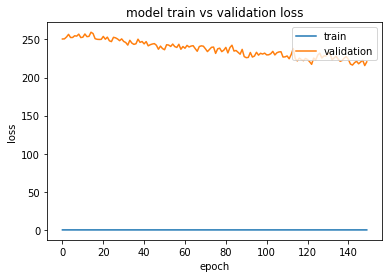

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((3, 1)))
LSTMModel.add(LSTM(64))
LSTMModel.add(Dense(8, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'][150:])
plt.plot(history.history['val_loss'][150:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Use less cells

Epoch 1/300
229/229 [==============================] - 3s 5ms/step - loss: 419.5894 - root_mean_squared_error: 20.4839 - val_loss: 8957.5244 - val_root_mean_squared_error: 94.6442
Epoch 2/300
229/229 [==============================] - 1s 3ms/step - loss: 341.4517 - root_mean_squared_error: 18.4784 - val_loss: 7899.4033 - val_root_mean_squared_error: 88.8786
Epoch 3/300
229/229 [==============================] - 1s 3ms/step - loss: 258.4064 - root_mean_squared_error: 16.0750 - val_loss: 6830.4546 - val_root_mean_squared_error: 82.6466
Epoch 4/300
229/229 [==============================] - 1s 5ms/step - loss: 195.8529 - root_mean_squared_error: 13.9947 - val_loss: 5918.6323 - val_root_mean_squared_error: 76.9326
Epoch 5/300
229/229 [==============================] - 1s 6ms/step - loss: 145.0772 - root_mean_squared_error: 12.0448 - val_loss: 5068.4927 - val_root_mean_squared_error: 71.1933
Epoch 6/300
229/229 [==============================] - 1s 3ms/step - loss: 104.4266 - root_mean_squa

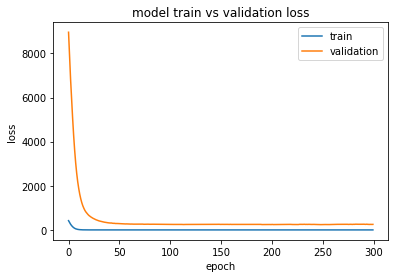

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((3, 1)))
LSTMModel.add(LSTM(16))
LSTMModel.add(Dense(8, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Using more recent data

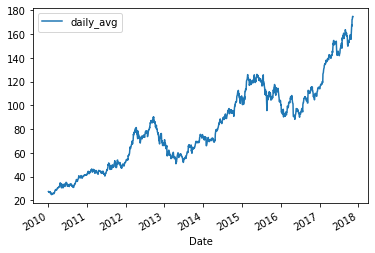

In [ ]:
recent_applev3_df = applev3_df
recent_applev3_df = recent_applev3_df[recent_applev3_df['Date'].str.contains('201')]
recent_applev3_df.index = pd.to_datetime(recent_applev3_df['Date'], format = '%m/%d/%Y')
recent_applev3_df = recent_applev3_df[['daily_avg']]

recent_applev3_df.plot()

In [ ]:
X1, y1 = df_to_X_y(recent_applev3_df, 10)
X1.shape, y1.shape

((1970, 10, 1, 1), (1970, 1))

In [ ]:
## Train test val split
X_train1, y_train1 = X1[:1500], y1[:1500]
X_val1, y_val1 = X1[1500:1700], y1[1500:1700]
X_test1, y_test1 = X1[1700:], y1[1700:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1500, 10, 1, 1),
 (1500, 1),
 (200, 10, 1, 1),
 (200, 1),
 (270, 10, 1, 1),
 (270, 1))

Epoch 1/100
47/47 [==============================] - 5s 23ms/step - loss: 5626.9312 - root_mean_squared_error: 75.0129 - val_loss: 9922.7275 - val_root_mean_squared_error: 99.6129 - lr: 5.0000e-04
Epoch 2/100
47/47 [==============================] - 0s 9ms/step - loss: 5586.6084 - root_mean_squared_error: 74.7436 - val_loss: 9863.6191 - val_root_mean_squared_error: 99.3158 - lr: 5.0000e-04
Epoch 3/100
47/47 [==============================] - 0s 10ms/step - loss: 5510.9307 - root_mean_squared_error: 74.2356 - val_loss: 9713.1230 - val_root_mean_squared_error: 98.5552 - lr: 5.0000e-04
Epoch 4/100
47/47 [==============================] - 0s 9ms/step - loss: 5292.8647 - root_mean_squared_error: 72.7521 - val_loss: 9175.5918 - val_root_mean_squared_error: 95.7893 - lr: 5.0000e-04
Epoch 5/100
47/47 [==============================] - 0s 11ms/step - loss: 4814.4326 - root_mean_squared_error: 69.3861 - val_loss: 8364.8740 - val_root_mean_squared_error: 91.4597 - lr: 5.0000e-04
Epoch 6/100
47/47

47/47 [==============================] - 6s 124ms/step - loss: 197.3638 - root_mean_squared_error: 14.0486 - val_loss: 279.4828 - val_root_mean_squared_error: 16.7177 - lr: 5.0000e-04
Epoch 30/100
43/47 [==========================>...] - ETA: 0s - loss: 175.3877 - root_mean_squared_error: 13.2434

47/47 [==============================] - 6s 122ms/step - loss: 170.8424 - root_mean_squared_error: 13.0707 - val_loss: 222.4782 - val_root_mean_squared_error: 14.9157 - lr: 5.0000e-04
Epoch 31/100
41/47 [=========================>....] - ETA: 0s - loss: 149.3165 - root_mean_squared_error: 12.2195

47/47 [==============================] - 6s 141ms/step - loss: 147.9816 - root_mean_squared_error: 12.1648 - val_loss: 175.7582 - val_root_mean_squared_error: 13.2574 - lr: 5.0000e-04
Epoch 32/100
41/47 [=========================>....] - ETA: 0s - loss: 132.2923 - root_mean_squared_error: 11.5018

47/47 [==============================] - 5s 116ms/step - loss: 128.0878 - root_mean_squared_error: 11.3176 - val_loss: 137.4110 - val_root_mean_squared_error: 11.7222 - lr: 5.0000e-04
Epoch 33/100
43/47 [==========================>...] - ETA: 0s - loss: 109.2534 - root_mean_squared_error: 10.4524

47/47 [==============================] - 7s 142ms/step - loss: 110.8032 - root_mean_squared_error: 10.5263 - val_loss: 107.8415 - val_root_mean_squared_error: 10.3847 - lr: 5.0000e-04
Epoch 34/100
47/47 [==============================] - ETA: 0s - loss: 95.7678 - root_mean_squared_error: 9.7861

47/47 [==============================] - 6s 131ms/step - loss: 95.7678 - root_mean_squared_error: 9.7861 - val_loss: 84.3362 - val_root_mean_squared_error: 9.1835 - lr: 5.0000e-04
Epoch 35/100
45/47 [===========================>..] - ETA: 0s - loss: 83.1124 - root_mean_squared_error: 9.1166

47/47 [==============================] - 6s 120ms/step - loss: 82.7561 - root_mean_squared_error: 9.0970 - val_loss: 66.4690 - val_root_mean_squared_error: 8.1529 - lr: 5.0000e-04
Epoch 36/100
47/47 [==============================] - ETA: 0s - loss: 71.5656 - root_mean_squared_error: 8.4596

47/47 [==============================] - 5s 118ms/step - loss: 71.5656 - root_mean_squared_error: 8.4596 - val_loss: 51.6636 - val_root_mean_squared_error: 7.1877 - lr: 5.0000e-04
Epoch 37/100
42/47 [=========================>....] - ETA: 0s - loss: 62.2118 - root_mean_squared_error: 7.8874

47/47 [==============================] - 7s 143ms/step - loss: 61.7941 - root_mean_squared_error: 7.8609 - val_loss: 40.4225 - val_root_mean_squared_error: 6.3579 - lr: 5.0000e-04
Epoch 38/100
42/47 [=========================>....] - ETA: 0s - loss: 52.0136 - root_mean_squared_error: 7.2120

47/47 [==============================] - 6s 125ms/step - loss: 53.1866 - root_mean_squared_error: 7.2929 - val_loss: 31.5001 - val_root_mean_squared_error: 5.6125 - lr: 5.0000e-04
Epoch 39/100
46/47 [============================>.] - ETA: 0s - loss: 45.6134 - root_mean_squared_error: 6.7538

47/47 [==============================] - 6s 125ms/step - loss: 45.9252 - root_mean_squared_error: 6.7768 - val_loss: 24.5931 - val_root_mean_squared_error: 4.9591 - lr: 5.0000e-04
Epoch 40/100
45/47 [===========================>..] - ETA: 0s - loss: 40.3633 - root_mean_squared_error: 6.3532

47/47 [==============================] - 6s 140ms/step - loss: 39.6668 - root_mean_squared_error: 6.2982 - val_loss: 19.3950 - val_root_mean_squared_error: 4.4040 - lr: 5.0000e-04
Epoch 41/100
42/47 [=========================>....] - ETA: 0s - loss: 36.1704 - root_mean_squared_error: 6.0142

47/47 [==============================] - 5s 119ms/step - loss: 34.3290 - root_mean_squared_error: 5.8591 - val_loss: 15.2758 - val_root_mean_squared_error: 3.9084 - lr: 5.0000e-04
Epoch 42/100
42/47 [=========================>....] - ETA: 0s - loss: 30.1175 - root_mean_squared_error: 5.4879

47/47 [==============================] - 5s 115ms/step - loss: 29.7378 - root_mean_squared_error: 5.4532 - val_loss: 12.5881 - val_root_mean_squared_error: 3.5480 - lr: 5.0000e-04
Epoch 43/100
41/47 [=========================>....] - ETA: 0s - loss: 26.8699 - root_mean_squared_error: 5.1836

47/47 [==============================] - 7s 145ms/step - loss: 25.9702 - root_mean_squared_error: 5.0961 - val_loss: 12.1987 - val_root_mean_squared_error: 3.4927 - lr: 5.0000e-04
Epoch 44/100
43/47 [==========================>...] - ETA: 0s - loss: 22.0080 - root_mean_squared_error: 4.6913

47/47 [==============================] - 6s 124ms/step - loss: 22.7208 - root_mean_squared_error: 4.7666 - val_loss: 8.6595 - val_root_mean_squared_error: 2.9427 - lr: 5.0000e-04
Epoch 45/100
46/47 [============================>.] - ETA: 0s - loss: 19.8801 - root_mean_squared_error: 4.4587

47/47 [==============================] - 6s 121ms/step - loss: 20.0695 - root_mean_squared_error: 4.4799 - val_loss: 8.1984 - val_root_mean_squared_error: 2.8633 - lr: 5.0000e-04
Epoch 46/100
44/47 [===========================>..] - ETA: 0s - loss: 17.2969 - root_mean_squared_error: 4.1590

47/47 [==============================] - 7s 142ms/step - loss: 17.7140 - root_mean_squared_error: 4.2088 - val_loss: 6.2620 - val_root_mean_squared_error: 2.5024 - lr: 5.0000e-04
Epoch 47/100
47/47 [==============================] - 0s 9ms/step - loss: 15.8272 - root_mean_squared_error: 3.9783 - val_loss: 8.6288 - val_root_mean_squared_error: 2.9375 - lr: 5.0000e-04
Epoch 48/100
41/47 [=========================>....] - ETA: 0s - loss: 14.3463 - root_mean_squared_error: 3.7877

47/47 [==============================] - 5s 117ms/step - loss: 14.1227 - root_mean_squared_error: 3.7580 - val_loss: 4.9928 - val_root_mean_squared_error: 2.2345 - lr: 5.0000e-04
Epoch 49/100
44/47 [===========================>..] - ETA: 0s - loss: 12.6228 - root_mean_squared_error: 3.5529

47/47 [==============================] - 6s 123ms/step - loss: 12.6555 - root_mean_squared_error: 3.5575 - val_loss: 4.3626 - val_root_mean_squared_error: 2.0887 - lr: 5.0000e-04
Epoch 50/100
47/47 [==============================] - 0s 10ms/step - loss: 11.3438 - root_mean_squared_error: 3.3681 - val_loss: 5.4833 - val_root_mean_squared_error: 2.3416 - lr: 5.0000e-04
Epoch 51/100
42/47 [=========================>....] - ETA: 0s - loss: 10.1535 - root_mean_squared_error: 3.1865

47/47 [==============================] - 7s 148ms/step - loss: 10.1951 - root_mean_squared_error: 3.1930 - val_loss: 4.1172 - val_root_mean_squared_error: 2.0291 - lr: 5.0000e-04
Epoch 52/100
41/47 [=========================>....] - ETA: 0s - loss: 9.5000 - root_mean_squared_error: 3.0822

47/47 [==============================] - 6s 120ms/step - loss: 9.1386 - root_mean_squared_error: 3.0230 - val_loss: 4.0177 - val_root_mean_squared_error: 2.0044 - lr: 5.0000e-04
Epoch 53/100
47/47 [==============================] - ETA: 0s - loss: 8.5220 - root_mean_squared_error: 2.9192

47/47 [==============================] - 5s 119ms/step - loss: 8.5220 - root_mean_squared_error: 2.9192 - val_loss: 3.4386 - val_root_mean_squared_error: 1.8544 - lr: 5.0000e-04
Epoch 54/100
47/47 [==============================] - 0s 9ms/step - loss: 7.4979 - root_mean_squared_error: 2.7382 - val_loss: 3.6178 - val_root_mean_squared_error: 1.9020 - lr: 5.0000e-04
Epoch 55/100
47/47 [==============================] - ETA: 0s - loss: 6.8811 - root_mean_squared_error: 2.6232

47/47 [==============================] - 6s 138ms/step - loss: 6.8811 - root_mean_squared_error: 2.6232 - val_loss: 3.2578 - val_root_mean_squared_error: 1.8049 - lr: 5.0000e-04
Epoch 56/100
45/47 [===========================>..] - ETA: 0s - loss: 6.1899 - root_mean_squared_error: 2.4880

47/47 [==============================] - 6s 125ms/step - loss: 6.1203 - root_mean_squared_error: 2.4739 - val_loss: 3.1989 - val_root_mean_squared_error: 1.7885 - lr: 5.0000e-04
Epoch 57/100
47/47 [==============================] - 1s 11ms/step - loss: 5.6286 - root_mean_squared_error: 2.3725 - val_loss: 3.3676 - val_root_mean_squared_error: 1.8351 - lr: 5.0000e-04
Epoch 58/100
42/47 [=========================>....] - ETA: 0s - loss: 5.0138 - root_mean_squared_error: 2.2392

47/47 [==============================] - 6s 123ms/step - loss: 4.9932 - root_mean_squared_error: 2.2346 - val_loss: 2.9182 - val_root_mean_squared_error: 1.7083 - lr: 5.0000e-04
Epoch 59/100
47/47 [==============================] - 0s 9ms/step - loss: 4.5737 - root_mean_squared_error: 2.1386 - val_loss: 3.6719 - val_root_mean_squared_error: 1.9162 - lr: 5.0000e-04
Epoch 60/100
43/47 [==========================>...] - ETA: 0s - loss: 4.0284 - root_mean_squared_error: 2.0071

47/47 [==============================] - 5s 118ms/step - loss: 4.0267 - root_mean_squared_error: 2.0067 - val_loss: 2.4152 - val_root_mean_squared_error: 1.5541 - lr: 5.0000e-04
Epoch 61/100
42/47 [=========================>....] - ETA: 0s - loss: 3.5212 - root_mean_squared_error: 1.8765

47/47 [==============================] - 7s 142ms/step - loss: 3.5600 - root_mean_squared_error: 1.8868 - val_loss: 2.2516 - val_root_mean_squared_error: 1.5005 - lr: 5.0000e-04
Epoch 62/100
47/47 [==============================] - 0s 10ms/step - loss: 3.2313 - root_mean_squared_error: 1.7976 - val_loss: 2.6971 - val_root_mean_squared_error: 1.6423 - lr: 5.0000e-04
Epoch 63/100
47/47 [==============================] - 0s 10ms/step - loss: 3.0817 - root_mean_squared_error: 1.7555 - val_loss: 2.6501 - val_root_mean_squared_error: 1.6279 - lr: 5.0000e-04
Epoch 64/100
41/47 [=========================>....] - ETA: 0s - loss: 2.6425 - root_mean_squared_error: 1.6256

47/47 [==============================] - 5s 118ms/step - loss: 2.7584 - root_mean_squared_error: 1.6608 - val_loss: 2.1097 - val_root_mean_squared_error: 1.4525 - lr: 5.0000e-04
Epoch 65/100
47/47 [==============================] - 1s 11ms/step - loss: 2.5683 - root_mean_squared_error: 1.6026 - val_loss: 2.2045 - val_root_mean_squared_error: 1.4848 - lr: 5.0000e-04
Epoch 66/100
47/47 [==============================] - 0s 10ms/step - loss: 2.3583 - root_mean_squared_error: 1.5357 - val_loss: 2.4618 - val_root_mean_squared_error: 1.5690 - lr: 5.0000e-04
Epoch 67/100
47/47 [==============================] - 1s 11ms/step - loss: 2.2543 - root_mean_squared_error: 1.5014 - val_loss: 2.4324 - val_root_mean_squared_error: 1.5596 - lr: 5.0000e-04
Epoch 68/100
43/47 [==========================>...] - ETA: 0s - loss: 2.2104 - root_mean_squared_error: 1.4867

47/47 [==============================] - 6s 123ms/step - loss: 2.2007 - root_mean_squared_error: 1.4835 - val_loss: 2.0487 - val_root_mean_squared_error: 1.4313 - lr: 5.0000e-04
Epoch 69/100
47/47 [==============================] - 0s 10ms/step - loss: 2.1025 - root_mean_squared_error: 1.4500 - val_loss: 2.1909 - val_root_mean_squared_error: 1.4802 - lr: 5.0000e-04
Epoch 70/100
47/47 [==============================] - 0s 10ms/step - loss: 2.0060 - root_mean_squared_error: 1.4163 - val_loss: 2.3186 - val_root_mean_squared_error: 1.5227 - lr: 5.0000e-04
Epoch 71/100
44/47 [===========================>..] - ETA: 0s - loss: 1.9681 - root_mean_squared_error: 1.4029

47/47 [==============================] - 7s 147ms/step - loss: 1.9459 - root_mean_squared_error: 1.3950 - val_loss: 1.9917 - val_root_mean_squared_error: 1.4113 - lr: 5.0000e-04
Epoch 72/100
47/47 [==============================] - 1s 11ms/step - loss: 1.8340 - root_mean_squared_error: 1.3543 - val_loss: 2.1796 - val_root_mean_squared_error: 1.4764 - lr: 5.0000e-04
Epoch 73/100
47/47 [==============================] - 0s 10ms/step - loss: 1.8211 - root_mean_squared_error: 1.3495 - val_loss: 2.1909 - val_root_mean_squared_error: 1.4802 - lr: 5.0000e-04
Epoch 74/100
47/47 [==============================] - 0s 10ms/step - loss: 1.8369 - root_mean_squared_error: 1.3553 - val_loss: 2.1388 - val_root_mean_squared_error: 1.4625 - lr: 5.0000e-04
Epoch 75/100
47/47 [==============================] - 0s 9ms/step - loss: 1.7287 - root_mean_squared_error: 1.3148 - val_loss: 2.0502 - val_root_mean_squared_error: 1.4318 - lr: 5.0000e-04
Epoch 76/100
45/47 [===========================>..] - ETA: 0s -

47/47 [==============================] - 6s 123ms/step - loss: 1.7490 - root_mean_squared_error: 1.3225 - val_loss: 1.9098 - val_root_mean_squared_error: 1.3820 - lr: 5.0000e-04
Epoch 77/100
47/47 [==============================] - 0s 10ms/step - loss: 1.7556 - root_mean_squared_error: 1.3250 - val_loss: 2.2319 - val_root_mean_squared_error: 1.4940 - lr: 5.0000e-04
Epoch 78/100
47/47 [==============================] - 0s 9ms/step - loss: 1.7217 - root_mean_squared_error: 1.3121 - val_loss: 1.9673 - val_root_mean_squared_error: 1.4026 - lr: 5.0000e-04
Epoch 79/100
47/47 [==============================] - 0s 10ms/step - loss: 1.7501 - root_mean_squared_error: 1.3229 - val_loss: 2.3974 - val_root_mean_squared_error: 1.5484 - lr: 5.0000e-04
Epoch 80/100
41/47 [=========================>....] - ETA: 0s - loss: 1.6853 - root_mean_squared_error: 1.2982

47/47 [==============================] - 6s 119ms/step - loss: 1.6928 - root_mean_squared_error: 1.3011 - val_loss: 1.8516 - val_root_mean_squared_error: 1.3607 - lr: 5.0000e-04
Epoch 81/100
47/47 [==============================] - 1s 11ms/step - loss: 1.5390 - root_mean_squared_error: 1.2406 - val_loss: 2.1199 - val_root_mean_squared_error: 1.4560 - lr: 5.0000e-04
Epoch 82/100
47/47 [==============================] - 1s 11ms/step - loss: 1.5691 - root_mean_squared_error: 1.2526 - val_loss: 1.8969 - val_root_mean_squared_error: 1.3773 - lr: 5.0000e-04
Epoch 83/100
47/47 [==============================] - 1s 11ms/step - loss: 1.5215 - root_mean_squared_error: 1.2335 - val_loss: 1.9147 - val_root_mean_squared_error: 1.3837 - lr: 5.0000e-04
Epoch 84/100
47/47 [==============================] - 1s 11ms/step - loss: 1.4845 - root_mean_squared_error: 1.2184 - val_loss: 1.9319 - val_root_mean_squared_error: 1.3899 - lr: 5.0000e-04
Epoch 85/100
47/47 [==============================] - 1s 11ms/

47/47 [==============================] - 7s 145ms/step - loss: 1.4574 - root_mean_squared_error: 1.2072 - val_loss: 1.7843 - val_root_mean_squared_error: 1.3358 - lr: 5.0000e-04
Epoch 93/100
47/47 [==============================] - 0s 10ms/step - loss: 1.3748 - root_mean_squared_error: 1.1725 - val_loss: 1.8120 - val_root_mean_squared_error: 1.3461 - lr: 5.0000e-04
Epoch 94/100
47/47 [==============================] - 0s 10ms/step - loss: 1.3756 - root_mean_squared_error: 1.1729 - val_loss: 2.0476 - val_root_mean_squared_error: 1.4309 - lr: 5.0000e-04
Epoch 95/100
47/47 [==============================] - 0s 10ms/step - loss: 1.3190 - root_mean_squared_error: 1.1485 - val_loss: 1.7901 - val_root_mean_squared_error: 1.3379 - lr: 5.0000e-04
Epoch 96/100
47/47 [==============================] - 0s 11ms/step - loss: 1.3385 - root_mean_squared_error: 1.1569 - val_loss: 1.8130 - val_root_mean_squared_error: 1.3465 - lr: 5.0000e-04
Epoch 97/100
46/47 [============================>.] - ETA: 0s 

47/47 [==============================] - 6s 121ms/step - loss: 1.3212 - root_mean_squared_error: 1.1494 - val_loss: 1.7636 - val_root_mean_squared_error: 1.3280 - lr: 5.0000e-04
Epoch 98/100
43/47 [==========================>...] - ETA: 0s - loss: 1.1876 - root_mean_squared_error: 1.0897

47/47 [==============================] - 6s 120ms/step - loss: 1.2794 - root_mean_squared_error: 1.1311 - val_loss: 1.7536 - val_root_mean_squared_error: 1.3242 - lr: 5.0000e-04
Epoch 99/100
47/47 [==============================] - 0s 9ms/step - loss: 1.3553 - root_mean_squared_error: 1.1642 - val_loss: 1.7726 - val_root_mean_squared_error: 1.3314 - lr: 5.0000e-04
Epoch 100/100
47/47 [==============================] - 0s 9ms/step - loss: 1.3125 - root_mean_squared_error: 1.1457 - val_loss: 1.8231 - val_root_mean_squared_error: 1.3502 - lr: 5.0000e-04


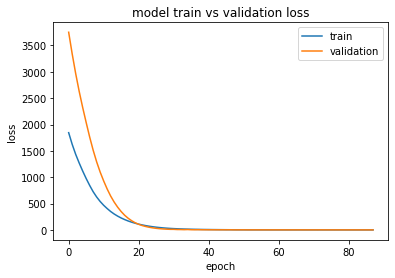

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((10, 1)))
LSTMModel.add(LSTM(64))
LSTMModel.add(Dense(8, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[LSTMcp, reduce_lr])
plt.plot(history.history['loss'][12:])
plt.plot(history.history['val_loss'][12:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
train_predictions = LSTMModel.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1.flatten()})
train_results

47/47 [==============================] - 1s 4ms/step


Train Predictions    Actuals
0             26.659210   27.08100
1             26.898991   27.26725
2             27.118628   26.92100
3             26.852112   25.90600
4             25.969782   25.95800
...                 ...        ...
1495         104.014427  104.45000
1496         104.400673  103.08250
1497         103.017174  103.96750
1498         103.947777  103.91750
1499         103.836014  102.08000

[1500 rows x 2 columns]

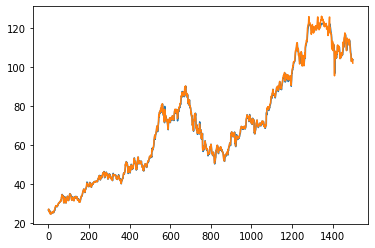

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [ ]:
val_predictions = LSTMModel.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1.flatten()})
val_results

7/7 [==============================] - 0s 4ms/step


Val Predictions    Actuals
0         101.994469   99.97425
1          99.986717  100.30050
2         100.487389   97.11800
3          96.967911   94.27475
4          93.960838   94.20050
..               ...        ...
195       112.616066  114.78000
196       114.036217  114.90750
197       114.481560  114.29750
198       114.192833  115.25000
199       114.836678  114.93250

[200 rows x 2 columns]

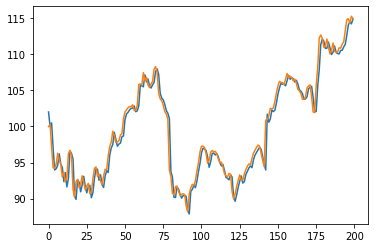

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results

9/9 [==============================] - 0s 4ms/step


Test Predictions   Actuals
0          114.814857  115.3725
1          115.129265  114.0575
2          114.294266  114.4725
3          114.355736  114.2175
4          114.179863  114.9275
..                ...       ...
265        123.252449  172.7100
266        123.252205  173.8175
267        123.252083  174.7400
268        123.251884  174.4275
269        123.251450  174.8575

[270 rows x 2 columns]

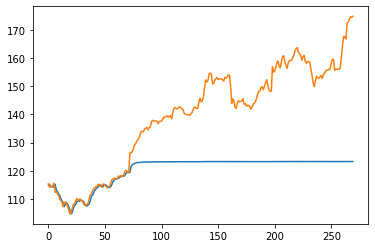

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## Reducing epochs to 30

Epoch 1/30
47/47 [==============================] - 3s 15ms/step - loss: 5321.8525 - root_mean_squared_error: 72.9510 - val_loss: 9272.3896 - val_root_mean_squared_error: 96.2933
Epoch 2/30
47/47 [==============================] - 0s 4ms/step - loss: 4915.6440 - root_mean_squared_error: 70.1117 - val_loss: 8503.3535 - val_root_mean_squared_error: 92.2136
Epoch 3/30
47/47 [==============================] - 0s 4ms/step - loss: 3958.9717 - root_mean_squared_error: 62.9204 - val_loss: 6370.3442 - val_root_mean_squared_error: 79.8144
Epoch 4/30
47/47 [==============================] - 0s 5ms/step - loss: 2826.8533 - root_mean_squared_error: 53.1682 - val_loss: 5061.6748 - val_root_mean_squared_error: 71.1454
Epoch 5/30
47/47 [==============================] - 0s 4ms/step - loss: 2074.0549 - root_mean_squared_error: 45.5418 - val_loss: 3817.1968 - val_root_mean_squared_error: 61.7835
Epoch 6/30
47/47 [==============================] - 0s 4ms/step - loss: 1521.6565 - root_mean_squared_error: 

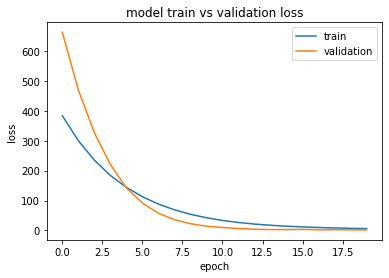

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((3, 1)))
LSTMModel.add(LSTM(64))
LSTMModel.add(Dense(8, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=30, callbacks=[LSTMcp])
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

7/7 [==============================] - 0s 4ms/step


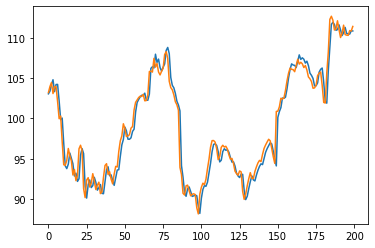

In [ ]:
val_predictions = LSTMModel.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1.flatten()})
val_results
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

9/9 [==============================] - 0s 2ms/step


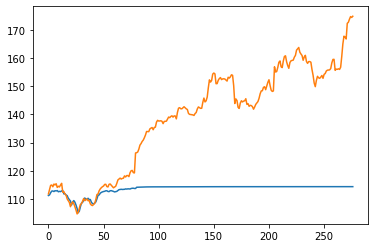

In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## Using Different layers

Epoch 1/300
47/47 [==============================] - 3s 15ms/step - loss: 5458.8662 - root_mean_squared_error: 73.8841 - val_loss: 9635.7109 - val_root_mean_squared_error: 98.1617
Epoch 2/300
47/47 [==============================] - 0s 4ms/step - loss: 5346.7744 - root_mean_squared_error: 73.1216 - val_loss: 9446.3496 - val_root_mean_squared_error: 97.1923
Epoch 3/300
47/47 [==============================] - 0s 4ms/step - loss: 5230.2988 - root_mean_squared_error: 72.3208 - val_loss: 9309.9834 - val_root_mean_squared_error: 96.4883
Epoch 4/300
47/47 [==============================] - 0s 4ms/step - loss: 5124.6973 - root_mean_squared_error: 71.5870 - val_loss: 9148.8291 - val_root_mean_squared_error: 95.6495
Epoch 5/300
47/47 [==============================] - 0s 4ms/step - loss: 4990.7856 - root_mean_squared_error: 70.6455 - val_loss: 8944.0029 - val_root_mean_squared_error: 94.5727
Epoch 6/300
47/47 [==============================] - 0s 4ms/step - loss: 4816.6685 - root_mean_squared_e

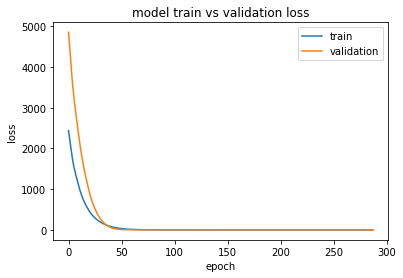

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((3, 1)))
LSTMModel.add(LSTM(64))
LSTMModel.add(Dense(32, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'][12:])
plt.plot(history.history['val_loss'][12:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

9/9 [==============================] - 0s 2ms/step


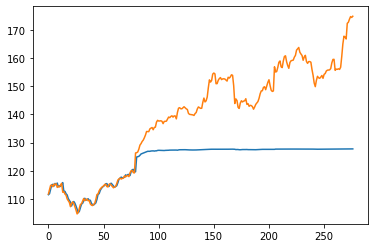

In [ ]:
test_predictions = LSTMModel.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## First Diff model

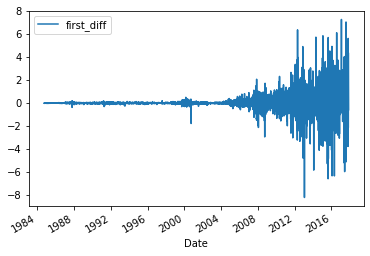

In [ ]:
temp_applev3_df = applev3_df
temp_applev3_df.index = pd.to_datetime(temp_applev3_df['Date'], format = '%m/%d/%Y')
temp_applev3_df = temp_applev3_df[['first_diff']]

temp_applev3_df.plot()

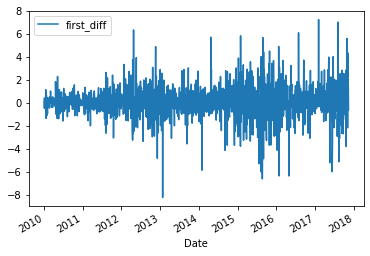

In [ ]:
recent_applev3_df = applev3_df
recent_applev3_df = recent_applev3_df[recent_applev3_df['Date'].str.contains('201')]
recent_applev3_df.index = pd.to_datetime(recent_applev3_df['Date'], format = '%m/%d/%Y')
recent_applev3_df = recent_applev3_df[['first_diff']]

recent_applev3_df.plot()

In [ ]:
WINDOW_SIZE = 5
X2, y2 = df_to_X_y(recent_applev3_df, WINDOW_SIZE)
X2.shape, y2.shape

((1975, 5, 1, 1), (1975, 1))

In [ ]:
## Train test val split
X_train2, y_train2 = X2[:1500], y2[:1500]
X_val2, y_val2 = X2[1500:1700], y2[1500:1700]
X_test2, y_test2 = X2[1700:], y2[1700:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((1500, 5, 1, 1),
 (1500, 1),
 (200, 5, 1, 1),
 (200, 1),
 (275, 5, 1, 1),
 (275, 1))

In [ ]:
LSTMModelFD = Sequential()
LSTMModelFD.add(InputLayer((5, 1)))
LSTMModelFD.add(LSTM(64))
LSTMModelFD.add(Dense(8, 'linear'))
LSTMModelFD.add(Dense(1, 'linear'))

LSTMModelFD.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTMcp = ModelCheckpoint('LSTMModelFD/', save_best_only=True)
LSTMModelFD.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Epoch 1/500
47/47 [==============================] - 0s 8ms/step - loss: 0.0979 - root_mean_squared_error: 0.3128 - val_loss: 7.6204 - val_root_mean_squared_error: 2.7605
Epoch 2/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0986 - root_mean_squared_error: 0.3141 - val_loss: 7.7028 - val_root_mean_squared_error: 2.7754
Epoch 3/500
47/47 [==============================] - 0s 7ms/step - loss: 0.1043 - root_mean_squared_error: 0.3230 - val_loss: 7.8670 - val_root_mean_squared_error: 2.8048
Epoch 4/500
47/47 [==============================] - 0s 7ms/step - loss: 0.1017 - root_mean_squared_error: 0.3189 - val_loss: 7.8340 - val_root_mean_squared_error: 2.7989
Epoch 5/500
47/47 [==============================] - 0s 6ms/step - loss: 0.1003 - root_mean_squared_error: 0.3167 - val_loss: 7.7172 - val_root_mean_squared_error: 2.7780
Epoch 6/500
47/47 [==============================] - 0s 7ms/step - loss: 0.1034 - root_mean_squared_error: 0.3215 - val_loss: 7.6299 - val_root_m

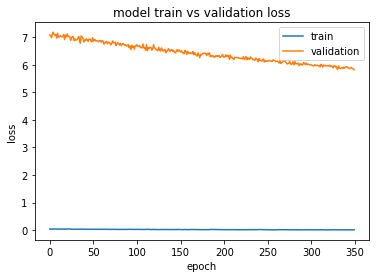

In [ ]:
history = LSTMModelFD.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=500, callbacks=[LSTMcp], batch_size=32)
plt.plot(history.history['loss'][150:])
plt.plot(history.history['val_loss'][150:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
train_predictions = LSTMModelFD.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2.flatten()})
train_results

47/47 [==============================] - 1s 3ms/step


Train Predictions  Actuals
0             -0.167587   -0.240
1             -0.354908   -0.306
2              0.407123    0.377
3             -0.074349   -0.159
4             -0.524009   -0.449
...                 ...      ...
1495          -2.189627   -2.280
1496          -2.569923   -2.820
1497           1.247871    1.240
1498           0.010084   -0.100
1499           1.293129    1.330

[1500 rows x 2 columns]

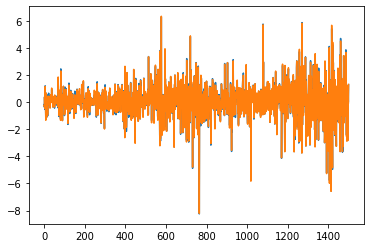

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [ ]:
val_predictions = LSTMModelFD.predict(X_val2).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val2.flatten()})
val_results

7/7 [==============================] - 0s 3ms/step


Val Predictions  Actuals
0           0.646099    -0.55
1           3.363512    -1.18
2           2.188420     1.85
3           3.389451    -1.36
4          -0.100173    -1.97
..               ...      ...
195         0.285270     0.45
196        -0.284607     0.05
197         0.453062     0.84
198        -0.743227     0.17
199         0.731839     1.94

[200 rows x 2 columns]

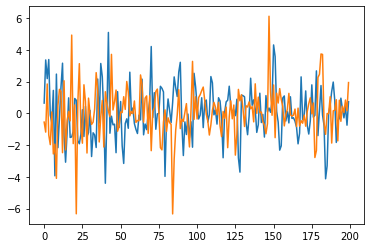

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [ ]:
test_predictions = LSTMModelFD.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2.flatten()})
test_results

9/9 [==============================] - 0s 6ms/step


Test Predictions  Actuals
0           -1.326863     0.25
1            0.387136     1.02
2            0.017092    -0.36
3            1.094113     0.64
4           -0.490256    -0.07
..                ...      ...
270         -1.210452     1.75
271          0.456039     0.55
272          0.137439     1.43
273          2.420988    -0.36
274         -1.004544    -0.58

[275 rows x 2 columns]

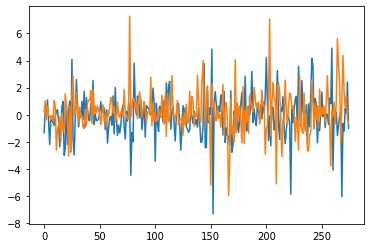

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

In [ ]:
train_predictions = LSTMModelFD.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2.flatten()})
train_results

47/47 [==============================] - 1s 3ms/step


Train Predictions  Actuals
0             -0.167587   -0.240
1             -0.354908   -0.306
2              0.407123    0.377
3             -0.074349   -0.159
4             -0.524009   -0.449
...                 ...      ...
1495          -2.189627   -2.280
1496          -2.569923   -2.820
1497           1.247871    1.240
1498           0.010084   -0.100
1499           1.293129    1.330

[1500 rows x 2 columns]

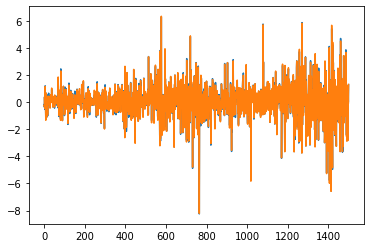

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [ ]:
val_predictions = LSTMModelFD.predict(X_val2).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val2.flatten()})
val_results

7/7 [==============================] - 0s 3ms/step


Val Predictions  Actuals
0           0.646099    -0.55
1           3.363512    -1.18
2           2.188420     1.85
3           3.389451    -1.36
4          -0.100173    -1.97
..               ...      ...
195         0.285270     0.45
196        -0.284607     0.05
197         0.453062     0.84
198        -0.743227     0.17
199         0.731839     1.94

[200 rows x 2 columns]

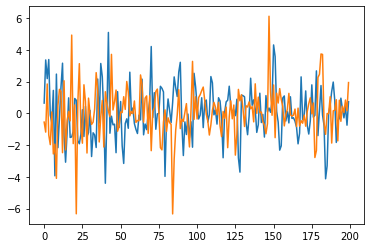

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [ ]:
test_predictions = LSTMModelFD.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2.flatten()})
test_results

9/9 [==============================] - 0s 6ms/step


Test Predictions  Actuals
0           -1.326863     0.25
1            0.387136     1.02
2            0.017092    -0.36
3            1.094113     0.64
4           -0.490256    -0.07
..                ...      ...
270         -1.210452     1.75
271          0.456039     0.55
272          0.137439     1.43
273          2.420988    -0.36
274         -1.004544    -0.58

[275 rows x 2 columns]

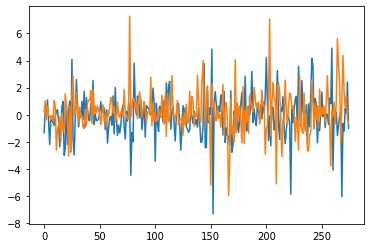

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

Trying a higher learning rate

Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.1196

47/47 [==============================] - 9s 125ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196 - val_loss: 5.8607 - val_root_mean_squared_error: 2.4209
Epoch 2/500
45/47 [===========================>..] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1135

47/47 [==============================] - 5s 111ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 5.8388 - val_root_mean_squared_error: 2.4164
Epoch 3/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 5.8560 - val_root_mean_squared_error: 2.4199
Epoch 4/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 5.8806 - val_root_mean_squared_error: 2.4250
Epoch 5/500
46/47 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.1092

47/47 [==============================] - 6s 123ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 5.8259 - val_root_mean_squared_error: 2.4137
Epoch 6/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 5.9107 - val_root_mean_squared_error: 2.4312
Epoch 7/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 5.8403 - val_root_mean_squared_error: 2.4167
Epoch 8/500
45/47 [===========================>..] - ETA: 0s - loss: 0.0191 - root_mean_squared_error: 0.1382

47/47 [==============================] - 5s 115ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 5.7718 - val_root_mean_squared_error: 2.4025
Epoch 9/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 5.7805 - val_root_mean_squared_error: 2.4043
Epoch 10/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 5.8191 - val_root_mean_squared_error: 2.4123
Epoch 11/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - val_loss: 5.7771 - val_root_mean_squared_error: 2.4036
Epoch 12/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 5.7727 - val_root_mean_squared_error: 2.4026
Epoch 13/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0094 - root_mean_squared_error: 0.0967 - val_loss: 5.8282 - val_root_mean_sq

47/47 [==============================] - 7s 150ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 5.7448 - val_root_mean_squared_error: 2.3968
Epoch 18/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998 - val_loss: 5.9048 - val_root_mean_squared_error: 2.4300
Epoch 19/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 5.7728 - val_root_mean_squared_error: 2.4027
Epoch 20/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 5.8079 - val_root_mean_squared_error: 2.4100
Epoch 21/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 5.7827 - val_root_mean_squared_error: 2.4047
Epoch 22/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 5.7745 - val_root_mean_s

47/47 [==============================] - 5s 112ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 5.7386 - val_root_mean_squared_error: 2.3955
Epoch 33/500
47/47 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1053

47/47 [==============================] - 6s 123ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053 - val_loss: 5.7216 - val_root_mean_squared_error: 2.3920
Epoch 34/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 5.7774 - val_root_mean_squared_error: 2.4036
Epoch 35/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0106 - root_mean_squared_error: 0.1032 - val_loss: 5.8023 - val_root_mean_squared_error: 2.4088
Epoch 36/500
45/47 [===========================>..] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1137

47/47 [==============================] - 5s 113ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 5.6809 - val_root_mean_squared_error: 2.3835
Epoch 37/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 5.7390 - val_root_mean_squared_error: 2.3956
Epoch 38/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 5.7318 - val_root_mean_squared_error: 2.3941
Epoch 39/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 5.7641 - val_root_mean_squared_error: 2.4009
Epoch 40/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 5.7206 - val_root_mean_squared_error: 2.3918
Epoch 41/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 5.7113 - val_root_mean_s

47/47 [==============================] - 6s 124ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 5.6711 - val_root_mean_squared_error: 2.3814
Epoch 54/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 5.7188 - val_root_mean_squared_error: 2.3914
Epoch 55/500
47/47 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0936

47/47 [==============================] - 5s 113ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 5.6704 - val_root_mean_squared_error: 2.3813
Epoch 56/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998 - val_loss: 5.7284 - val_root_mean_squared_error: 2.3934
Epoch 57/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 5.6835 - val_root_mean_squared_error: 2.3840
Epoch 58/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 5.6960 - val_root_mean_squared_error: 2.3866
Epoch 59/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 5.6734 - val_root_mean_squared_error: 2.3819
Epoch 60/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 5.6934 - val_root_mean_s

47/47 [==============================] - 5s 114ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 5.6550 - val_root_mean_squared_error: 2.3780
Epoch 65/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 5.6819 - val_root_mean_squared_error: 2.3837
Epoch 66/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 5.6814 - val_root_mean_squared_error: 2.3836
Epoch 67/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 5.6973 - val_root_mean_squared_error: 2.3869
Epoch 68/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 5.7109 - val_root_mean_squared_error: 2.3898
Epoch 69/500
43/47 [==========================>...] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1053

47/47 [==============================] - 6s 129ms/step - loss: 0.0111 - root_mean_squared_error: 0.1056 - val_loss: 5.6470 - val_root_mean_squared_error: 2.3763
Epoch 70/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 5.6876 - val_root_mean_squared_error: 2.3849
Epoch 71/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 5.7017 - val_root_mean_squared_error: 2.3878
Epoch 72/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 5.6650 - val_root_mean_squared_error: 2.3801
Epoch 73/500
44/47 [===========================>..] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1017

47/47 [==============================] - 5s 114ms/step - loss: 0.0104 - root_mean_squared_error: 0.1017 - val_loss: 5.6129 - val_root_mean_squared_error: 2.3691
Epoch 74/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015 - val_loss: 5.6391 - val_root_mean_squared_error: 2.3747
Epoch 75/500
46/47 [============================>.] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0992

47/47 [==============================] - 7s 147ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995 - val_loss: 5.6076 - val_root_mean_squared_error: 2.3680
Epoch 76/500
47/47 [==============================] - 1s 12ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 5.6398 - val_root_mean_squared_error: 2.3748
Epoch 77/500
47/47 [==============================] - 1s 13ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 5.6269 - val_root_mean_squared_error: 2.3721
Epoch 78/500
47/47 [==============================] - 1s 12ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 5.6443 - val_root_mean_squared_error: 2.3758
Epoch 79/500
47/47 [==============================] - 1s 12ms/step - loss: 0.0103 - root_mean_squared_error: 0.1017 - val_loss: 5.6770 - val_root_mean_squared_error: 2.3826
Epoch 80/500
47/47 [==============================] - 0s 10ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 5.6905 - val_root_m

47/47 [==============================] - 5s 115ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 5.5883 - val_root_mean_squared_error: 2.3640
Epoch 82/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 5.6969 - val_root_mean_squared_error: 2.3868
Epoch 83/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0116 - root_mean_squared_error: 0.1075 - val_loss: 5.6129 - val_root_mean_squared_error: 2.3692
Epoch 84/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 5.6095 - val_root_mean_squared_error: 2.3684
Epoch 85/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 5.6392 - val_root_mean_squared_error: 2.3747
Epoch 86/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089 - val_loss: 5.6491 - val_root_mean_s

47/47 [==============================] - 6s 125ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 5.5512 - val_root_mean_squared_error: 2.3561
Epoch 88/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 5.5823 - val_root_mean_squared_error: 2.3627
Epoch 89/500
38/47 [=======================>......] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1086

47/47 [==============================] - 5s 115ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085 - val_loss: 5.5398 - val_root_mean_squared_error: 2.3537
Epoch 90/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 5.6282 - val_root_mean_squared_error: 2.3724
Epoch 91/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 5.6261 - val_root_mean_squared_error: 2.3719
Epoch 92/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 5.6128 - val_root_mean_squared_error: 2.3691
Epoch 93/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 5.6230 - val_root_mean_squared_error: 2.3713
Epoch 94/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 5.5947 - val_root_mean_s

47/47 [==============================] - 5s 113ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 5.5213 - val_root_mean_squared_error: 2.3497
Epoch 109/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 5.5352 - val_root_mean_squared_error: 2.3527
Epoch 110/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 5.5734 - val_root_mean_squared_error: 2.3608
Epoch 111/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 5.5261 - val_root_mean_squared_error: 2.3508
Epoch 112/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930 - val_loss: 5.6099 - val_root_mean_squared_error: 2.3685
Epoch 113/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 5.5719 - val_root_m

47/47 [==============================] - 6s 128ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976 - val_loss: 5.5035 - val_root_mean_squared_error: 2.3460
Epoch 125/500
40/47 [========================>.....] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0999

47/47 [==============================] - 5s 112ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 5.5006 - val_root_mean_squared_error: 2.3453
Epoch 126/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 5.5438 - val_root_mean_squared_error: 2.3545
Epoch 127/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 5.5314 - val_root_mean_squared_error: 2.3519
Epoch 128/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 5.5428 - val_root_mean_squared_error: 2.3543
Epoch 129/500
47/47 [==============================] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0897

47/47 [==============================] - 6s 126ms/step - loss: 0.0080 - root_mean_squared_error: 0.0897 - val_loss: 5.4780 - val_root_mean_squared_error: 2.3405
Epoch 130/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 5.5550 - val_root_mean_squared_error: 2.3569
Epoch 131/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 5.4973 - val_root_mean_squared_error: 2.3446
Epoch 132/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 5.5890 - val_root_mean_squared_error: 2.3641
Epoch 133/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0089 - root_mean_squared_error: 0.0946 - val_loss: 5.5219 - val_root_mean_squared_error: 2.3499
Epoch 134/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 5.5547 - val_root_m

47/47 [==============================] - 5s 114ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 5.4613 - val_root_mean_squared_error: 2.3369
Epoch 142/500
41/47 [=========================>....] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1029

47/47 [==============================] - 5s 111ms/step - loss: 0.0105 - root_mean_squared_error: 0.1022 - val_loss: 5.4590 - val_root_mean_squared_error: 2.3365
Epoch 143/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 5.5354 - val_root_mean_squared_error: 2.3527
Epoch 144/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 5.4934 - val_root_mean_squared_error: 2.3438
Epoch 145/500
40/47 [========================>.....] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1036

47/47 [==============================] - 6s 125ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 5.4417 - val_root_mean_squared_error: 2.3328
Epoch 146/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 5.5313 - val_root_mean_squared_error: 2.3519
Epoch 147/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 5.4906 - val_root_mean_squared_error: 2.3432
Epoch 148/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 5.5090 - val_root_mean_squared_error: 2.3471
Epoch 149/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 5.5653 - val_root_mean_squared_error: 2.3591
Epoch 150/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 5.4801 - val_root_m

47/47 [==============================] - 5s 113ms/step - loss: 0.0079 - root_mean_squared_error: 0.0892 - val_loss: 5.4114 - val_root_mean_squared_error: 2.3262
Epoch 156/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 5.5180 - val_root_mean_squared_error: 2.3490
Epoch 157/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 5.4438 - val_root_mean_squared_error: 2.3332
Epoch 158/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 5.4818 - val_root_mean_squared_error: 2.3413
Epoch 159/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 5.4856 - val_root_mean_squared_error: 2.3421
Epoch 160/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 5.4744 - val_root_m

47/47 [==============================] - 6s 124ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 5.4040 - val_root_mean_squared_error: 2.3247
Epoch 179/500
40/47 [========================>.....] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0988

47/47 [==============================] - 5s 110ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 5.3756 - val_root_mean_squared_error: 2.3185
Epoch 180/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 5.4493 - val_root_mean_squared_error: 2.3344
Epoch 181/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 5.4010 - val_root_mean_squared_error: 2.3240
Epoch 182/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 5.4807 - val_root_mean_squared_error: 2.3411
Epoch 183/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 5.3967 - val_root_mean_squared_error: 2.3231
Epoch 184/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995 - val_loss: 5.3806 - val_root_m

47/47 [==============================] - 6s 124ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 5.3479 - val_root_mean_squared_error: 2.3125
Epoch 190/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 5.4487 - val_root_mean_squared_error: 2.3342
Epoch 191/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 5.4383 - val_root_mean_squared_error: 2.3320
Epoch 192/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 5.4491 - val_root_mean_squared_error: 2.3343
Epoch 193/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 5.4650 - val_root_mean_squared_error: 2.3377
Epoch 194/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 5.4259 - val_root_m

47/47 [==============================] - 5s 114ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 5.3434 - val_root_mean_squared_error: 2.3116
Epoch 204/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 5.3860 - val_root_mean_squared_error: 2.3208
Epoch 205/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 5.3657 - val_root_mean_squared_error: 2.3164
Epoch 206/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 5.4348 - val_root_mean_squared_error: 2.3313
Epoch 207/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 5.3955 - val_root_mean_squared_error: 2.3228
Epoch 208/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 5.4151 - val_root_m

47/47 [==============================] - 6s 123ms/step - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 5.3418 - val_root_mean_squared_error: 2.3112
Epoch 210/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0090 - root_mean_squared_error: 0.0951 - val_loss: 5.3985 - val_root_mean_squared_error: 2.3235
Epoch 211/500
40/47 [========================>.....] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0890

47/47 [==============================] - 5s 112ms/step - loss: 0.0081 - root_mean_squared_error: 0.0897 - val_loss: 5.2967 - val_root_mean_squared_error: 2.3014
Epoch 212/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 5.4007 - val_root_mean_squared_error: 2.3240
Epoch 213/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 5.3625 - val_root_mean_squared_error: 2.3157
Epoch 214/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0109 - root_mean_squared_error: 0.1046 - val_loss: 5.3084 - val_root_mean_squared_error: 2.3040
Epoch 215/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 5.3828 - val_root_mean_squared_error: 2.3201
Epoch 216/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 5.3799 - val_root_m

47/47 [==============================] - 5s 112ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 5.2853 - val_root_mean_squared_error: 2.2990
Epoch 226/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 5.3798 - val_root_mean_squared_error: 2.3194
Epoch 227/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 5.3411 - val_root_mean_squared_error: 2.3111
Epoch 228/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 5.3019 - val_root_mean_squared_error: 2.3026
Epoch 229/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 5.3897 - val_root_mean_squared_error: 2.3216
Epoch 230/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 5.3422 - val_root_m

47/47 [==============================] - 6s 128ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 5.2441 - val_root_mean_squared_error: 2.2900
Epoch 255/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 5.3275 - val_root_mean_squared_error: 2.3081
Epoch 256/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0079 - root_mean_squared_error: 0.0886 - val_loss: 5.2876 - val_root_mean_squared_error: 2.2995
Epoch 257/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 5.2588 - val_root_mean_squared_error: 2.2932
Epoch 258/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 5.3007 - val_root_mean_squared_error: 2.3023
Epoch 259/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 5.3026 - val_root_m

47/47 [==============================] - 5s 111ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 5.2278 - val_root_mean_squared_error: 2.2864
Epoch 262/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 5.3141 - val_root_mean_squared_error: 2.3052
Epoch 263/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 5.3012 - val_root_mean_squared_error: 2.3024
Epoch 264/500
47/47 [==============================] - 0s 8ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 5.2764 - val_root_mean_squared_error: 2.2970
Epoch 265/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 5.3095 - val_root_mean_squared_error: 2.3042
Epoch 266/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 5.2785 - val_root_m

47/47 [==============================] - 6s 125ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 5.2038 - val_root_mean_squared_error: 2.2812
Epoch 279/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 5.2432 - val_root_mean_squared_error: 2.2898
Epoch 280/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 5.2710 - val_root_mean_squared_error: 2.2959
Epoch 281/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 5.2623 - val_root_mean_squared_error: 2.2940
Epoch 282/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 5.2459 - val_root_mean_squared_error: 2.2904
Epoch 283/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 5.2423 - val_root_m

47/47 [==============================] - 5s 114ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 5.1834 - val_root_mean_squared_error: 2.2767
Epoch 308/500
46/47 [============================>.] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0998

47/47 [==============================] - 6s 124ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 5.1792 - val_root_mean_squared_error: 2.2758
Epoch 309/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 5.2905 - val_root_mean_squared_error: 2.3001
Epoch 310/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 5.2064 - val_root_mean_squared_error: 2.2818
Epoch 311/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 5.1811 - val_root_mean_squared_error: 2.2762
Epoch 312/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0087 - root_mean_squared_error: 0.0930 - val_loss: 5.2576 - val_root_mean_squared_error: 2.2929
Epoch 313/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 5.2459 - val_root_m

47/47 [==============================] - 5s 114ms/step - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 5.1616 - val_root_mean_squared_error: 2.2719
Epoch 333/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 5.2350 - val_root_mean_squared_error: 2.2880
Epoch 334/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 5.2371 - val_root_mean_squared_error: 2.2885
Epoch 335/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 5.2348 - val_root_mean_squared_error: 2.2880
Epoch 336/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 5.2217 - val_root_mean_squared_error: 2.2851
Epoch 337/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 5.1911 - val_root_m

47/47 [==============================] - 5s 113ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 5.1462 - val_root_mean_squared_error: 2.2685
Epoch 343/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 5.1760 - val_root_mean_squared_error: 2.2751
Epoch 344/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 5.1616 - val_root_mean_squared_error: 2.2719
Epoch 345/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 5.1772 - val_root_mean_squared_error: 2.2753
Epoch 346/500
47/47 [==============================] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0862

47/47 [==============================] - 6s 127ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 5.1417 - val_root_mean_squared_error: 2.2675
Epoch 347/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930 - val_loss: 5.2015 - val_root_mean_squared_error: 2.2807
Epoch 348/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935 - val_loss: 5.1485 - val_root_mean_squared_error: 2.2690
Epoch 349/500
47/47 [==============================] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0992

47/47 [==============================] - 5s 111ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 5.1371 - val_root_mean_squared_error: 2.2665
Epoch 350/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977 - val_loss: 5.2215 - val_root_mean_squared_error: 2.2851
Epoch 351/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 5.1569 - val_root_mean_squared_error: 2.2709
Epoch 352/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 5.1671 - val_root_mean_squared_error: 2.2731
Epoch 353/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 5.2004 - val_root_mean_squared_error: 2.2804
Epoch 354/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 5.1698 - val_root_m

47/47 [==============================] - 6s 128ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 5.1260 - val_root_mean_squared_error: 2.2641
Epoch 356/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 5.1685 - val_root_mean_squared_error: 2.2734
Epoch 357/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 5.1778 - val_root_mean_squared_error: 2.2755
Epoch 358/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 5.1627 - val_root_mean_squared_error: 2.2722
Epoch 359/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 5.1583 - val_root_mean_squared_error: 2.2712
Epoch 360/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 5.1634 - val_root_m

47/47 [==============================] - 5s 115ms/step - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 5.0801 - val_root_mean_squared_error: 2.2539
Epoch 368/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 5.1212 - val_root_mean_squared_error: 2.2630
Epoch 369/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 5.1284 - val_root_mean_squared_error: 2.2646
Epoch 370/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 5.1449 - val_root_mean_squared_error: 2.2682
Epoch 371/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 5.1469 - val_root_mean_squared_error: 2.2687
Epoch 372/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 5.1490 - val_root_m

47/47 [==============================] - 5s 111ms/step - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 5.0616 - val_root_mean_squared_error: 2.2498
Epoch 390/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 5.1415 - val_root_mean_squared_error: 2.2675
Epoch 391/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 5.1148 - val_root_mean_squared_error: 2.2616
Epoch 392/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 5.1493 - val_root_mean_squared_error: 2.2692
Epoch 393/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 5.0840 - val_root_mean_squared_error: 2.2548
Epoch 394/500
47/47 [==============================] - 0s 6ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 5.1377 - val_root_m

47/47 [==============================] - 6s 129ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 5.0535 - val_root_mean_squared_error: 2.2480
Epoch 421/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 5.0927 - val_root_mean_squared_error: 2.2567
Epoch 422/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 5.1202 - val_root_mean_squared_error: 2.2628
Epoch 423/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 5.0792 - val_root_mean_squared_error: 2.2537
Epoch 424/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 5.1450 - val_root_mean_squared_error: 2.2683
Epoch 425/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 5.0636 - val_root_m

47/47 [==============================] - 5s 112ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 5.0300 - val_root_mean_squared_error: 2.2428
Epoch 433/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 5.0855 - val_root_mean_squared_error: 2.2551
Epoch 434/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 5.0663 - val_root_mean_squared_error: 2.2508
Epoch 435/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 5.0488 - val_root_mean_squared_error: 2.2470
Epoch 436/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 5.0589 - val_root_mean_squared_error: 2.2492
Epoch 437/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 5.0593 - val_root_m

47/47 [==============================] - 6s 126ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 5.0220 - val_root_mean_squared_error: 2.2410
Epoch 454/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 5.0678 - val_root_mean_squared_error: 2.2512
Epoch 455/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 5.0571 - val_root_mean_squared_error: 2.2488
Epoch 456/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 5.0244 - val_root_mean_squared_error: 2.2415
Epoch 457/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 5.0261 - val_root_mean_squared_error: 2.2419
Epoch 458/500
47/47 [==============================] - 0s 8ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 5.0481 - val_root_m

47/47 [==============================] - 5s 115ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 4.9882 - val_root_mean_squared_error: 2.2334
Epoch 460/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 5.0344 - val_root_mean_squared_error: 2.2438
Epoch 461/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 5.0138 - val_root_mean_squared_error: 2.2391
Epoch 462/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 5.0750 - val_root_mean_squared_error: 2.2528
Epoch 463/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 5.0790 - val_root_mean_squared_error: 2.2537
Epoch 464/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 5.0598 - val_root_m

47/47 [==============================] - 6s 124ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 4.9799 - val_root_mean_squared_error: 2.2316
Epoch 481/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 5.0259 - val_root_mean_squared_error: 2.2419
Epoch 482/500
47/47 [==============================] - 0s 8ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 5.0442 - val_root_mean_squared_error: 2.2459
Epoch 483/500
44/47 [===========================>..] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0764

47/47 [==============================] - 5s 114ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 4.9603 - val_root_mean_squared_error: 2.2272
Epoch 484/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 5.0029 - val_root_mean_squared_error: 2.2367
Epoch 485/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 5.0034 - val_root_mean_squared_error: 2.2368
Epoch 486/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 4.9915 - val_root_mean_squared_error: 2.2342
Epoch 487/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 5.0035 - val_root_mean_squared_error: 2.2368
Epoch 488/500
47/47 [==============================] - 0s 7ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 5.0097 - val_root_m

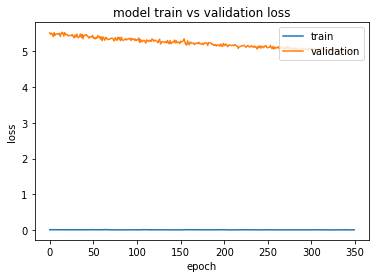

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModelFD/', save_best_only=True)
LSTMModelFD.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = LSTMModelFD.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=500, callbacks=[LSTMcp], batch_size=32)
plt.plot(history.history['loss'][150:])
plt.plot(history.history['val_loss'][150:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
train_predictions = LSTMModelFD.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2.flatten()})
train_results

47/47 [==============================] - 1s 2ms/step


Train Predictions  Actuals
0             -0.212145   -0.240
1             -0.247482   -0.306
2              0.332926    0.377
3             -0.203629   -0.159
4             -0.545648   -0.449
...                 ...      ...
1495          -2.315554   -2.280
1496          -2.822810   -2.820
1497           1.265190    1.240
1498          -0.085824   -0.100
1499           1.512723    1.330

[1500 rows x 2 columns]

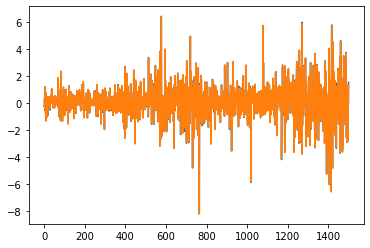

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [ ]:
val_predictions = LSTMModelFD.predict(X_val2).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val2.flatten()})
val_results

7/7 [==============================] - 0s 3ms/step


Val Predictions  Actuals
0          -0.049968    -0.55
1           2.970487    -1.18
2           1.942375     1.85
3           2.807920    -1.36
4          -0.238611    -1.97
..               ...      ...
195         0.024138     0.45
196        -0.015950     0.05
197         0.223308     0.84
198        -0.760390     0.17
199         0.917376     1.94

[200 rows x 2 columns]

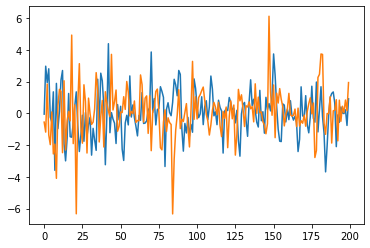

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [ ]:
test_predictions = LSTMModelFD.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2.flatten()})
test_results

9/9 [==============================] - 0s 3ms/step


Test Predictions  Actuals
0           -0.769708     0.25
1            0.664638     1.02
2            0.426554    -0.36
3            0.418149     0.64
4           -0.494388    -0.07
..                ...      ...
270         -1.120181     1.75
271          0.525152     0.55
272         -0.063586     1.43
273          2.020182    -0.36
274         -0.462956    -0.58

[275 rows x 2 columns]

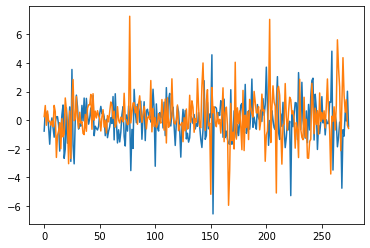

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## First diff with dropout



10% dropout

In [ ]:
LSTMModelFD = Sequential()
LSTMModelFD.add(InputLayer((5, 1)))
LSTMModelFD.add(LSTM(64, dropout=0.1))
LSTMModelFD.add(Dense(8, 'linear'))
LSTMModelFD.add(Dense(1, 'linear'))

LSTMModelFD.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
39/47 [=======================>......] - ETA: 0s - loss: 1.4982 - root_mean_squared_error: 1.2240

47/47 [==============================] - 9s 144ms/step - loss: 1.4795 - root_mean_squared_error: 1.2164 - val_loss: 2.3726 - val_root_mean_squared_error: 1.5403
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 1.4772 - root_mean_squared_error: 1.2154

47/47 [==============================] - 6s 122ms/step - loss: 1.4772 - root_mean_squared_error: 1.2154 - val_loss: 2.3705 - val_root_mean_squared_error: 1.5396
Epoch 3/500
46/47 [============================>.] - ETA: 0s - loss: 1.4636 - root_mean_squared_error: 1.2098

47/47 [==============================] - 9s 185ms/step - loss: 1.4741 - root_mean_squared_error: 1.2141 - val_loss: 2.3694 - val_root_mean_squared_error: 1.5393
Epoch 4/500
43/47 [==========================>...] - ETA: 0s - loss: 1.4949 - root_mean_squared_error: 1.2227

47/47 [==============================] - 5s 116ms/step - loss: 1.4742 - root_mean_squared_error: 1.2142 - val_loss: 2.3686 - val_root_mean_squared_error: 1.5390
Epoch 5/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4725 - root_mean_squared_error: 1.2135 - val_loss: 2.3688 - val_root_mean_squared_error: 1.5391
Epoch 6/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4717 - root_mean_squared_error: 1.2131 - val_loss: 2.3690 - val_root_mean_squared_error: 1.5391
Epoch 7/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4728 - root_mean_squared_error: 1.2136 - val_loss: 2.3692 - val_root_mean_squared_error: 1.5392
Epoch 8/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4722 - root_mean_squared_error: 1.2133 - val_loss: 2.3695 - val_root_mean_squared_error: 1.5393
Epoch 9/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4710 - root_mean_squared_error: 1.2129 - val_loss: 2.3693 - val_root_mean_square

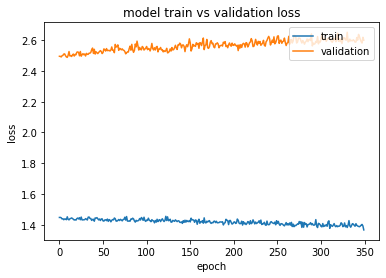

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModelFD/', save_best_only=True)
LSTMModelFD.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

history = LSTMModelFD.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=500, callbacks=[LSTMcp], batch_size=32)
plt.plot(history.history['loss'][150:])
plt.plot(history.history['val_loss'][150:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
train_predictions = LSTMModelFD.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2.flatten()})
train_results

47/47 [==============================] - 1s 2ms/step


Train Predictions  Actuals
0             -0.026063   -0.240
1             -0.016873   -0.306
2              0.008353    0.377
3              0.050141   -0.159
4             -0.014380   -0.449
...                 ...      ...
1495           0.061679   -2.280
1496           0.153823   -2.820
1497           0.444738    1.240
1498           0.336527   -0.100
1499          -0.271073    1.330

[1500 rows x 2 columns]

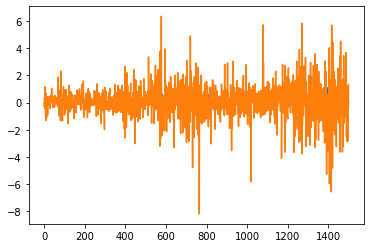

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [ ]:
val_predictions = LSTMModelFD.predict(X_val2).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val2.flatten()})
val_results

7/7 [==============================] - 0s 3ms/step


Val Predictions  Actuals
0          -0.106245    -0.55
1          -0.162070    -1.18
2           0.003125     1.85
3           0.074436    -1.36
4          -0.133121    -1.97
..               ...      ...
195        -0.093338     0.45
196        -0.071192     0.05
197        -0.033825     0.84
198         0.086195     0.17
199         0.134564     1.94

[200 rows x 2 columns]

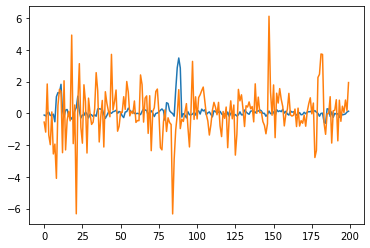

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [ ]:
test_predictions = LSTMModelFD.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2.flatten()})
test_results

9/9 [==============================] - 0s 4ms/step


Test Predictions  Actuals
0            0.274317     0.25
1            0.196515     1.02
2            0.134196    -0.36
3            0.128261     0.64
4           -0.004816    -0.07
..                ...      ...
270         -0.340922     1.75
271         -0.251153     0.55
272          0.020005     1.43
273         -0.367059    -0.36
274         -0.143606    -0.58

[275 rows x 2 columns]

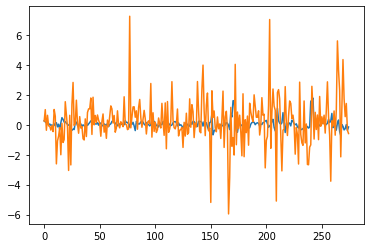

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

30% dropout

In [ ]:
LSTMModelFD = Sequential()
LSTMModelFD.add(InputLayer((5, 1)))
LSTMModelFD.add(LSTM(64, dropout=0.3))
LSTMModelFD.add(Dense(8, 'linear'))
LSTMModelFD.add(Dense(1, 'linear'))

LSTMModelFD.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 1.4285 - root_mean_squared_error: 1.1952

47/47 [==============================] - 8s 127ms/step - loss: 1.4285 - root_mean_squared_error: 1.1952 - val_loss: 2.4643 - val_root_mean_squared_error: 1.5698
Epoch 2/500
40/47 [========================>.....] - ETA: 0s - loss: 1.4307 - root_mean_squared_error: 1.1961

47/47 [==============================] - 6s 132ms/step - loss: 1.4399 - root_mean_squared_error: 1.2000 - val_loss: 2.4570 - val_root_mean_squared_error: 1.5675
Epoch 3/500
47/47 [==============================] - 0s 6ms/step - loss: 1.4636 - root_mean_squared_error: 1.2098 - val_loss: 2.4573 - val_root_mean_squared_error: 1.5676
Epoch 4/500
44/47 [===========================>..] - ETA: 0s - loss: 1.4544 - root_mean_squared_error: 1.2060

47/47 [==============================] - 5s 118ms/step - loss: 1.4444 - root_mean_squared_error: 1.2018 - val_loss: 2.4490 - val_root_mean_squared_error: 1.5649
Epoch 5/500
39/47 [=======================>......] - ETA: 0s - loss: 1.3904 - root_mean_squared_error: 1.1791

47/47 [==============================] - 6s 128ms/step - loss: 1.4539 - root_mean_squared_error: 1.2058 - val_loss: 2.4437 - val_root_mean_squared_error: 1.5632
Epoch 6/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4306 - root_mean_squared_error: 1.1961 - val_loss: 2.4597 - val_root_mean_squared_error: 1.5683
Epoch 7/500
47/47 [==============================] - 0s 6ms/step - loss: 1.4517 - root_mean_squared_error: 1.2049 - val_loss: 2.4622 - val_root_mean_squared_error: 1.5691
Epoch 8/500
47/47 [==============================] - 0s 6ms/step - loss: 1.4247 - root_mean_squared_error: 1.1936 - val_loss: 2.4588 - val_root_mean_squared_error: 1.5681
Epoch 9/500
47/47 [==============================] - 0s 6ms/step - loss: 1.4327 - root_mean_squared_error: 1.1969 - val_loss: 2.4512 - val_root_mean_squared_error: 1.5656
Epoch 10/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4509 - root_mean_squared_error: 1.2046 - val_loss: 2.4467 - val_root_mean_squar

47/47 [==============================] - 5s 115ms/step - loss: 1.4500 - root_mean_squared_error: 1.2042 - val_loss: 2.4413 - val_root_mean_squared_error: 1.5625
Epoch 12/500
47/47 [==============================] - ETA: 0s - loss: 1.4081 - root_mean_squared_error: 1.1866

47/47 [==============================] - 6s 128ms/step - loss: 1.4081 - root_mean_squared_error: 1.1866 - val_loss: 2.4395 - val_root_mean_squared_error: 1.5619
Epoch 13/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4338 - root_mean_squared_error: 1.1974 - val_loss: 2.4526 - val_root_mean_squared_error: 1.5661
Epoch 14/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4152 - root_mean_squared_error: 1.1896 - val_loss: 2.4476 - val_root_mean_squared_error: 1.5645
Epoch 15/500
47/47 [==============================] - 0s 6ms/step - loss: 1.4383 - root_mean_squared_error: 1.1993 - val_loss: 2.4534 - val_root_mean_squared_error: 1.5663
Epoch 16/500
47/47 [==============================] - 0s 6ms/step - loss: 1.4243 - root_mean_squared_error: 1.1934 - val_loss: 2.4555 - val_root_mean_squared_error: 1.5670
Epoch 17/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4261 - root_mean_squared_error: 1.1942 - val_loss: 2.4454 - val_root_mean_s

47/47 [==============================] - 5s 115ms/step - loss: 1.4392 - root_mean_squared_error: 1.1997 - val_loss: 2.4324 - val_root_mean_squared_error: 1.5596
Epoch 103/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4430 - root_mean_squared_error: 1.2012 - val_loss: 2.4499 - val_root_mean_squared_error: 1.5652
Epoch 104/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4452 - root_mean_squared_error: 1.2022 - val_loss: 2.4428 - val_root_mean_squared_error: 1.5630
Epoch 105/500
47/47 [==============================] - 0s 7ms/step - loss: 1.4278 - root_mean_squared_error: 1.1949 - val_loss: 2.4441 - val_root_mean_squared_error: 1.5633
Epoch 106/500
47/47 [==============================] - 0s 6ms/step - loss: 1.4177 - root_mean_squared_error: 1.1907 - val_loss: 2.4496 - val_root_mean_squared_error: 1.5651
Epoch 107/500
47/47 [==============================] - 0s 6ms/step - loss: 1.4395 - root_mean_squared_error: 1.1998 - val_loss: 2.4435 - val_root_m

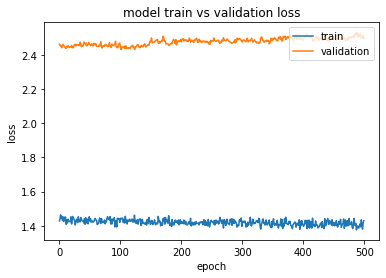

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModelFD/', save_best_only=True)
LSTMModelFD.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

history = LSTMModelFD.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=500, callbacks=[LSTMcp], batch_size=32)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
train_predictions = LSTMModelFD.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2.flatten()})
train_results

47/47 [==============================] - 1s 2ms/step


Train Predictions  Actuals
0             -0.026063   -0.240
1             -0.016873   -0.306
2              0.008353    0.377
3              0.050141   -0.159
4             -0.014380   -0.449
...                 ...      ...
1495           0.061679   -2.280
1496           0.153823   -2.820
1497           0.444738    1.240
1498           0.336527   -0.100
1499          -0.271073    1.330

[1500 rows x 2 columns]

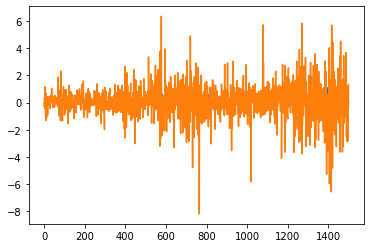

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [ ]:
val_predictions = LSTMModelFD.predict(X_val2).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val2.flatten()})
val_results

7/7 [==============================] - 0s 3ms/step


Val Predictions  Actuals
0          -0.106245    -0.55
1          -0.162070    -1.18
2           0.003125     1.85
3           0.074436    -1.36
4          -0.133121    -1.97
..               ...      ...
195        -0.093338     0.45
196        -0.071192     0.05
197        -0.033825     0.84
198         0.086195     0.17
199         0.134564     1.94

[200 rows x 2 columns]

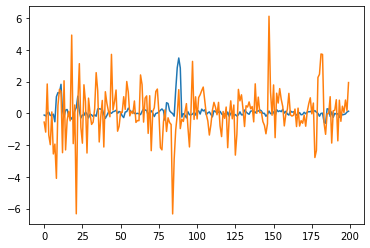

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [ ]:
test_predictions = LSTMModelFD.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2.flatten()})
test_results

9/9 [==============================] - 0s 4ms/step


Test Predictions  Actuals
0            0.274317     0.25
1            0.196515     1.02
2            0.134196    -0.36
3            0.128261     0.64
4           -0.004816    -0.07
..                ...      ...
270         -0.340922     1.75
271         -0.251153     0.55
272          0.020005     1.43
273         -0.367059    -0.36
274         -0.143606    -0.58

[275 rows x 2 columns]

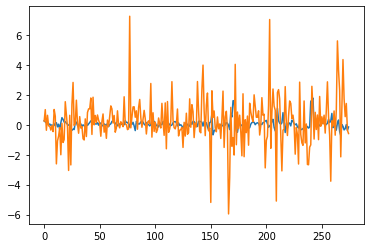

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

Reduce epoch to

In [ ]:
LSTMModelFD = Sequential()
LSTMModelFD.add(InputLayer((5, 1)))
LSTMModelFD.add(LSTM(64, dropout=0.3))
LSTMModelFD.add(Dense(8, 'linear'))
LSTMModelFD.add(Dense(1, 'linear'))

LSTMModelFD.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                16896     
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 1.4781 - root_mean_squared_error: 1.2158

47/47 [==============================] - 9s 142ms/step - loss: 1.4781 - root_mean_squared_error: 1.2158 - val_loss: 2.3986 - val_root_mean_squared_error: 1.5487
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 1.4799 - root_mean_squared_error: 1.2165

47/47 [==============================] - 5s 116ms/step - loss: 1.4799 - root_mean_squared_error: 1.2165 - val_loss: 2.3945 - val_root_mean_squared_error: 1.5474
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: 1.4636 - root_mean_squared_error: 1.2098 - val_loss: 2.3947 - val_root_mean_squared_error: 1.5475
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 1.4804 - root_mean_squared_error: 1.2167

47/47 [==============================] - 6s 131ms/step - loss: 1.4804 - root_mean_squared_error: 1.2167 - val_loss: 2.3911 - val_root_mean_squared_error: 1.5463
Epoch 5/100
39/47 [=======================>......] - ETA: 0s - loss: 1.4543 - root_mean_squared_error: 1.2060

47/47 [==============================] - 5s 118ms/step - loss: 1.4680 - root_mean_squared_error: 1.2116 - val_loss: 2.3896 - val_root_mean_squared_error: 1.5458
Epoch 6/100
47/47 [==============================] - ETA: 0s - loss: 1.4751 - root_mean_squared_error: 1.2145

47/47 [==============================] - 5s 116ms/step - loss: 1.4751 - root_mean_squared_error: 1.2145 - val_loss: 2.3882 - val_root_mean_squared_error: 1.5454
Epoch 7/100
46/47 [============================>.] - ETA: 0s - loss: 1.4825 - root_mean_squared_error: 1.2176

47/47 [==============================] - 6s 134ms/step - loss: 1.4703 - root_mean_squared_error: 1.2126 - val_loss: 2.3863 - val_root_mean_squared_error: 1.5448
Epoch 8/100
47/47 [==============================] - 0s 7ms/step - loss: 1.4685 - root_mean_squared_error: 1.2118 - val_loss: 2.3865 - val_root_mean_squared_error: 1.5448
Epoch 9/100
38/47 [=======================>......] - ETA: 0s - loss: 1.4663 - root_mean_squared_error: 1.2109

47/47 [==============================] - 5s 118ms/step - loss: 1.4739 - root_mean_squared_error: 1.2140 - val_loss: 2.3858 - val_root_mean_squared_error: 1.5446
Epoch 10/100
41/47 [=========================>....] - ETA: 0s - loss: 1.4977 - root_mean_squared_error: 1.2238

47/47 [==============================] - 6s 129ms/step - loss: 1.4729 - root_mean_squared_error: 1.2136 - val_loss: 2.3856 - val_root_mean_squared_error: 1.5445
Epoch 11/100
41/47 [=========================>....] - ETA: 0s - loss: 1.4620 - root_mean_squared_error: 1.2091

47/47 [==============================] - 5s 118ms/step - loss: 1.4739 - root_mean_squared_error: 1.2140 - val_loss: 2.3830 - val_root_mean_squared_error: 1.5437
Epoch 12/100
47/47 [==============================] - ETA: 0s - loss: 1.4714 - root_mean_squared_error: 1.2130

47/47 [==============================] - 5s 117ms/step - loss: 1.4714 - root_mean_squared_error: 1.2130 - val_loss: 2.3826 - val_root_mean_squared_error: 1.5436
Epoch 13/100
38/47 [=======================>......] - ETA: 0s - loss: 1.4914 - root_mean_squared_error: 1.2212

47/47 [==============================] - 6s 130ms/step - loss: 1.4693 - root_mean_squared_error: 1.2121 - val_loss: 2.3823 - val_root_mean_squared_error: 1.5435
Epoch 14/100
47/47 [==============================] - ETA: 0s - loss: 1.4764 - root_mean_squared_error: 1.2151

47/47 [==============================] - 5s 118ms/step - loss: 1.4764 - root_mean_squared_error: 1.2151 - val_loss: 2.3817 - val_root_mean_squared_error: 1.5433
Epoch 15/100
40/47 [========================>.....] - ETA: 0s - loss: 1.4258 - root_mean_squared_error: 1.1941

47/47 [==============================] - 6s 129ms/step - loss: 1.4745 - root_mean_squared_error: 1.2143 - val_loss: 2.3797 - val_root_mean_squared_error: 1.5426
Epoch 16/100
38/47 [=======================>......] - ETA: 0s - loss: 1.4636 - root_mean_squared_error: 1.2098

47/47 [==============================] - 6s 119ms/step - loss: 1.4710 - root_mean_squared_error: 1.2129 - val_loss: 2.3794 - val_root_mean_squared_error: 1.5425
Epoch 17/100
40/47 [========================>.....] - ETA: 0s - loss: 1.3575 - root_mean_squared_error: 1.1651

47/47 [==============================] - 6s 131ms/step - loss: 1.4698 - root_mean_squared_error: 1.2123 - val_loss: 2.3785 - val_root_mean_squared_error: 1.5422
Epoch 18/100
47/47 [==============================] - 0s 6ms/step - loss: 1.4703 - root_mean_squared_error: 1.2126 - val_loss: 2.3788 - val_root_mean_squared_error: 1.5423
Epoch 19/100
39/47 [=======================>......] - ETA: 0s - loss: 1.4906 - root_mean_squared_error: 1.2209

47/47 [==============================] - 5s 118ms/step - loss: 1.4666 - root_mean_squared_error: 1.2110 - val_loss: 2.3775 - val_root_mean_squared_error: 1.5419
Epoch 20/100
47/47 [==============================] - 0s 7ms/step - loss: 1.4696 - root_mean_squared_error: 1.2123 - val_loss: 2.3785 - val_root_mean_squared_error: 1.5422
Epoch 21/100
47/47 [==============================] - 0s 6ms/step - loss: 1.4662 - root_mean_squared_error: 1.2109 - val_loss: 2.3797 - val_root_mean_squared_error: 1.5426
Epoch 22/100
47/47 [==============================] - 0s 7ms/step - loss: 1.4644 - root_mean_squared_error: 1.2101 - val_loss: 2.3801 - val_root_mean_squared_error: 1.5427
Epoch 23/100
47/47 [==============================] - 0s 7ms/step - loss: 1.4702 - root_mean_squared_error: 1.2125 - val_loss: 2.3792 - val_root_mean_squared_error: 1.5425
Epoch 24/100
47/47 [==============================] - 0s 6ms/step - loss: 1.4638 - root_mean_squared_error: 1.2099 - val_loss: 2.3807 - val_root_mean_s

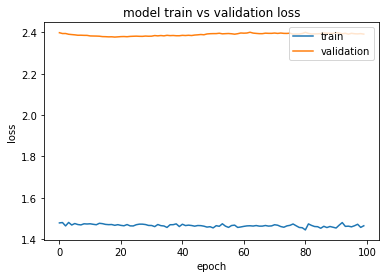

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModelFD/', save_best_only=True)
LSTMModelFD.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

history = LSTMModelFD.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[LSTMcp], batch_size=32)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
train_predictions = LSTMModelFD.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2.flatten()})
train_results

47/47 [==============================] - 1s 2ms/step


Train Predictions  Actuals
0             -0.026063   -0.240
1             -0.016873   -0.306
2              0.008353    0.377
3              0.050141   -0.159
4             -0.014380   -0.449
...                 ...      ...
1495           0.061679   -2.280
1496           0.153823   -2.820
1497           0.444738    1.240
1498           0.336527   -0.100
1499          -0.271073    1.330

[1500 rows x 2 columns]

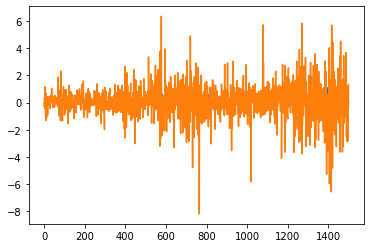

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [ ]:
val_predictions = LSTMModelFD.predict(X_val2).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val2.flatten()})
val_results

7/7 [==============================] - 0s 3ms/step


Val Predictions  Actuals
0          -0.106245    -0.55
1          -0.162070    -1.18
2           0.003125     1.85
3           0.074436    -1.36
4          -0.133121    -1.97
..               ...      ...
195        -0.093338     0.45
196        -0.071192     0.05
197        -0.033825     0.84
198         0.086195     0.17
199         0.134564     1.94

[200 rows x 2 columns]

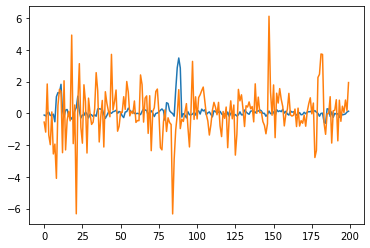

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [ ]:
test_predictions = LSTMModelFD.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2.flatten()})
test_results

9/9 [==============================] - 0s 4ms/step


Test Predictions  Actuals
0            0.274317     0.25
1            0.196515     1.02
2            0.134196    -0.36
3            0.128261     0.64
4           -0.004816    -0.07
..                ...      ...
270         -0.340922     1.75
271         -0.251153     0.55
272          0.020005     1.43
273         -0.367059    -0.36
274         -0.143606    -0.58

[275 rows x 2 columns]

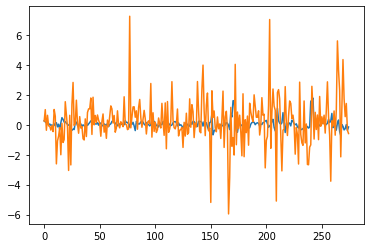

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## Updated Apple dataset

In [ ]:
sheet_id = '1zo8q6rl_HU_gyf9lZy_UGbPev7SiWjmP'

apple_df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")

apple_df.head()

apple_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt',
       'close_lag1', 'close_lag2', 'close_lag3', 'close_lag4', 'close_lag5',
       'close_lag6', 'close_lag7', 'close_lag8', 'close_lag9', 'close_lag10',
       'close_rollmean3', 'close_rollmean5', 'close_rollmean10',
       'close_rollmean30'],
      dtype='object')

In [ ]:
apple_df['10-diff'] = apple_df['close_lag10'] - apple_df['Close']

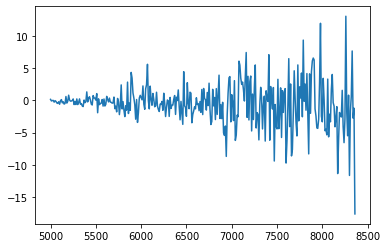

In [ ]:
apple_df['10-diff'][5000::10].plot()

In [ ]:
temp_apple_df = apple_df
temp_apple_df = temp_apple_df[temp_apple_df['Date'].str.contains('201')]
temp_apple_df['7-diff'][::7].plot()
temp_apple_df.shape

KeyError: ignored

In [ ]:
temp_apple_df.index = pd.to_datetime(temp_apple_df['Date'], format = '%Y/%m/%d')
temp_apple_df = temp_apple_df[['7-diff']]

In [ ]:
temp_apple_df[::7]

In [ ]:
X1, y1 = df_to_X_y(temp_apple_df[::7], 3)
X1.shape, y1.shape

((280, 3, 1, 1), (280, 1))

In [ ]:
X_train1, y_train1 = X1[:200], y1[:200]
X_val1, y_val1 = X1[200:240], y1[200:240]
X_test1, y_test1 = X1[240:], y1[240:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((200, 3, 1, 1), (200, 1), (40, 3, 1, 1), (40, 1), (40, 3, 1, 1), (40, 1))

Epoch 1/30
1/7 [===>..........................] - ETA: 16s - loss: 6.3382 - root_mean_squared_error: 2.5176

7/7 [==============================] - 8s 907ms/step - loss: 9.6765 - root_mean_squared_error: 3.1107 - val_loss: 20.2942 - val_root_mean_squared_error: 4.5049
Epoch 2/30
7/7 [==============================] - 0s 9ms/step - loss: 9.6343 - root_mean_squared_error: 3.1039 - val_loss: 20.3182 - val_root_mean_squared_error: 4.5076
Epoch 3/30
7/7 [==============================] - 0s 7ms/step - loss: 9.6106 - root_mean_squared_error: 3.1001 - val_loss: 20.3435 - val_root_mean_squared_error: 4.5104
Epoch 4/30
7/7 [==============================] - 0s 8ms/step - loss: 9.5865 - root_mean_squared_error: 3.0962 - val_loss: 20.3724 - val_root_mean_squared_error: 4.5136
Epoch 5/30
7/7 [==============================] - 0s 8ms/step - loss: 9.5618 - root_mean_squared_error: 3.0922 - val_loss: 20.3976 - val_root_mean_squared_error: 4.5164
Epoch 6/30
7/7 [==============================] - 0s 7ms/step - loss: 9.5470 - root_mean_squared_error: 3.0898 - val_loss: 20.4259 - val_root_mean_squared_error: 4.

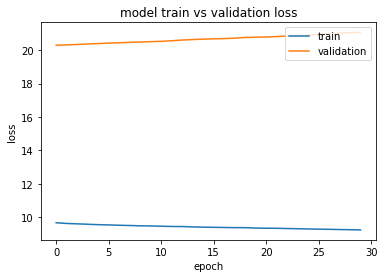

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((3, 1)))
LSTMModel.add(LSTM(64))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])

history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=30, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Normalization of data


In [2]:
sheet_id = '1zo8q6rl_HU_gyf9lZy_UGbPev7SiWjmP'

apple_df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")

apple_df.head()

apple_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt',
       'close_lag1', 'close_lag2', 'close_lag3', 'close_lag4', 'close_lag5',
       'close_lag6', 'close_lag7', 'close_lag8', 'close_lag9', 'close_lag10',
       'close_rollmean3', 'close_rollmean5', 'close_rollmean10',
       'close_rollmean30'],
      dtype='object')

(1980, 21)

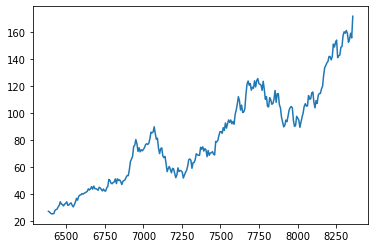

In [3]:
temp_apple_df = apple_df
temp_apple_df = temp_apple_df[temp_apple_df['Date'].str.contains('201')]
close_prices = temp_apple_df['Close']
temp_apple_df['Close'][::7].plot()
temp_apple_df.shape

In [4]:
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)
validation_data_len = math.ceil(len(values) * 0.9)

scaler = MinMaxScaler(feature_range=(-1,1))
train_data = values[0: training_data_len]
validation_data = values[training_data_len : validation_data_len]
test_data = values[validation_data_len:]

train_data = scaler.fit_transform(train_data.reshape(-1,1))
validation_data = scaler.transform(validation_data.reshape(-1,1))
test_data = scaler.transform(test_data.reshape(-1,1))

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
x_val = []
y_val = []

for i in range(60, len(validation_data)):
  x_val.append(validation_data[i-60:i, 0])
  y_val.append(validation_data[i,0])

x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
print(len(y_val))

138


In [6]:
x_test = []
y_test = []

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
  y_test.append(test_data[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [75]:
model = Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dense_14 (Dense)            (None, 25)                2525      
                                                                 
 dense_15 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
1524/1524 [==============================] - 58s 36ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 2/3
1524/1524 [==============================] - 54s 36ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 3/3
1524/1524 [==============================] - 54s 35ms/step - loss: 0.0016 - val_loss: 6.9068e-04


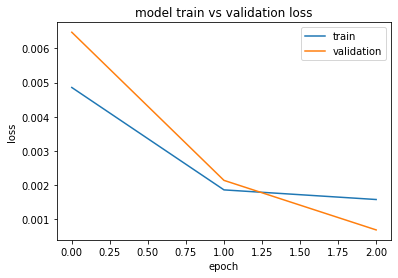

In [76]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), batch_size= 1, epochs=3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [77]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

5/5 [==============================] - 1s 39ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


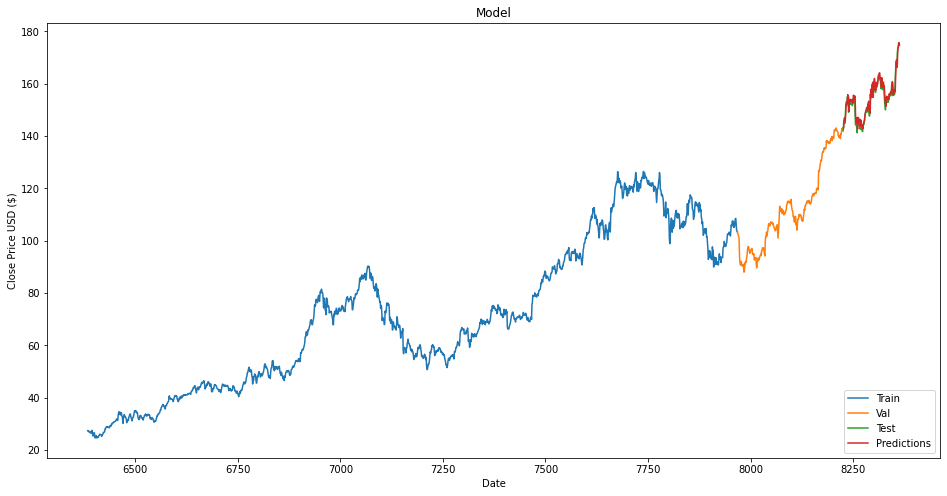

In [78]:
data = temp_apple_df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:validation_data_len + 60]
test = data[validation_data_len + 60:]
test['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation)
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [79]:
rmse = np.sqrt(np.mean(predictions - test['Close'].values)**2)
rmse


0.7624220076851216

In [80]:
# Martingale series
temp = data[validation_data_len + 59:]
temp['Yesterday Close'] = temp['Close'].shift(1)
temp = temp[1:]
martingale_rmse = np.sqrt(np.mean(temp['Yesterday Close'].values - test['Close'].values)**2)
martingale_rmse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.2357971014492753

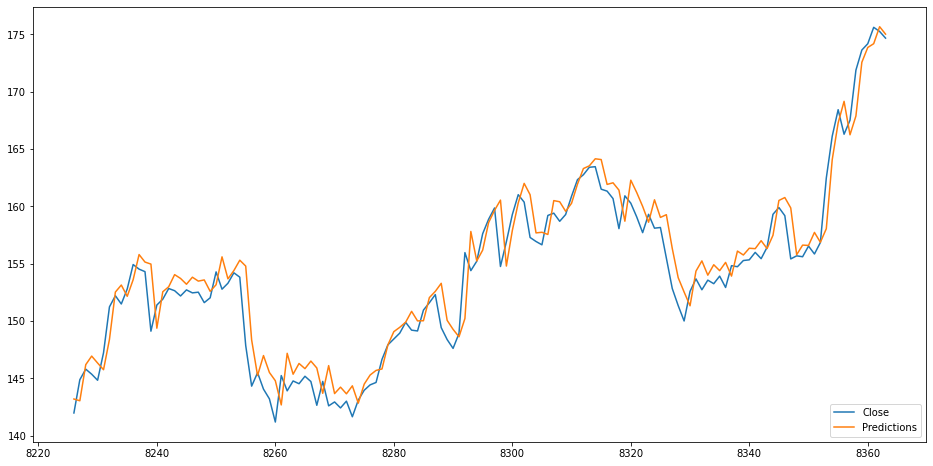

In [81]:
plt.figure(figsize=(16,8))
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='lower right')
plt.show()

Different layers


In [ ]:
model = Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='linear'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 117,025
Trainable params: 117,025
Non-trainable params: 0
_________________________________________________________________


Epoch 1/4
1524/1524 [==============================] - 65s 41ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 2/4
1524/1524 [==============================] - 59s 39ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/4
1524/1524 [==============================] - 60s 40ms/step - loss: 0.0020 - val_loss: 7.8336e-04
Epoch 4/4
1524/1524 [==============================] - 59s 39ms/step - loss: 0.0013 - val_loss: 0.0010


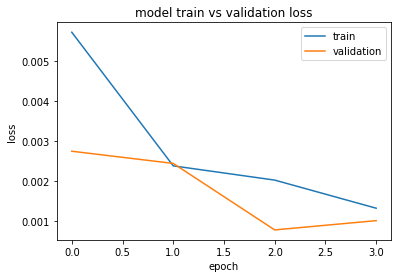

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), batch_size= 1, epochs=4)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
predictions = model.predict(x_test)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
predictions = scaler.inverse_transform(predictions)
rmse

5/5 [==============================] - 1s 37ms/step


0.07051261616130464

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


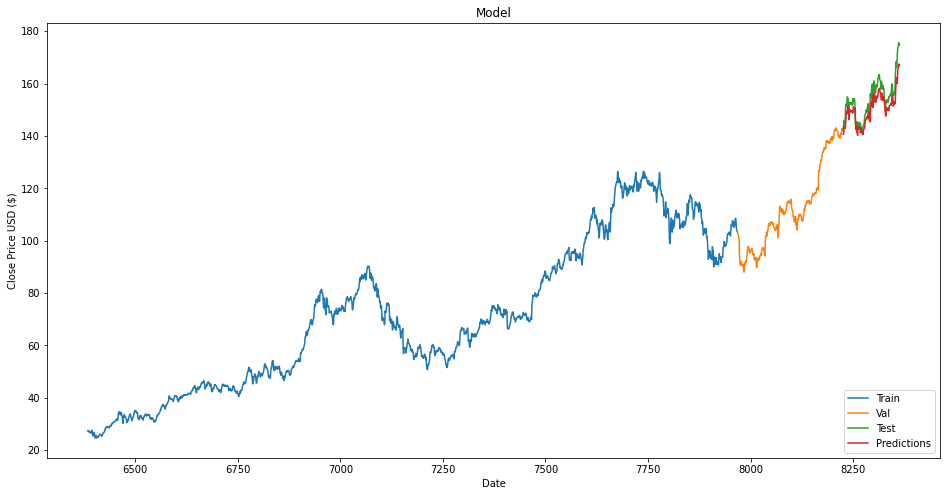

In [ ]:
data = temp_apple_df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:validation_data_len + 60]
test = data[validation_data_len + 60:]
test['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation)
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
## Helper function to format X inputs and y outputs

def df_to_X_y_modified(df, window_size=5):
  X = []
  y = []
  for i in range(len(df)-window_size):
    row = [[a] for a in df[i:i+window_size]]
    X.append(row)
    label = df[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y_modified(scaled_data[::7], 60)


X_train1, y_train = X1[:160], y1[:160]
X_val1, y_val = X1[160:200], y1[160:200]
X_test1, y_test = X1[200:], y1[200:]

x_train = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))
x_test = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))
x_val = np.reshape(X_val1, (X_val1.shape[0], X_val1.shape[1], 1))

X1.shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((223, 60, 1, 1),
 (160, 60, 1),
 (160, 1),
 (40, 60, 1),
 (40, 1),
 (23, 60, 1),
 (23, 1))

In [ ]:
modelcp = ModelCheckpoint('model/', save_best_only=True)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size= 1, epochs=3, callbacks=[modelcp])

Epoch 1/3
160/160 [==============================] - ETA: 0s - loss: 0.0012

160/160 [==============================] - 31s 160ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2/3
160/160 [==============================] - ETA: 0s - loss: 9.9716e-04

160/160 [==============================] - 24s 148ms/step - loss: 9.9716e-04 - val_loss: 9.6167e-04
Epoch 3/3
160/160 [==============================] - 7s 46ms/step - loss: 8.2762e-04 - val_loss: 0.0011


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1/1 [==============================] - 1s 940ms/step


144.0479840256135

In [ ]:
from tensorflow.keras.models import load_model
LSTMModel = load_model('model/')

In [ ]:
train_predictions = LSTMModel.predict(x_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train.flatten()})
train_results

5/5 [==============================] - 0s 35ms/step


Train Predictions   Actuals
0             0.173867  0.160255
1             0.178876  0.163294
2             0.182995  0.177875
3             0.195590  0.154811
4             0.179093  0.178200
..                 ...       ...
155           0.536931  0.525878
156           0.519254  0.479121
157           0.478928  0.456362
158           0.456977  0.432716
159           0.436346  0.439788

[160 rows x 2 columns]

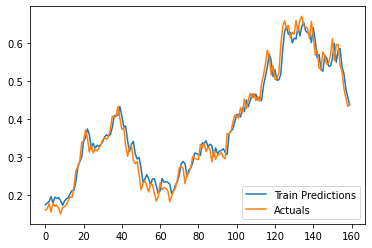

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])
plt.legend(['Train Predictions', 'Actuals'], loc='lower right')

In [ ]:
val_predictions = LSTMModel.predict(x_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val.flatten()})
val_results

2/2 [==============================] - 0s 18ms/step


Val Predictions   Actuals
0          0.441547  0.466076
1          0.465638  0.458322
2          0.460745  0.484737
3          0.481344  0.515283
4          0.509275  0.527401
5          0.521275  0.532831
6          0.525605  0.526077
7          0.519333  0.464083
8          0.464862  0.435066
9          0.435232  0.440039
10         0.439385  0.484670
11         0.481069  0.475764
12         0.477832  0.466216
13         0.467051  0.430689
14         0.434306  0.455839
15         0.452666  0.480929
16         0.477929  0.501046
17         0.497661  0.533957
18         0.526965  0.546339
19         0.539082  0.534553
20         0.528260  0.535413
21         0.527421  0.586401
22         0.573047  0.568986
23         0.561880  0.570046
24         0.560666  0.599844
25         0.587112  0.603817
26         0.592931  0.552895
27         0.547660  0.526077
28         0.520345  0.562033
29         0.551744  0.548194
30         0.543932  0.587792
31         0.577528  0.596533
32         0.587348  0.597129
33         0.586893  0.619179
34         0.605382  0.631827
35         0.617640  0.686258
36         0.666628  0.724069
37         0.702726  0.733406
38         0.710896  0.746980
39         0.721833  0.753337

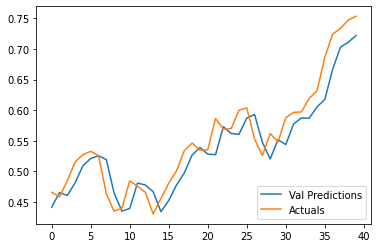

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])
plt.legend(['Val Predictions', 'Actuals'], loc='lower right')

In [ ]:
test_predictions = LSTMModel.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test.flatten()})
test_results

1/1 [==============================] - 0s 42ms/step


Test Predictions   Actuals
0           0.727642  0.778368
1           0.750782  0.777441
2           0.750990  0.761350
3           0.736206  0.778302
4           0.751493  0.838626
5           0.807951  0.824588
6           0.795777  0.846705
7           0.813916  0.858293
8           0.824357  0.772143
9           0.745727  0.781811
10          0.753090  0.784791
11          0.758950  0.823462
12          0.795493  0.826641
13          0.798567  0.880874
14          0.846582  0.899084
15          0.862272  0.891932
16          0.853706  0.905440
17          0.865149  0.892064
18          0.853234  0.847566
19          0.812937  0.862399
20          0.827422  0.892064
21          0.856729  0.869153
22          0.835839  0.975301

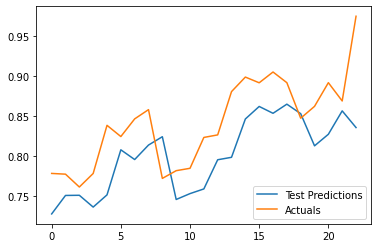

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])
plt.legend(['Test Predictions', 'Actuals'], loc='lower right')

### Post Seperation Scaling

(1980, 21)

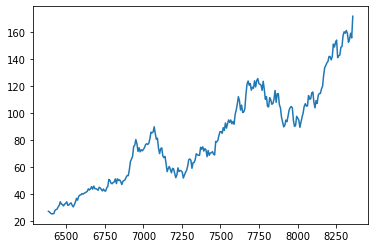

In [ ]:
temp_apple_df = apple_df
temp_apple_df = temp_apple_df[temp_apple_df['Date'].str.contains('201')]
close_prices = temp_apple_df['Close']
temp_apple_df['Close'][::7].plot()
temp_apple_df.shape

In [ ]:
slimmed_df = temp_apple_df['Close'].dropna()
X1, y1 = df_to_X_y(temp_apple_df['Close'], 60)

X_train1, y_train = X1[:1400], y1[:1400]
X_val1, y_val = X1[1400:1700], y1[1400:1700]
X_test1, y_test = X1[1700:], y1[1700:]

scaler = MinMaxScaler(feature_range=(0,1))

x_train = np.reshape(scaler.fit_transform(x_train.reshape(-1,1)), (X_train1.shape[0], X_train1.shape[1], 1))
x_test = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))
x_val = np.reshape(scaler.fit_transform(x_val.reshape(-1,1)), (X_val1.shape[0], X_val1.shape[1], 1))

X1.shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1920, 60, 1),
 (1400, 60, 1),
 (1400,),
 (300, 60, 1),
 (300,),
 (220, 60, 1),
 (220,))

In [ ]:
modelcp = ModelCheckpoint('model/', save_best_only=True)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size= 1, epochs=3, callbacks=[modelcp])

Epoch 1/3
1400/1400 [==============================] - ETA: 0s - loss: 837.6497

1400/1400 [==============================] - 71s 47ms/step - loss: 837.6497 - val_loss: 1060.7065
Epoch 2/3
1399/1400 [============================>.] - ETA: 0s - loss: 701.0690

1400/1400 [==============================] - 65s 46ms/step - loss: 700.7347 - val_loss: 1022.3613
Epoch 3/3
1400/1400 [==============================] - ETA: 0s - loss: 707.0415

1400/1400 [==============================] - 66s 47ms/step - loss: 707.0415 - val_loss: 888.0457


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7/7 [==============================] - 1s 34ms/step


2140.446217373935

In [ ]:
from tensorflow.keras.models import load_model
LSTMModel = load_model('model/')

In [ ]:
train_predictions = LSTMModel.predict(x_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train.flatten()})
train_results

44/44 [==============================] - 2s 34ms/step


Train Predictions  Actuals
0             74.665512   30.094
1             74.665512   30.219
2             74.665520   30.543
3             74.665527   30.674
4             74.665527   30.812
...                 ...      ...
1395          74.667282  105.660
1396          74.667267  107.230
1397          74.667282  106.440
1398          74.667267  107.100
1399          74.667282  109.080

[1400 rows x 2 columns]

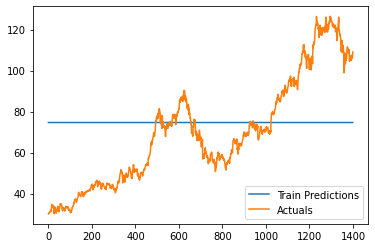

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])
plt.legend(['Train Predictions', 'Actuals'], loc='lower right')

In [ ]:
val_predictions = LSTMModel.predict(x_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val.flatten()})
val_results

10/10 [==============================] - 0s 31ms/step


Val Predictions  Actuals
0          74.667068   109.07
1          74.667099   110.72
2          74.667175   114.16
3          74.667351   110.51
4          74.667229   109.81
..               ...      ...
295        74.667450   115.21
296        74.667458   114.45
297        74.667427   114.68
298        74.667435   115.41
299        74.667458   114.92

[300 rows x 2 columns]

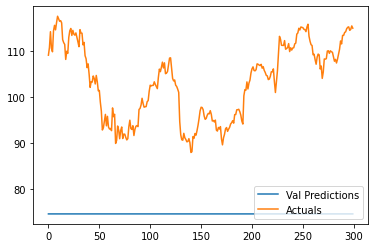

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])
plt.legend(['Val Predictions', 'Actuals'], loc='lower right')

In [ ]:
test_predictions = LSTMModel.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test.flatten()})
test_results

7/7 [==============================] - 0s 36ms/step


Test Predictions  Actuals
0           73.840363   114.89
1           73.840340   113.99
2           73.840218   114.31
3           73.840172   114.19
4           73.840111   114.77
..                ...      ...
215         73.833694   173.63
216         73.833733   174.18
217         73.833740   175.61
218         73.833694   175.25
219         73.833603   174.67

[220 rows x 2 columns]

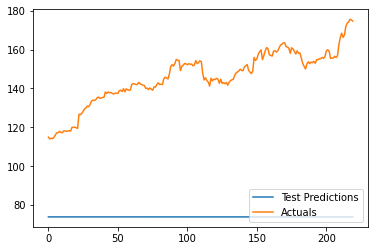

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])
plt.legend(['Test Predictions', 'Actuals'], loc='lower right')

## Combined Dataset - Daily Average

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Combined 35 Tech Companies.xlsx to Combined 35 Tech Companies.xlsx


In [ ]:
combined_df = pd.read_excel("Combined 35 Tech Companies.xlsx")

In [ ]:
combined_df.columns

Index(['Date', 'Close', 'Volume', 'OpenInt', 'EGS', 'Company_Name', 'day',
       'year', 'month', 'h-c', 'c-l', 'c-o', 'ewm10', 'ewm50', 'ewm100',
       'ewm200', 'ma10', 'ma50', 'ma100', 'ma200', 'std10', 'std50', 'std100',
       'std200', 'UB', 'LB', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7',
       'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15',
       'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 'lag21', 'lag22', 'lag23',
       'lag24', 'lag25', 'lag26', 'lag27', 'lag28', 'lag29', 'lag30', 'lag31',
       'lag32', 'lag33', 'lag34', 'lag35', 'lag36', 'lag37', 'lag38', 'lag39',
       'lag40', 'lag41', 'lag42', 'lag43', 'lag44', 'lag45', 'lag46', 'lag47',
       'lag48', 'lag49', 'lag50', 'Tomorrow_Close'],
      dtype='object')

In [ ]:
combined_df.head()

Date    Close    Volume  OpenInt  EGS Company_Name  day  year  month  \
0 1980-01-03  0.26459  12665490        0    2         INTC    3  1980      1   
1 1980-01-04  0.26459  13431648        0    2         INTC    4  1980      1   
2 1980-01-07  0.26459  11564146        0    2         INTC    0  1980      1   
3 1980-01-08  0.28077  15586456        0    2         INTC    1  1980      1   
4 1980-01-09  0.28868  19656654        0    2         INTC    2  1980      1   

       h-c  ...  lag42  lag43  lag44  lag45  lag46  lag47  lag48  lag49  \
0  0.00798  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1  0.00000  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2  0.00798  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3  0.00000  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4  0.00799  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   lag50  Tomorrow_Close  
0    NaN         0.26459  
1    NaN         0.26459  
2    NaN         0.28077  
3    NaN         0.28868  
4    NaN         0.28868  

[5 rows x 76 columns]

In [ ]:
combinedv1_df = combined_df
combinedv1_df.index = pd.to_datetime(combinedv1_df['Date'], format = '%Y/%m/%d')
combinedv1_df = combinedv1_df[['Close', 'Tomorrow_Close', 'Company_Name']]
combinedv1_df

Close  Tomorrow_Close Company_Name
Date                                              
1980-01-03    0.26459         0.26459         INTC
1980-01-04    0.26459         0.26459         INTC
1980-01-07    0.26459         0.28077         INTC
1980-01-08    0.28077         0.28868         INTC
1980-01-09    0.28868         0.28868         INTC
...               ...             ...          ...
2017-11-10  111.12000       110.41000         SWKS
2017-11-10   52.33000        52.40000         TEAM
2017-11-10   97.05000        96.94000          TXN
2017-11-10  109.42000       109.75000         VRSN
2017-11-10  106.17000       107.31000         WDAY

[168247 rows x 3 columns]

In [ ]:
companies = combinedv1_df['Company_Name'].unique()
companies
dates = combinedv1_df.index.values
dates
len(dates)

168247

In [ ]:
## Create Feature Vector
# Must be the same as input_shape in LSTM
companies = combinedv1_df['Company_Name'].unique()
dates = combinedv1_df.index.values
fv = []

for date in dates:
  print(date)
  dateData = []
  ##currDateData = combinedv1_df.loc[date]
  print(currDateData)
  for i in range(len(companies)):
    company = companies[i]
    print(company)
    companyDates = combinedv1_df.loc[combinedv1_df['Company_Name'] == company]
    # print(companyDates)

    try:
      targetArr = companyDates.loc[[date]].to_numpy()
    except KeyError:
      targetArr = np.array([0, 0]) # Default value needs to be different
    
    dateData.append(targetArr)
  fv.append(date)

fv.head()

Streaming output truncated to the last 5000 lines.
MRVL
GOOGL
ANSS
CDNS
CTSH
SWKS
BIDU
AVGO
FTNT
NXPI
SPLK
PANW
WDAY
GOOG
MTCH
TEAM
OKTA
2001-06-01T00:00:00.000000000
Close             0.28077
Tomorrow_Close    0.28868
Company_Name         INTC
Name: 1980-01-08 00:00:00, dtype: object
INTC
TXN
AMD
ADI
AAPL
AMAT
ADSK
MSFT
ADBE
MU
KLAC
LRCX
QCOM
SNPS
MCHP
INTU
VRSN
NVDA
MRVL
GOOGL
ANSS
CDNS
CTSH
SWKS
BIDU
AVGO
FTNT
NXPI
SPLK
PANW
WDAY
GOOG
MTCH
TEAM
OKTA
2001-06-01T00:00:00.000000000
Close             0.28077
Tomorrow_Close    0.28868
Company_Name         INTC
Name: 1980-01-08 00:00:00, dtype: object
INTC
TXN
AMD
ADI
AAPL
AMAT
ADSK
MSFT
ADBE
MU
KLAC
LRCX
QCOM
SNPS
MCHP
INTU
VRSN
NVDA
MRVL
GOOGL
ANSS
CDNS
CTSH
SWKS
BIDU
AVGO
FTNT
NXPI
SPLK
PANW
WDAY
GOOG
MTCH
TEAM
OKTA
2001-06-01T00:00:00.000000000
Close             0.28077
Tomorrow_Close    0.28868
Company_Name         INTC
Name: 1980-01-08 00:00:00, dtype: object
INTC
TXN
AMD
ADI
AAPL
AMAT
ADSK
MSFT
ADBE
MU
KLAC
LRCX
QCOM
SNPS
MCHP
INTU

In [ ]:
## Train test val split
X_train1, y_train1 = X1[:7300], y1[:7300]
X_val1, y_val1 = X1[7300:7800], y1[7300:7800]
X_test1, y_test1 = X1[7800:], y1[7800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(InputLayer((5, 1)))
LSTMModel.add(LSTM(64, input_shape=(35, 2)))
LSTMModel.add(Dense(8, 'relu'))
LSTMModel.add(Dense(1, 'linear'))

LSTMModel.summary()

In [ ]:
LSTMcp = ModelCheckpoint('LSTMModel/', save_best_only=True)
LSTMModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
history = LSTMModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300, callbacks=[LSTMcp])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Martingale series scores

In [12]:
y_test.shape

(138,)